<a href="https://colab.research.google.com/github/nekodinka/data_analytics/blob/main/Final_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align='right'><i>Dinara Khairullina</i></p>

<h1><font color='forestgreen'><center>Time Series Analysis of Optician Retail Data</font></center></h1>

The project is dedicated to predicting demand for a medium-size optician retail, located in Russia. Before COVID-19, sales of the optician business were quite predictable: seasonal fluctuation and slightly increasing trend, however since pandemic has started any recommendations and plans are off. Therefore, our goal is to <b><i>find variables and model that could predict the demand well in the unstable covid environment.</b></i> The mean absolute percentage error (MAPE) on test data of the 2nd half of 2021 must be lower than 0.1, which is 10%, this is a management requirement.The paper is focus on data before 2022.

In the process we divide 24 stores into 4 groups based on their seasonality.

<u>Variables used:</u>
* Rubles to euros exchange rate per month
* New COVID cases in Russia per month
* New COVID cases in the city per month
* New COVID deaths in Russia per month
* New COVID deaths in city per month 

<u>Time Series Methods used:</u>
* SARIMAX (Univariate total, Univariate by groups)
* LSTM (Univariate total, Multivariate total, Multivariate by groups)
* Prophet (Univariate total, Multivariate total, Multivariate by groups)

<u>As a result</u>, we build 22 models, and decide that the best one is <b>LSTM Multivariate</b>, that include <i>revenue</i>, <i>euro</i>, <i>new covid cases in Russia</i>, <i>new covid deaths in Russia</i>, <i>new covid cases in the city</i>, <i>new covid deaths in the city</i>. Its <b>MAPE is 0.058</b>, which meet the requirements to be lower 0.1, and <b>RMSE is 0.846</b>, which is the lowest score among the models.<br>
The results of the project could be used in the company, if the new political and economic distress did not happen. 



<h3>Content</h>

[1. Import](#c1)<br>
[2. Handling statistical outliers](#c2)<br>
* [2.1 April 2020](#c2.1)<br>
* [2.2 Amethyst](#c2.2)<br>

[3. Exploratory Data Analysis](#c3)<br>
[4. Time Series Analysis](#c4)<br>
* [SARIMAX](#c5.1)<br>
* [SARIMAX by groups](#c5.2)<br>
* [LSTM Univariate](#c5.3)<br>
* [LSTM Multivariate](#c5.4)<br>
* [LSTM Multivariate by groups](#c5.5)<br>
* [Prophet Univariate](#c5.6)<br>
* [Prophet Multivariate](#c5.7)<br>
* [Prophet Multivariate by groups](#c5.8)<br>

[5. Results](#c5)

# <a name="c1">Import</a>

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.0 MB/s 
     |████████████████████████████████| 9.8 MB 32.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import io
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime, date 
import datetime
import os
import statistics
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse
import statsmodels.graphics.tsaplots as sgt
from sklearn.preprocessing import StandardScaler, MinMaxScaler                     
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from pmdarima import auto_arima
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from keras.models import Sequential
from keras.layers import Dense, LSTM, RepeatVector, Dropout
from operator import truediv
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow import keras
RANDOM_SEED = 12345
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = '0'
pd.options.display.float_format = '{:.3f}'.format
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
import matplotlib.pylab as pylab
params = {'figure.figsize': (8, 4),
          'axes.titlesize': 12,
          'axes.labelsize': 10,
          'legend.fontsize': 8,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'axes.titleweight': 'bold',
          'lines.linewidth': 1,
          'savefig.dpi': 500
         }
pylab.rcParams.update(params)

<h3><b>Optician Retail Data</h></b>

The project is based on an optician retail sales data aggregated by months for 24 stores from 2015 to 2021. 


The data we hold is protected by non-disclosure agreement, so first of all we have scaled it with MinMaxScaler(), so to turn the minimum value in data frame to 0, the maximum value to 1. The store names have also been renamed to gemstones. Hence, we obtain data frame with 1 column of date, 24 columns of stores, 84 rows with month revenue.

In [ ]:
try:
  link = 'https://drive.google.com/file/d/1sbF8P1cJDYbbJExoiN79dUQA2ec1_Rv0/view?usp=sharing'
  !gdown --id 1sbF8P1cJDYbbJExoiN79dUQA2ec1_Rv0
  df = pd.read_csv('df_scaled_renamed.csv')
except:
  from google.colab import files
  uploaded = files.upload() # df_scaled_renamed.csv
  df = pd.read_csv(io.BytesIO(uploaded['df_scaled_renamed.csv']))

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1sbF8P1cJDYbbJExoiN79dUQA2ec1_Rv0
To: /content/df_scaled_renamed.csv
100% 40.1k/40.1k [00:00<00:00, 33.5MB/s]


In [ ]:
df['date'] = df['date'].astype('datetime64[M]')
df = df.set_index('date')
df

Amethyst  Beryl  Bixbite  Bloodstone  Citrine  Coral  Diamond  \
date                                                                        
2015-01-01     0.171  0.209    0.500       0.266    0.029  0.289    0.473   
2015-02-01     0.220  0.207    0.557       0.292    0.066  0.357    0.467   
2015-03-01     0.327  0.311    0.543       0.313    0.097  0.408    0.550   
2015-04-01     0.243  0.239    0.556       0.340    0.087  0.382    0.570   
2015-05-01     0.291  0.243    0.475       0.303    0.085  0.288    0.429   
...              ...    ...      ...         ...      ...    ...      ...   
2021-08-01     0.262  0.255    0.762       0.499    0.532  0.706    0.725   
2021-09-01     0.313  0.376    0.609       0.515    0.524  0.503    0.699   
2021-10-01     0.156  0.422    0.720       0.419    0.499  0.538    0.766   
2021-11-01     0.087  0.396    0.697       0.580    0.427  0.580    0.674   
2021-12-01     0.262  0.286    0.555       0.520    0.526  0.509    0.716   

            Emerald  Fluorite  Garnet  ...  Marble  Moonstone  Opal  Quartz  \
date                                   ...                                    
2015-01-01    0.243     0.217   0.293  ...   0.467      0.351 0.346   0.411   
2015-02-01    0.260     0.231   0.367  ...   0.506      0.379 0.334   0.345   
2015-03-01    0.382     0.398   0.406  ...   0.495      0.424 0.491   0.435   
2015-04-01    0.282     0.354   0.401  ...   0.464      0.399 0.457   0.407   
2015-05-01    0.293     0.320   0.275  ...   0.376      0.478 0.398   0.428   
...             ...       ...     ...  ...     ...        ...   ...     ...   
2021-08-01    0.505     0.667   0.425  ...   0.547      0.487 0.402   0.672   
2021-09-01    0.531     0.783   0.327  ...   0.416      0.467 0.357   0.590   
2021-10-01    0.558     0.554   0.483  ...   0.425      0.457 0.329   0.458   
2021-11-01    0.451     0.634   0.510  ...   0.504      0.407 0.392   0.486   
2021-12-01    0.521     0.551   0.502  ...   0.372      0.333 0.328   0.365   

            Rhodonite  Ruby  Sapphire  Sodalite  Tigereye  Topaz  
date                                                              
2015-01-01      0.177 0.189     0.147     0.150     0.254  0.205  
2015-02-01      0.192 0.210     0.132     0.166     0.215  0.224  
2015-03-01      0.129 0.233     0.192     0.143     0.260  0.207  
2015-04-01      0.187 0.216     0.203     0.200     0.303  0.180  
2015-05-01      0.210 0.198     0.176     0.120     0.238  0.182  
...               ...   ...       ...       ...       ...    ...  
2021-08-01      0.259 0.517     0.314     0.417     0.427  0.562  
2021-09-01      0.262 0.539     0.313     0.404     0.433  0.493  
2021-10-01      0.202 0.478     0.298     0.421     0.393  0.479  
2021-11-01      0.210 0.492     0.372     0.366     0.414  0.400  
2021-12-01      0.202 0.454     0.196     0.393     0.321  0.376  

[84 rows x 24 columns]

<h3><b>Euro and COVID data</h></b>

External data is collected from open source, based on official statistics. We managed to find average EUR/RUB exchange rate by months  as well as average new COVID cases & deaths in Russia, and the same variables for the city where the optician retail is located. COVID variables are available since March of 2020, when first cases were documented in Russia.

In [ ]:
try:
  link = 'https://drive.google.com/file/d/1AyHU1J93Ug7IzcTiiQQvIzZDA-nCQMV2/view?usp=sharing'
  !gdown --id 1AyHU1J93Ug7IzcTiiQQvIzZDA-nCQMV2
  df_covid = pd.read_csv('df_covid.csv')
except:
  from google.colab import files
  uploaded = files.upload() # df_covid.csv
  df_covid = pd.read_csv(io.BytesIO(uploaded['df_covid.csv']))

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1AyHU1J93Ug7IzcTiiQQvIzZDA-nCQMV2
To: /content/df_covid.csv
100% 4.85k/4.85k [00:00<00:00, 4.49MB/s]


In [ ]:
df_covid['date'] = df_covid['date'].astype('datetime64[M]')
df_covid = df_covid.set_index('date')
df_covid.head()

euro  All_new_cases  All_new_deaths  P_new_cases  P_new_deaths
date                                                                       
2015-01-01 75.338          0.000           0.000        0.000         0.000
2015-02-01 73.132          0.000           0.000        0.000         0.000
2015-03-01 65.446          0.000           0.000        0.000         0.000
2015-04-01 57.357          0.000           0.000        0.000         0.000
2015-05-01 56.411          0.000           0.000        0.000         0.000

First we look on revenue data (df): its missinngs and outliers.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 2015-01-01 to 2021-12-01
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Amethyst    81 non-null     float64
 1   Beryl       84 non-null     float64
 2   Bixbite     84 non-null     float64
 3   Bloodstone  84 non-null     float64
 4   Citrine     84 non-null     float64
 5   Coral       84 non-null     float64
 6   Diamond     84 non-null     float64
 7   Emerald     84 non-null     float64
 8   Fluorite    84 non-null     float64
 9   Garnet      84 non-null     float64
 10  Jade        84 non-null     float64
 11  Jasper      84 non-null     float64
 12  Kyanite     84 non-null     float64
 13  Malachite   84 non-null     float64
 14  Marble      84 non-null     float64
 15  Moonstone   84 non-null     float64
 16  Opal        84 non-null     float64
 17  Quartz      84 non-null     float64
 18  Rhodonite   84 non-null     float64
 19  Ruby       

In [ ]:
df[['Amethyst']][df.isna().any(axis=1)]

Amethyst
date                
2020-04-01       NaN
2020-05-01       NaN
2020-06-01       NaN

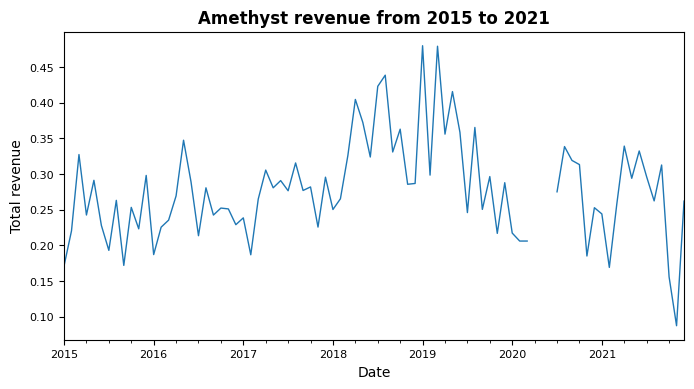

In [ ]:
df['Amethyst'].plot()
plt.title('Amethyst revenue from 2015 to 2021')
plt.xlabel('Date')
plt.ylabel('Total revenue')
plt.show()

During three months in the beginning of the pandemic Amethyst did not work due to the fact that it is located in a mall, where local covid regulations had to be applied.
<br><br>
Date is missing:
- 2020-04-01
- 2020-05-01
- 2020-06-01

Let us look on the total revenue distribution.

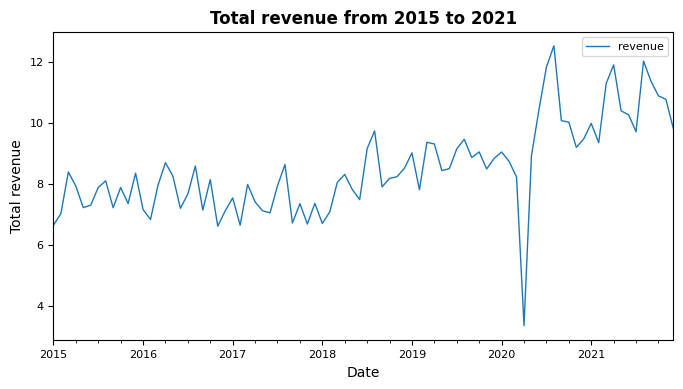

In [ ]:
df_total = pd.DataFrame({'date': df.reset_index()['date'],
                             'revenue':list(df.sum(axis=1))})
df_total['date'] = df_total['date'].astype('datetime64[M]')
df_total = df_total.set_index('date')

df_total.plot()
plt.title('Total revenue from 2015 to 2021')
plt.xlabel('Date')
plt.ylabel('Total revenue')
plt.show()

There was a major decline in April 2020 for all the stores since they were closed up to three weeks following the local covid regulations. The first state regulations were lately updated, so, optician retails were included in the protected medicine field, that can not be closed again.
<p>
Since we know that this was an unnatural decline and with high confidence will not happen again, we should consider April 2020 as well as 3-months closed Amethyst as statistical outliers and flatten them.

# <a name="c2">Handling statistical outliers</a>

In [ ]:
df_new = df.reset_index().copy()

In [ ]:
store_names = ['Amethyst', 'Beryl', 'Bixbite', 'Bloodstone', 'Citrine',
       'Coral', 'Diamond', 'Emerald', 'Fluorite', 'Garnet', 'Jade', 'Jasper',
       'Kyanite', 'Malachite', 'Marble', 'Moonstone', 'Opal', 'Quartz',
       'Rhodonite', 'Ruby', 'Sapphire', 'Sodalite', 'Tigereye', 'Topaz']

## <a name="c2.1">April 2020</a>

To flatten April 2020 we follow the formula: $$April 2020 = April 2019 * Growth 2020, $$<br>
<center><font size="4">where Growth2020 is $ \frac{Mean 2020}{Mean 2019} $</center></font>
<p>
This is a standart formula,  used in many companies, including ours.

In [ ]:
lockd_2019 = list(df_new.query('date >= "2019-01-01" & date <= "2019-12-01" & date != "2019-04-01"').mean())
lockd_2020 = list(df_new.query('date >= "2020-01-01" & date <= "2020-12-01" & date != "2020-04-01"').mean())
lockd_2019_04 = list(df_new.query('date == "2019-04-01"').mean())

In [ ]:
df_new.query('date == "2020-04-01"')

date  Amethyst  Beryl  Bixbite  Bloodstone  Citrine  Coral  Diamond  \
63 2020-04-01       NaN  0.217    0.204       0.190    0.043  0.152    0.182   

    Emerald  Fluorite  ...  Marble  Moonstone  Opal  Quartz  Rhodonite  Ruby  \
63    0.236     0.150  ...   0.238      0.111 0.140   0.141      0.076 0.184   

    Sapphire  Sodalite  Tigereye  Topaz  
63     0.117     0.045     0.048  0.148  

[1 rows x 25 columns]

In [ ]:
lockd_2020_04_new = list(np.multiply(lockd_2019_04, list(map(truediv, lockd_2020, lockd_2019))))

In [ ]:
df_new.iloc[63,1:] = lockd_2020_04_new
df_new.query('date == "2020-04-01"')

date  Amethyst  Beryl  Bixbite  Bloodstone  Citrine  Coral  Diamond  \
63 2020-04-01     0.272  0.292    0.666       0.538    0.347  0.598    0.595   

    Emerald  Fluorite  ...  Marble  Moonstone  Opal  Quartz  Rhodonite  Ruby  \
63    0.516     0.619  ...   0.529      0.391 0.367   0.508      0.293 0.414   

    Sapphire  Sodalite  Tigereye  Topaz  
63     0.265     0.276     0.364  0.466  

[1 rows x 25 columns]

## <a name="c2.2">Amethyst</a>

For Amethyst we have 3 missings out of 12 in a year. Since the revenue has a strong seasonal component, it would be incorrect to compare mean of 12 months and mean of 9 months. For this reason we adapt the previous formula using the total ratio of 2020 and 2019 instead of one for Amethyst.<h>
So, the formula is: 
$$Amethyst April 2020 = Amethyst April 2019 * Total Growth 2020, $$<br>
<center><font size="4">where TotalGrowth2020 is $ \frac{Total Mean 2020}{Total Mean 2019} $</center></font>
<p>
Total growth and total mean is obviously ones without Amethyst because it has missings.


In [ ]:
# For Amythyst we cannot compare average growth of 12 months in 2020 and 9 months because of seasonality,
# so we take total growth (without Amethyst instead)
df_new.iloc[63,1] = np.NaN

In [ ]:
a_2019_04 = df_new.query('date == "2019-04-01"')[['Amethyst']].iloc[0,0]
a_2019_05 = df_new.query('date == "2019-05-01"')[['Amethyst']].iloc[0,0]
a_2019_06 = df_new.query('date == "2019-06-01"')[['Amethyst']].iloc[0,0]

In [ ]:
r_2019_04 = []
r_2019_05 = []
r_2019_06 = []
r_2020_04 = []
r_2020_05 = []
r_2020_06 = []
for i in store_names:
  r_2019_04.append(df_new.query('date == "2019-04-01"')[['date', i]].iloc[0,1])
  r_2019_05.append(df_new.query('date == "2019-05-01"')[['date', i]].iloc[0,1])
  r_2019_06.append(df_new.query('date == "2019-06-01"')[['date', i]].iloc[0,1])
  r_2020_04.append(df_new.query('date == "2020-04-01"')[['date', i]].iloc[0,1])
  r_2020_05.append(df_new.query('date == "2020-05-01"')[['date', i]].iloc[0,1])
  r_2020_06.append(df_new.query('date == "2020-06-01"')[['date', i]].iloc[0,1])

In [ ]:
a_2019_04 = r_2019_04[0] # 0 - is Amethyst value index
a_2019_05 = r_2019_05[0]
a_2019_06 = r_2019_06[0]

mean_2019_04 = statistics.mean(r_2019_04[1:]) # Without Amethyst
mean_2019_05 = statistics.mean(r_2019_05[1:])
mean_2019_06 = statistics.mean(r_2019_06[1:])
mean_2020_04 = statistics.mean(r_2020_04[1:])
mean_2020_05 = statistics.mean(r_2020_05[1:])
mean_2020_06 = statistics.mean(r_2020_06[1:])

In [ ]:
df_new.loc[63, 'Amethyst'] = a_2019_04 * (mean_2020_04 / mean_2019_04)
df_new.loc[64, 'Amethyst'] = a_2019_05 * (mean_2020_05 / mean_2019_05)
df_new.loc[65, 'Amethyst'] = a_2019_06 * (mean_2020_06 / mean_2019_06)
df_new.iloc[63:66,:2]

date  Amethyst
63 2020-04-01     0.405
64 2020-05-01     0.463
65 2020-06-01     0.460

# <a name="c3">Exploratory Data Analysis</a>

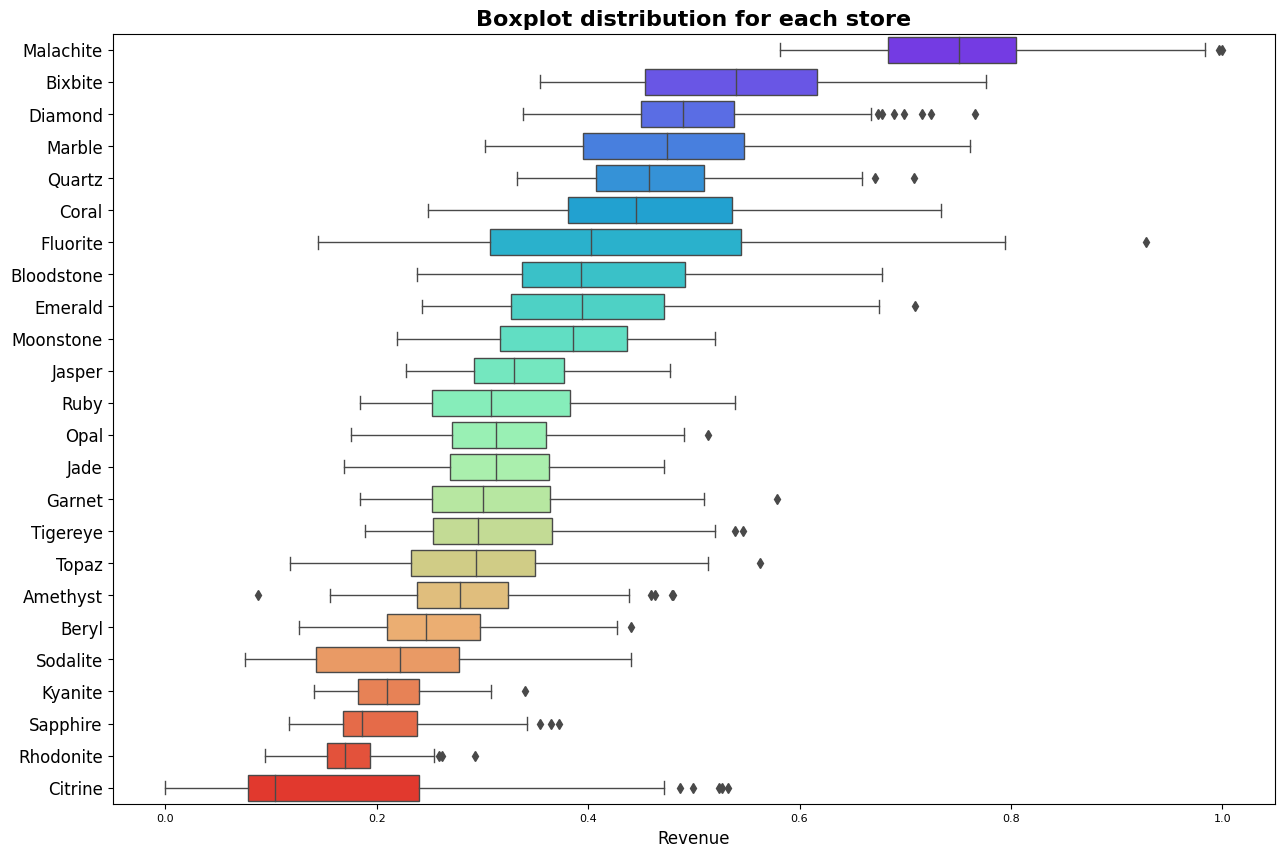

In [ ]:
df_melted = pd.melt(df_new, id_vars=["date"], 
                  var_name="store", value_name="revenue")

stores_high_rev_index = df_melted.groupby('store').agg({'revenue':'mean'}).sort_values('revenue', ascending=False).index

# Plotting
plt.figure(figsize=(15,10))
sns.boxplot(x='revenue', y='store', data=df_melted, palette='rainbow', order=stores_high_rev_index)
plt.title('Boxplot distribution for each store', weight='bold').set_fontsize('16')
plt.ylabel('')
plt.xlabel('Revenue', fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

Most of the stores have an average month revenue from 0.2 to 0.5, however there are two outstanding stores: Malachite with the generally higher revenue up to 1 with mean 0.75 and Citrine with quite variance and the lowest mean (0.1).

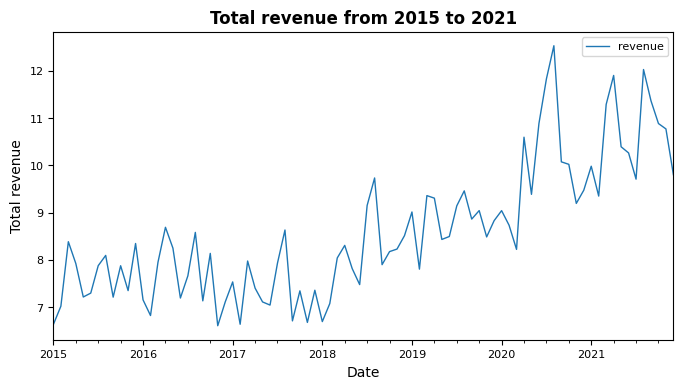

In [ ]:
df_new_total = pd.DataFrame({'date': df_new.reset_index()['date'],
                             'revenue':list(df_new.sum(axis=1))})
df_new_total['date'] = df_new_total['date'].astype('datetime64[M]')
df_new_total = df_new_total.set_index('date')

df_new_total.plot()
plt.title('Total revenue from 2015 to 2021')
plt.xlabel('Date')
plt.ylabel('Total revenue')
plt.show()

Total revenue, which is sum of all stores, is quite turbulent and not smooth, after peak of 1-3 months there is always are strong decline. We see a stable uprising trend after 2018 with great increase for the second half of 2020 (after lockdown).

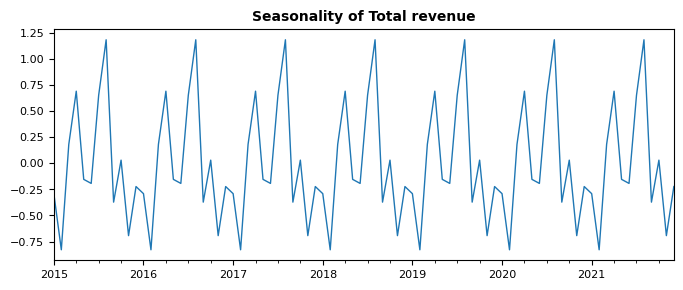

In [ ]:
a = seasonal_decompose(df_new_total['revenue'], model = "add")
plt.figure(figsize = (8,3))
a.seasonal.plot()
plt.xlabel('')
plt.title('Seasonality of Total revenue', fontsize=10)
plt.show()

Seasonal components are interesting. Total revenue has two major peaks, first in April, second and bigger one in August. The most dramatic falls are in February and November. The graph follows the facts optician retail employees know: the peak in April is the beginning of “summer shopping”, when customers came to buy sunglasses, the peak in August is the “start of the school year”, when customers tend to buy new prescribed glasses for their children and themselves as well.

In [ ]:
df_mult = pd.concat([df_new_total, df_covid], axis=1)

In [ ]:
corr = df_mult.corr()
corr.style.background_gradient(cmap='coolwarm')

Second data set, which we obtain is euro and covid metrics aggregated for each month. Euro is highly positive correlated (0.678) with the dependent variable, other variables are moderately correlated: All new cases (0.608), All new deaths (0.612), City new cases (0.566), City new deaths (0.581). At the same time all covid variables are very high positive correlated with each other up to 0.961.

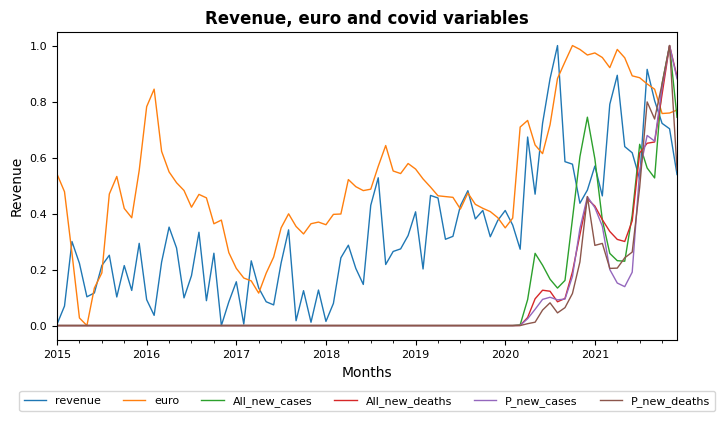

In [ ]:
df_scaled = df_mult.copy()

scaler = MinMaxScaler()
df_scaled[['revenue', 'euro', 'All_new_cases', 'All_new_deaths', 'P_new_cases',
       'P_new_deaths']] = scaler.fit_transform(df_mult[['revenue', 'euro', 'All_new_cases', 'All_new_deaths', 'P_new_cases',
       'P_new_deaths']])

scaler_2 = MinMaxScaler()
dataset_MMS = df_mult.reset_index().filter(['revenue']).values
scaled_data = scaler_2.fit_transform(dataset_MMS)

df_scaled.plot()
plt.title('Revenue, euro and covid variables')
plt.ylabel('Revenue')
plt.xlabel('Months')
plt.legend(bbox_to_anchor=[0.5, -0.25,], loc='lower center', ncol=6)
plt.show()

If we look on mutual distribution of these variables, we immediately notice that EUR/RUB exchange rate repeats the growth segment for revenue.

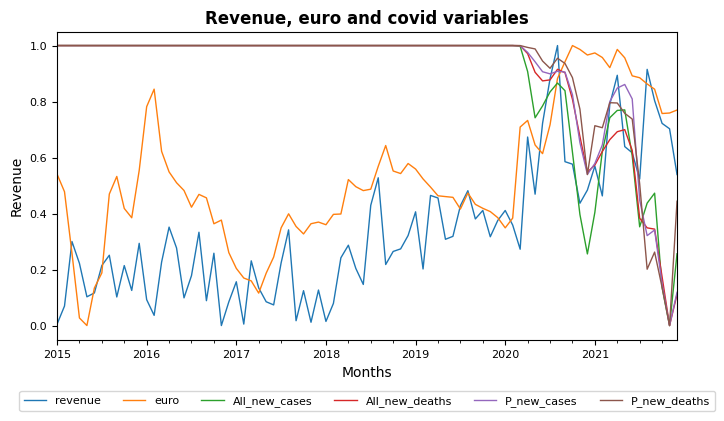

In [ ]:
df_scaled['All_new_cases'] = 1 - df_scaled['All_new_cases']
df_scaled['All_new_deaths'] = 1 - df_scaled['All_new_deaths']
df_scaled['P_new_cases'] = 1 - df_scaled['P_new_cases']
df_scaled['P_new_deaths'] = 1 - df_scaled['P_new_deaths']

df_scaled.plot()
plt.title('Revenue, euro and covid variables')
plt.ylabel('Revenue')
plt.xlabel('Months')
plt.legend(bbox_to_anchor=[0.5, -0.25,], loc='lower center', ncol=6)
plt.show()

Relationship between revenue and covid cases and death is well noticeable on a graph with inverted covid variables. In this way, bottoms of the revenue repeats bottoms of the pandemic, consistently reflecting the situation, where the peak of the pandemic and the high probability of infection lead people to visit public places less often, including stores.

In [ ]:
def f_plot_dist_box(data_, title_):
  fig = plt.figure(figsize=(10, 4), dpi= 120)
  grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)
  ax_left = fig.add_subplot(grid[:-1, :-1])
  ax_right = fig.add_subplot(grid[:-1, -1])  
  sns.distplot(data_, bins=10, ax=ax_left, color='g')
  sns.boxplot(data_, orient="v", color='lightgreen', ax=ax_right)
  ax_right.set_ylabel('')
  ax_left.set_xlabel('')
  ax_left.set_title(str(title_), weight='bold', fontsize=10)
  ax_left.set_title('[{:.2f}'.format(data_.min()) + '; '+'{:.2f}'.format(
      data_.max()) + ']' + ', Mean: {:.2f}'.format(np.mean(data_)),
      loc='right', fontstyle='italic', fontsize='9', weight='normal')
  ax_left.axvline(np.mean(data_),color='r', linestyle='-', label='Mean')
  ax_left.axvline(np.median(data_),color='b', linestyle='--', label='Median')
  ax_left.legend()
  fig.show()
  plt.show()

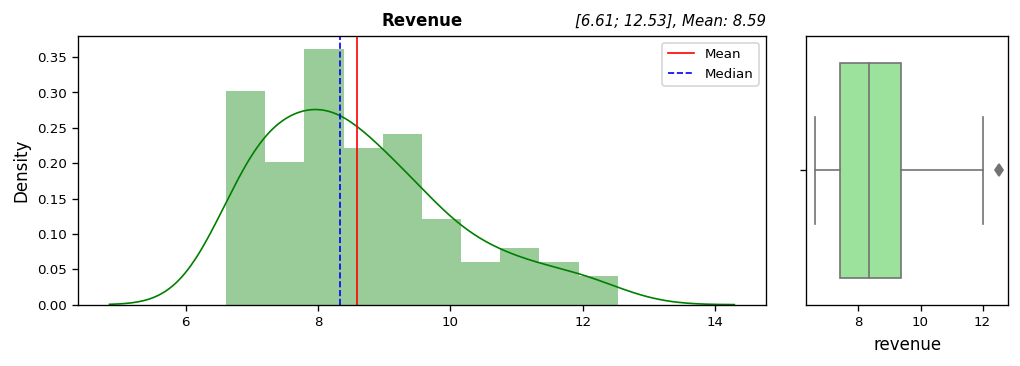

In [ ]:
f_plot_dist_box(df_mult['revenue'], 'Revenue')

Next, let us look on these variables’ distribution. Total revenue is distributed from 6.61 to 8.59 with a mean in 8.59. The distribution remains normal, there is one outlier, but we do not worry about is since the revenue line plot looks fine.

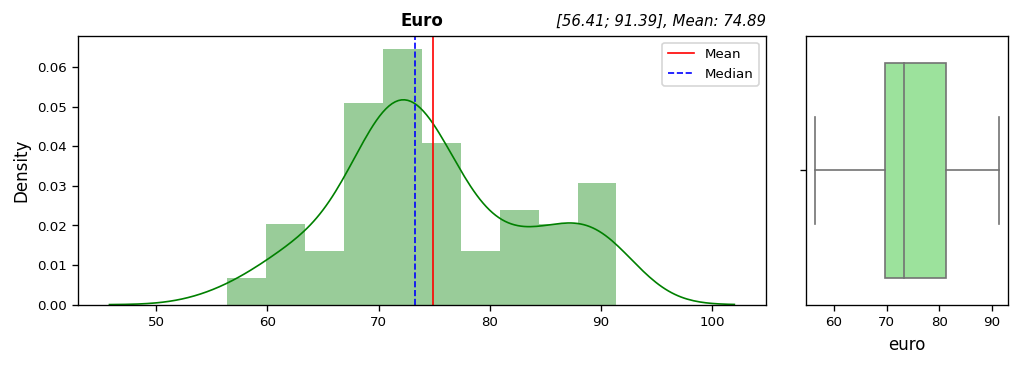

In [ ]:
f_plot_dist_box(df_mult['euro'], 'Euro')

Euro is distributed from 56.41 to 91.39 with a mean in 74.89. The distribution is not normal, most observations are concentrated close to the mean and closer to the upper boarder. There are no outliers.

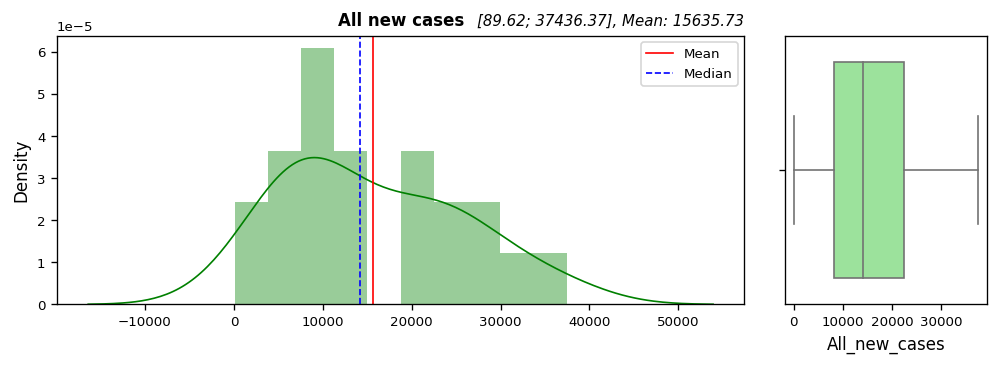

In [ ]:
f_plot_dist_box(df_mult['All_new_cases'].iloc[62:,], 'All new cases')

All new covid cases is distributed from 89.62 to 37436.37 with a mean in15635.73. All observations are contained either before the mean, or closer to the upper boundary. There are no outliers.

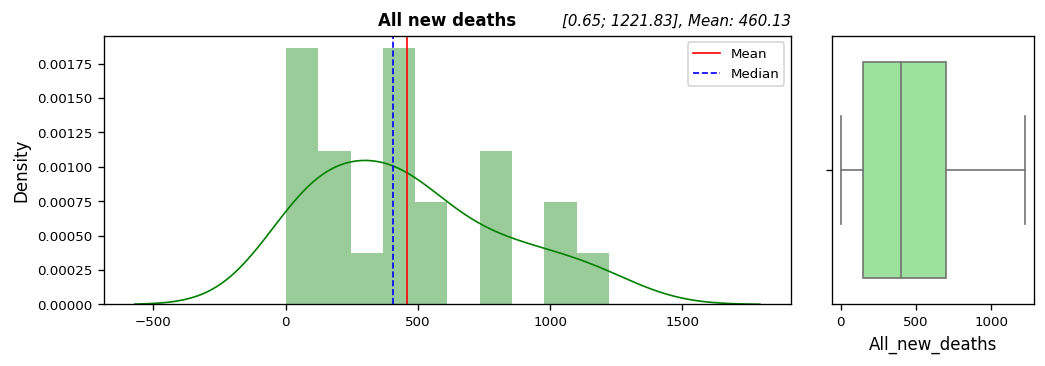

In [ ]:
f_plot_dist_box(df_mult['All_new_deaths'].iloc[62:,], 'All new deaths')

All new covid deaths is distributed from 0.65 to 1221.83 with a mean in 460.13. Most observations are contained before the mean, part closer to the mean and part closer to the lower boundary. There are no outliers.

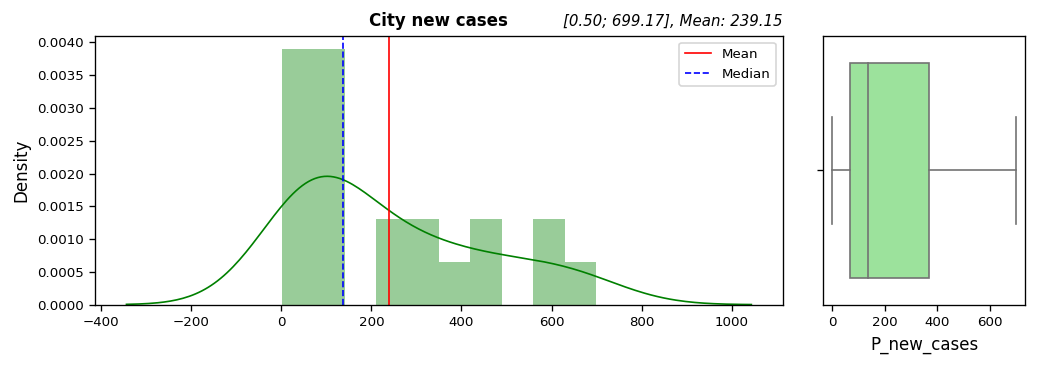

In [ ]:
f_plot_dist_box(df_mult['P_new_cases'].iloc[62:,], 'City new cases')

City new covid cases is distributed from 0.50 to 699.17 with a mean in 239.15. Most observations are contained closer to the lower boundary, however there is a part uniformly distributed after the mean. There are no outliers.

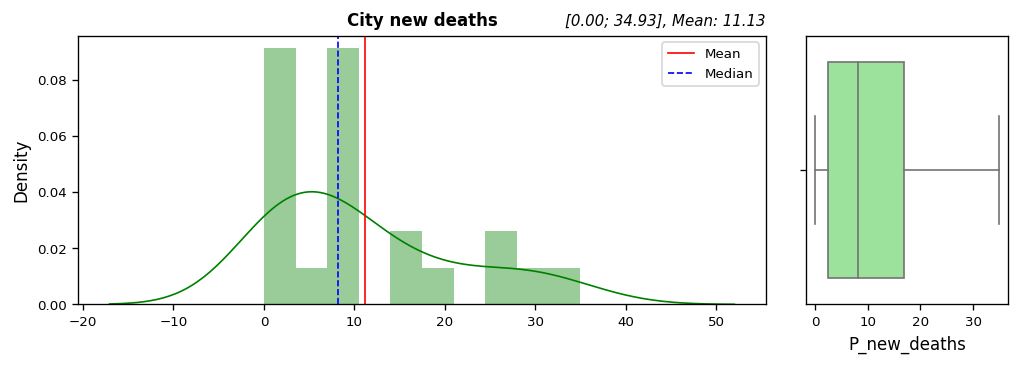

In [ ]:
f_plot_dist_box(df_mult['P_new_deaths'].iloc[62:,], 'City new deaths')

City new covid deaths is distributed from 0.50 to 699.17 with a mean in 239.15. Most observations are contained before the mean, where part is closer to the mean and part is closer to the lower boundary, however there are also a few uniformly distributed after the mean. There are no outliers.

<b><h3>Grouping stores</h3></b>

The original idea was to divide the stores into groups depending on the geographical location (city / town), and depending on the level of revenue. However, it turned out that geography does not have a noticeable impact on revenue, the revenue itself usually vary from 0.2 to 0.5, so it is impossible to distinguish two distinct groups. Therefore, we decide to look at the seasonality of sales using seasonal_decompose(). 

In [ ]:
df_new = df_new.set_index('date')

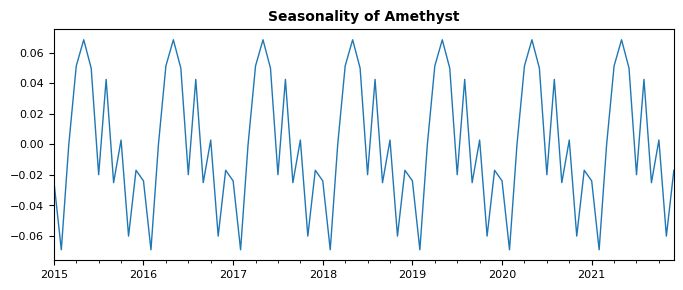

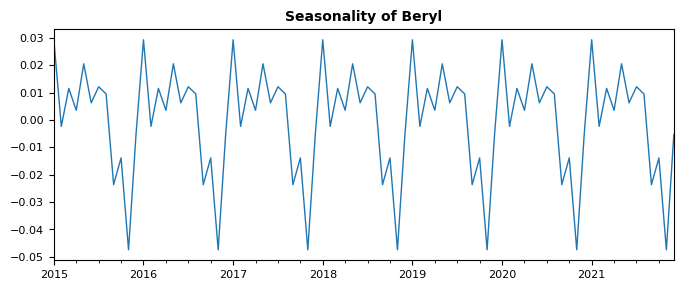

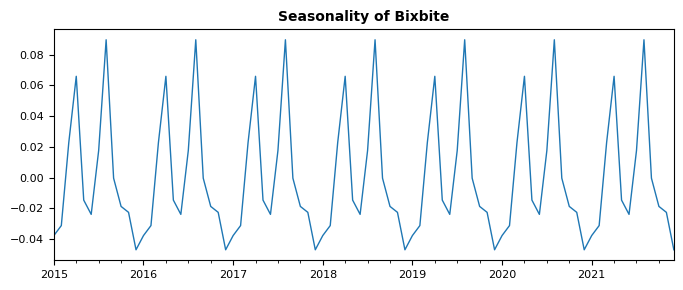

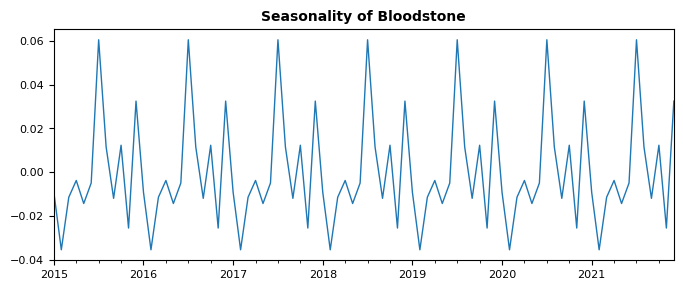

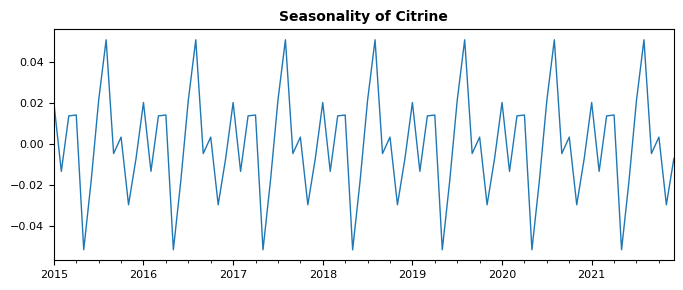

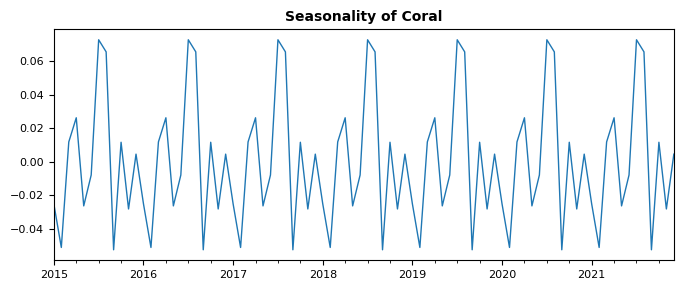

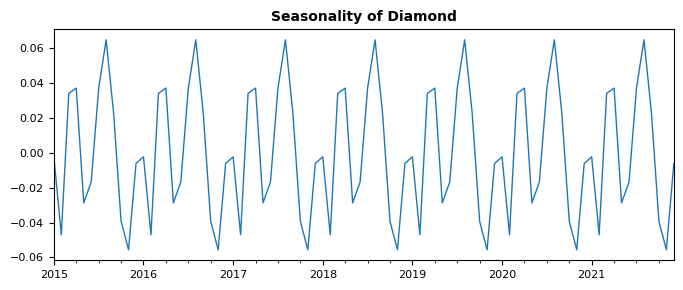

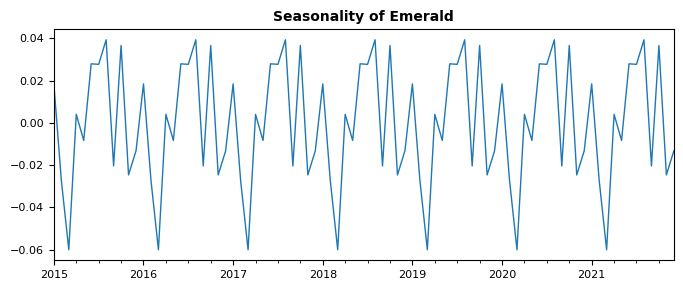

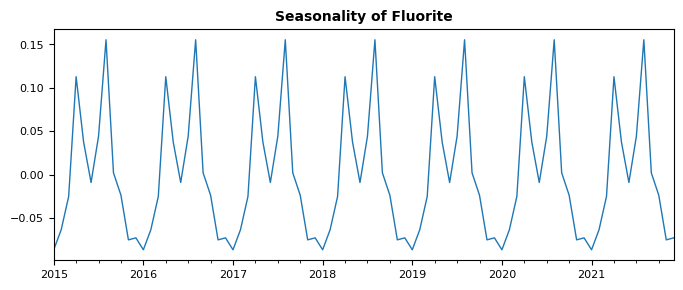

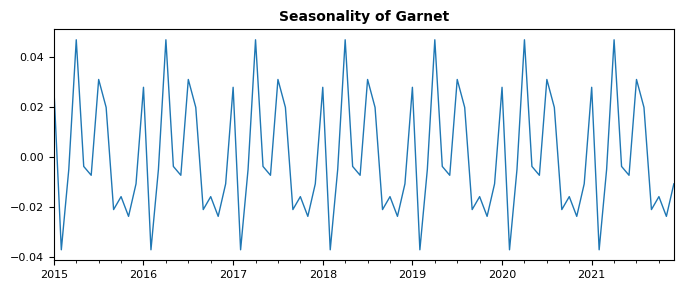

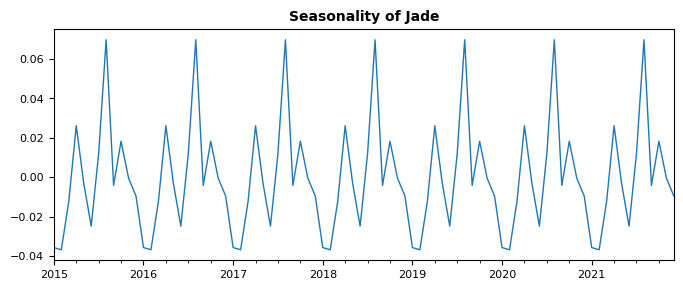

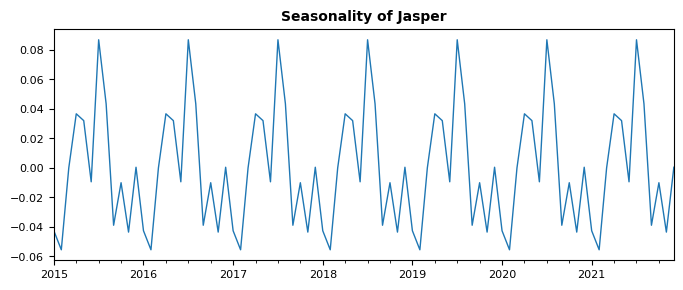

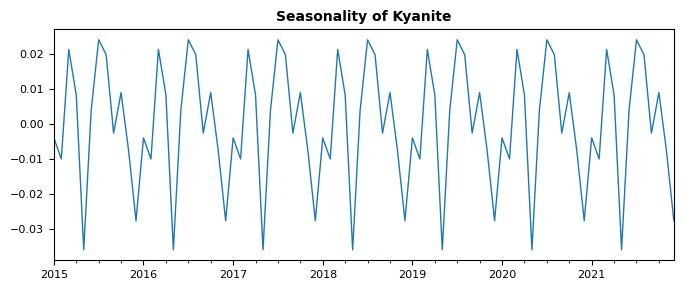

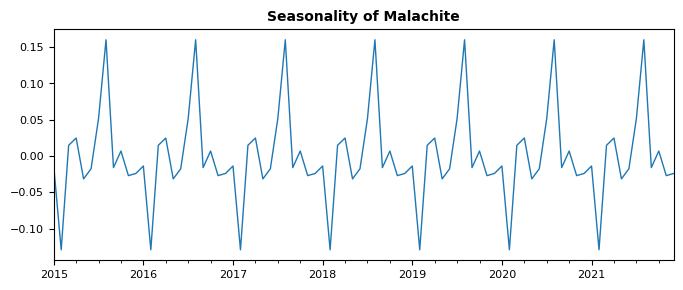

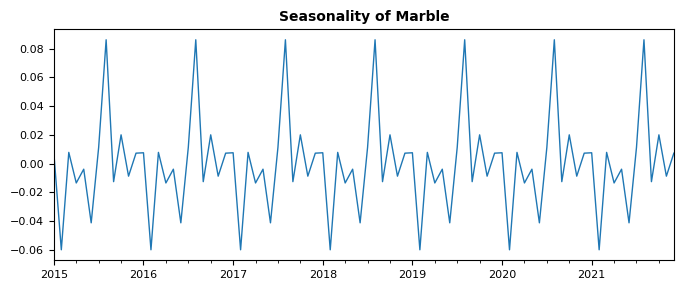

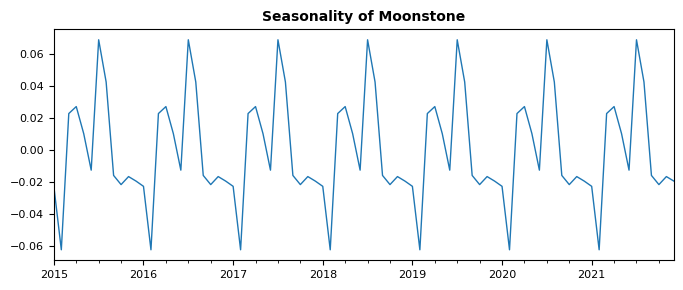

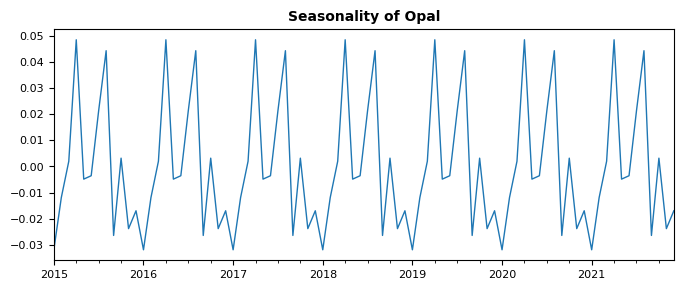

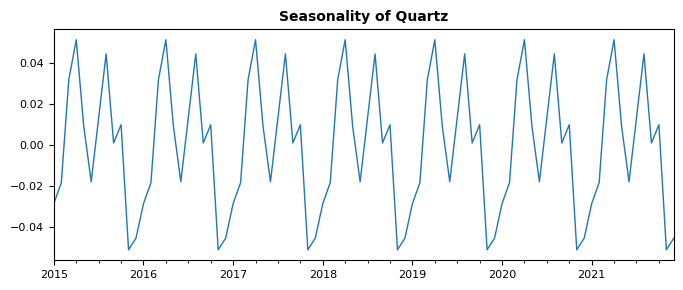

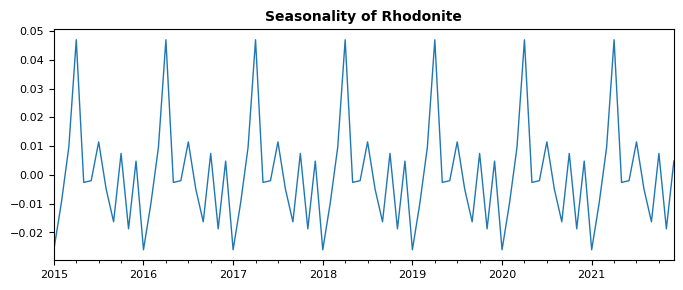

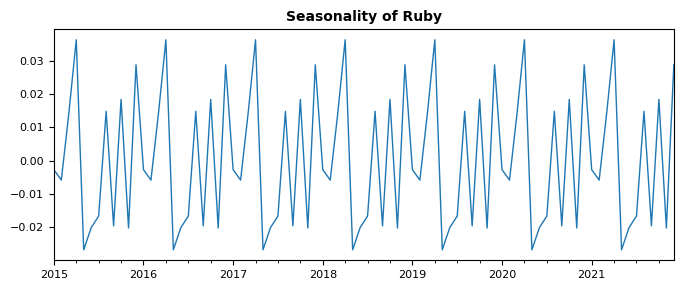

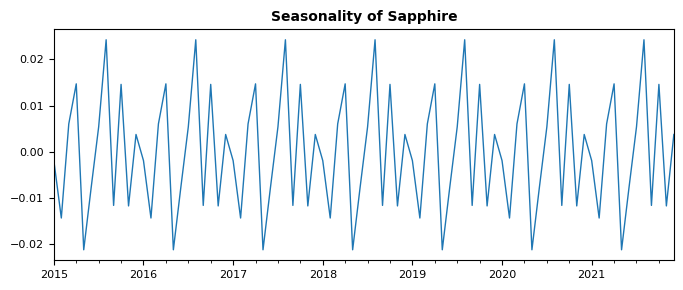

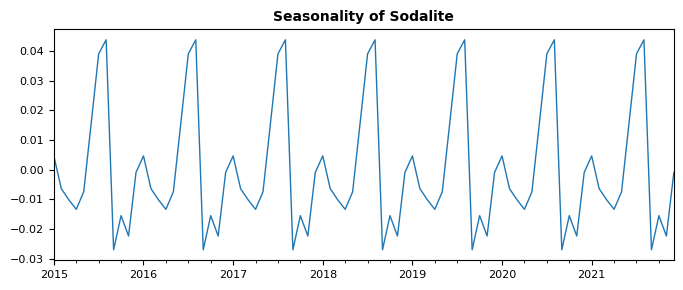

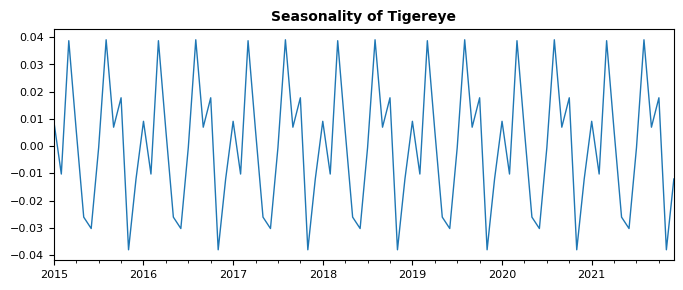

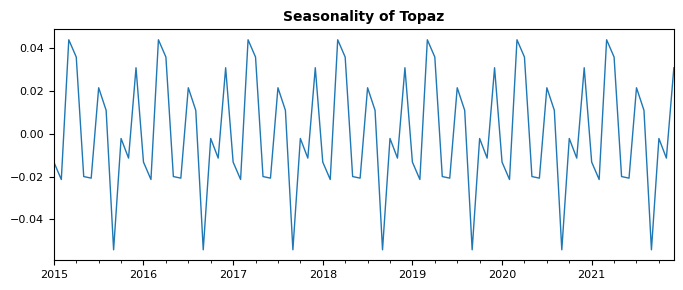

In [ ]:
for i in store_names:
  a = seasonal_decompose(df_new[i], model = "add")
  plt.figure(figsize = (8,3))
  a.seasonal.plot()
  plt.xlabel('')
  plt.title('Seasonality of ' + i, fontsize=10)
  plt.show()

In this way, common patterns were noticeable. Many stores were easy to combine into groups, whereas 7 ("Topaz", "Rhodonite", "Beryl", "Amethyst", "Moonstone", "Sodalite", "Citrine") were difficult, since their patterns are unique (application 1). However, 4 groups of stores were well formed depending on the type of seasonality.

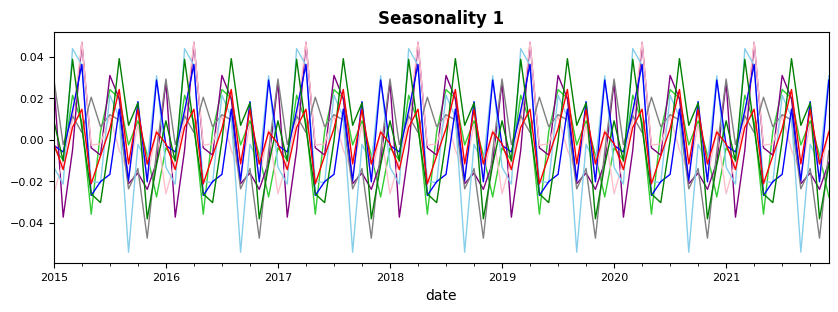

In [ ]:
plt.figure(figsize = (10,3))
seasonal_decompose(df_new["Kyanite"], model = "add").seasonal.plot(color='limegreen')
seasonal_decompose(df_new["Garnet"], model = "add").seasonal.plot(color='purple')
seasonal_decompose(df_new["Rhodonite"], model = "add").seasonal.plot(color='pink')
seasonal_decompose(df_new["Beryl"], model = "add").seasonal.plot(color='gray')
seasonal_decompose(df_new["Topaz"], model = "add").seasonal.plot(color='skyblue')
seasonal_decompose(df_new["Ruby"], model = "add").seasonal.plot(color='blue')
seasonal_decompose(df_new["Tigereye"], model = "add").seasonal.plot(color='green')
seasonal_decompose(df_new["Sapphire"], model = "add").seasonal.plot(color='red')
plt.title('Seasonality 1')
plt.show()

First group includes stores "Kyanite", "Garnet", "Rhodonite", "Beryl", "Topaz", "Ruby", "Tigereye", "Sapphire". Their revenue varies several times during the year; however the variance remains stable, all peaks and falls are steady and even.

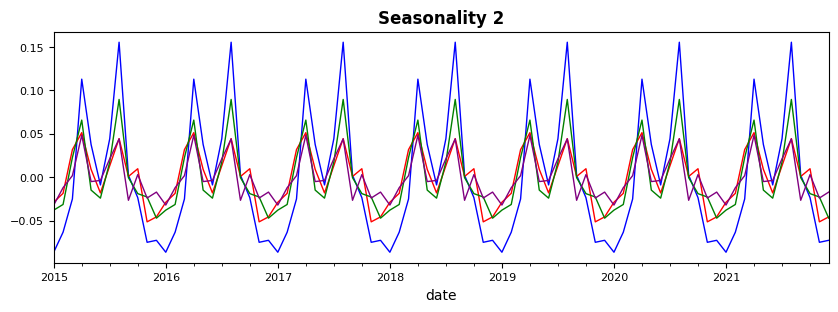

In [ ]:
plt.figure(figsize = (10,3))
seasonal_decompose(df_new["Fluorite"], model = "add").seasonal.plot(color='blue')
seasonal_decompose(df_new["Quartz"], model = "add").seasonal.plot(color='red')
seasonal_decompose(df_new["Bixbite"], model = "add").seasonal.plot(color='green')
seasonal_decompose(df_new["Opal"], model = "add").seasonal.plot(color='purple')
plt.title('Seasonality 2')
plt.show()

Second group includes stores "Fluorite", "Quartz","Bixbite", "Opal". Their revenue has a strong pattern with two uniform peaks in the spring and late summer, a small decrease in the beginning of summer and a strong decrease during winter.

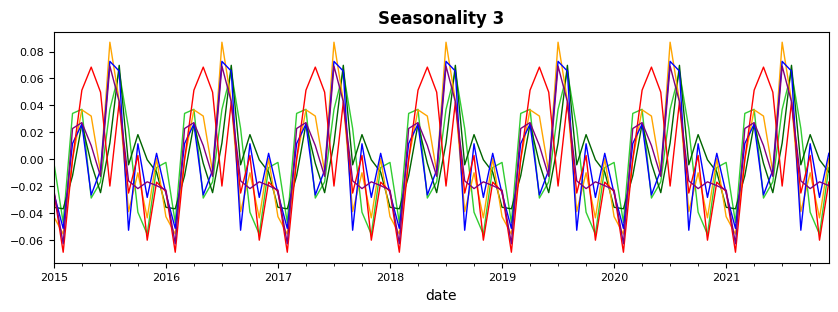

In [ ]:
plt.figure(figsize = (10,3))
seasonal_decompose(df_new["Diamond"], model = "add").seasonal.plot(color='limegreen')
seasonal_decompose(df_new["Jade"], model = "add").seasonal.plot(color='darkgreen')
seasonal_decompose(df_new["Jasper"], model = "add").seasonal.plot(color='orange')
seasonal_decompose(df_new["Coral"], model = "add").seasonal.plot(color='blue')
seasonal_decompose(df_new["Amethyst"], model = "add").seasonal.plot(color='red')
seasonal_decompose(df_new["Moonstone"], model = "add").seasonal.plot(color='purple')
plt.title('Seasonality 3')
plt.show()

Third group includes stores "Diamond", "Jade", "Jasper", "Coral", "Amethyst", "Moonstone". Their revenue also has two peaks, however the one in spring is lower the one which is in late summer. Moreover, it fluctuates during autumn and beginning of winter.

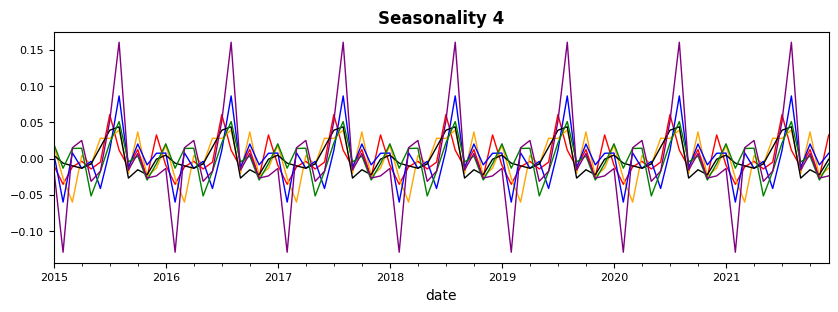

In [ ]:
plt.figure(figsize = (10,3))
seasonal_decompose(df_new["Bloodstone"], model = "add").seasonal.plot(color='red')
seasonal_decompose(df_new["Emerald"], model = "add").seasonal.plot(color='orange')
seasonal_decompose(df_new["Marble"], model = "add").seasonal.plot(color='blue')
seasonal_decompose(df_new["Sodalite"], model = "add").seasonal.plot(color='black')
seasonal_decompose(df_new["Citrine"], model = "add").seasonal.plot(color='green')
seasonal_decompose(df_new["Malachite"], model = "add").seasonal.plot(color='purple')
plt.title('Seasonality 4')
plt.show()

Fourth group includes stores "Bloodstone", "Emerald", "Marble", "Sodalite", "Citrine", "Malachite". Their revenue resembles the third group pattern, however, differ in peak months and angle of incidence, so we decide to form a separate group.

Thereby, four groups of stores based on their seasonality patterns were formed. We use them in two Time Series analysis, by running individual models, summing the predictions and then calculating metrics.

# <a name="c4">Time Series Analysis</a>

For Time Series Analysis we might use several variables:
* Total revenue
* Revenue per store groups (4)
* Russia new covid cases
* Russia new covid deaths
* City new covid cases
* City new covid deaths

Before doing Multivariate Time Series analysis, the 6 variables were standardized with MinMaxScaler(), but the result scores are computed on inverted standardized values, so they are comparable with those that were not transformed for the modelling.

In [ ]:
model_table = pd.DataFrame(
    columns = ['model', 'comment', 'MAPE', 'MAE', 'MSE', 'RMSE'])

For evaluation of model results we compute MAPE, MAE, MSE, RMSE, however the most important one for the company is MAPE since they purpose to be wrong by no more than 10% of revenue actual numbers. 

## <a name="c4.1">SARIMAX</a>

We use auto_arima() function from library pmdarima to determine the time characteristics and define the best model parameters. Our data is stationary, but there is no need to overcome it while we work with SARIMAX models.

In [ ]:
train = df_new_total[:len(df_new_total)-6]
test = df_new_total[len(df_new_total)-6:]

For training set we use data from 2015-01 to 2021-06, for test set we use data from 2020-07 to 2020-12. We intended to use validation data of 2nd half of 2021 and test data of 1st half of 2022, however the war and economic sanctions damaged plans of implementing COVID-related models into real life. So, we focus only on data before 2022. 

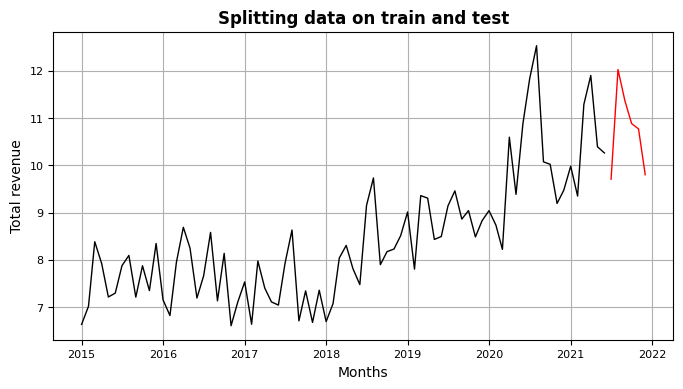

In [ ]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
 
# заголовок и подписи к осям
plt.title('Splitting data on train and test')
plt.ylabel('Total revenue')
plt.xlabel('Months')
 
# добавим сетку
plt.grid()
 
plt.show()

In [ ]:
def f_SARIMAX_total(title_, model_group_):
  plt.title(title_ + ' ' + model_group_)
  plt.plot(train, color = "black")
  plt.plot(test, color = "red")
  plt.grid()
  plt.show()

In [ ]:
def f_SARIMAX_total(train_, test_, model_table_, title_, model_group_):
  # Auto ARIMA
  parameter_search = auto_arima(train_, start_p = 1, start_q = 1, max_p = 3, max_q = 3, m = 12, start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True, error_action ='ignore', suppress_warnings = True,  stepwise = True)           #
    
  print(parameter_search.summary())

  # Training data on the best parameters
  model = SARIMAX(train_, 
                order = parameter_search.order,
                seasonal_order = parameter_search.seasonal_order)

  result = model.fit()
  start = len(train_)
  end = len(train_) + len(test_) - 1
  predictions = result.predict(start, end)

  # Calculating metrics
  MAPE = mean_absolute_percentage_error(test_, predictions)
  MAE = mean_absolute_error(test_, predictions)
  MSE = mean_squared_error(test_, predictions)
  RMSE = np.sqrt(mean_squared_error(test_, predictions))

  # Write metrics into model_table
  model_table_.loc[len(model_table)] = [
    str(title_),# + str(parameter_search.order) + 'x' + str(parameter_search.seasonal_order),
    str(model_group_),
    MAPE,
    MAE,
    MSE,
    RMSE
  ]

  # Plotting
  print('')
  plt.plot(train_, label ='train', color = 'black')
  plt.plot(test_, label ='test', color = 'red')
  plt.plot(predictions, label ='predictions', color = 'blue')

  plt.title(title_ + ' ' + model_group_)
  plt.title(f'Prediction \n MAPE: {MAPE:.3f}, RMSE: {RMSE:.3f}',
          loc='right', fontstyle='italic', fontsize='9', weight='normal')
  plt.ylabel('Revenue')
  plt.xlabel('Months')
  plt.legend()
  plt.grid() 
  plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=138.289, Time=0.49 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=175.118, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=139.270, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=138.251, Time=0.43 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=161.671, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=135.484, Time=0.45 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=136.703, Time=0.13 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=136.822, Time=0.69 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=135.509, Time=0.94 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=133.569, Time=0.54 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=146.137, Time=0.35 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=134.714, Time=1.37 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=135.118, Time=0.57 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=135.582, Time=0.62 sec
 ARIMA(1,1,2)(0,1,2)[12]         

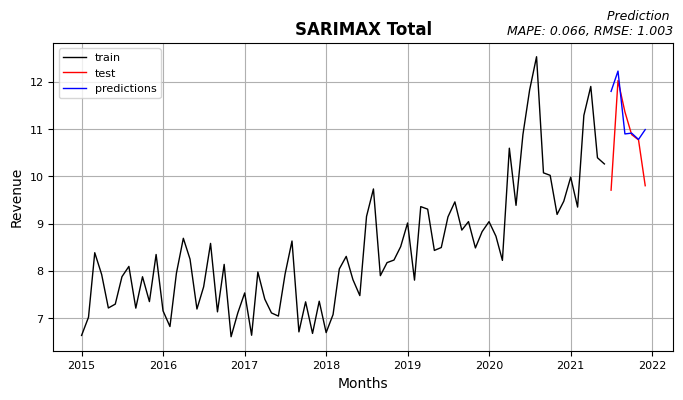

In [ ]:
f_SARIMAX_total(train, test, model_table, 'SARIMAX', 'Total')

For total revenue SARIMAX(0, 1, 1)x(0, 1, [1, 2], 12) shows a good score of MAPE=0.066 and RMSE=1.003. The model includes one moving average, two seasonal moving average with period=12 and sigma2, which represent variance of the residual values. All, except ma.S.L24 is statistically significant on the confidence interval of 95%.

Graph shows that model predicted a new wave with peak in August pretty accurate but was too optimistic for July and late autumn

In [ ]:
model_table

model comment  MAPE   MAE   MSE  RMSE
0  SARIMAX   Total 0.066 0.664 1.005 1.003

## <a name="c4.2">SARIMAX by groups</a>

For revenue by groups we build 4 models. 

In [ ]:
def f_groups(data_col):
  s_names = data_col.sum(axis=1)
  s_data = pd.DataFrame({'date': data_col.index,
                            'revenue':list(s_names)})
  s_data['date'] = s_data['date'].astype('datetime64[M]')
  s_data = s_data.set_index('date')
  
  n_pred = 6
  train_s = s_data[:len(s_data)-n_pred]
  test_s = s_data[len(s_data)-n_pred:]

  return train_s, test_s

In [ ]:
train_s1, test_s1 = f_groups(
    df_new[["Kyanite", "Garnet", "Rhodonite", "Beryl", "Topaz", "Ruby", "Tigereye", "Sapphire"]])
train_s2, test_s2 = f_groups(
    df_new[["Fluorite", "Quartz","Bixbite", "Opal"]])
train_s3, test_s3 = f_groups(
    df_new[["Diamond", "Jade", "Jasper", "Coral", "Amethyst", "Moonstone"]])
train_s4, test_s4 = f_groups(
    df_new[["Bloodstone", "Emerald", "Marble", "Sodalite", "Citrine", "Malachite"]])

In [ ]:
def f_SARIMAX_groups(train_, test_, plot_title_):
  # Auto ARIMA
  parameter_search = auto_arima(train_, start_p = 1, start_q = 1, max_p = 3, max_q = 3, m = 12, start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True, error_action ='ignore', suppress_warnings = True,  stepwise = True)           #
    
  print(parameter_search.summary())

  # Training data on the best parameters
  model = SARIMAX(train_, 
                order = parameter_search.order,
                seasonal_order = parameter_search.seasonal_order)

  result = model.fit()
  start = len(train_)
  end = len(train_) + len(test_) - 1
  predictions = result.predict(start, end)

  # Calculating metrics
  MAPE = mean_absolute_percentage_error(test_, predictions)
  MAE = mean_absolute_error(test_, predictions)
  MSE = mean_squared_error(test_, predictions)
  RMSE = np.sqrt(mean_squared_error(test_, predictions))

  # Plotting
  print('')
  plt.plot(train_, label ='train', color = 'black')
  plt.plot(test_, label ='test', color = 'red')
  plt.plot(predictions, label ='predictions', color = 'blue')

  plt.title(plot_title_)
  plt.title(f'Prediction \n MAPE: {MAPE:.3f}, RMSE: {RMSE:.3f}',
          loc='right', fontstyle='italic', fontsize='9', weight='normal')
  plt.ylabel('Revenue')
  plt.xlabel('Months')
  plt.legend()
  plt.grid() 
  plt.show()

  return predictions

In [ ]:
def f_metrics(test_, predictions):
  MAPE = mean_absolute_percentage_error(test_, predictions)
  MAE = mean_absolute_error(test_, predictions)
  MSE = mean_squared_error(test_, predictions)
  RMSE = np.sqrt(mean_squared_error(test_, predictions))
  return MAPE, MAE, MSE, RMSE

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-32.307, Time=0.60 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-2.525, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-25.700, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-34.268, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-14.431, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-32.702, Time=0.41 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-32.843, Time=0.73 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-29.256, Time=0.20 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.58 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-22.182, Time=0.17 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-32.302, Time=0.45 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-32.285, Time=0.25 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-30.454, Time=0.88 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-33.787, Time=0.54 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12] 

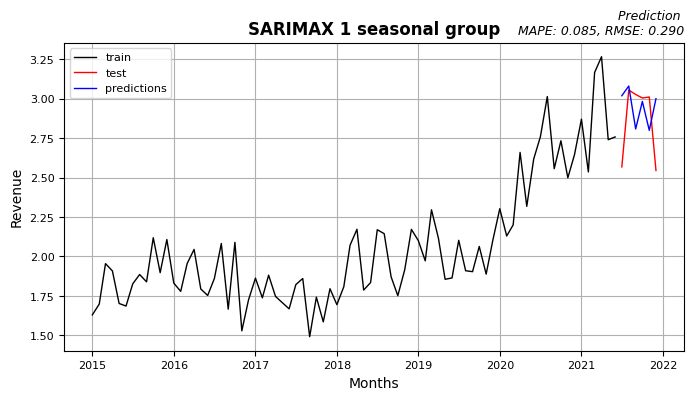

In [ ]:
predictions_s1 = f_SARIMAX_groups(train_s1, test_s1, 'SARIMAX 1 seasonal group')

For group 1 we got score of MAPE=0.085 and  RMSE=0.290 with SARIMAX(0, 1, 1)x(0, 1, 1, 12). All coefficients are statistically significant on the confidence interval of 95%.

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-30.127, Time=0.40 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5.865, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-31.997, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-31.579, Time=0.33 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-5.522, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-31.605, Time=0.57 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=-31.592, Time=0.52 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-29.128, Time=0.29 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-29.619, Time=1.76 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-22.768, Time=0.11 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-30.349, Time=0.30 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-31.581, Time=0.42 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-33.166, Time=0.22 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-10.145, Time=0.06 sec
 ARIMA(0,1,1)(2,1,0)[12]            

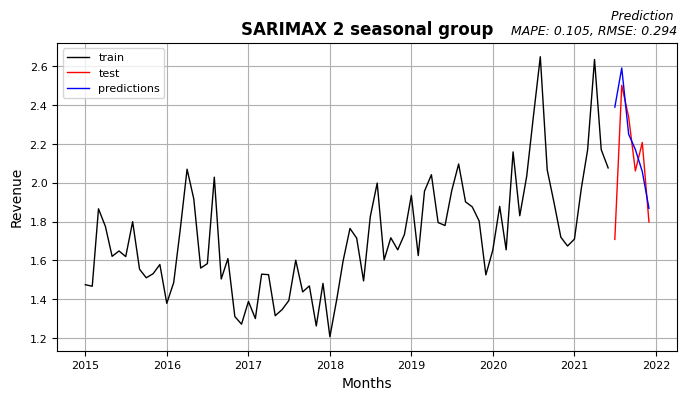

In [ ]:
predictions_s2 = f_SARIMAX_groups(train_s2, test_s2, 'SARIMAX 2 seasonal group')

For group 2 we got score of MAPE=0.105 and  RMSE=0.294 with SARIMAX(0, 1, 1)x(1, 1, [], 12). All coefficients are statistically significant on the confidence interval of 95%.

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=10.305, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-26.653, Time=0.32 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=16.047, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=7.697, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-26.245, Time=0.68 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=-26.988, Time=0.59 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.26 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=-25.658, Time=1.77 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=-25.028, Time=0.95 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=2.34 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=-19.269, Time=0.39 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=-26.314, Time=

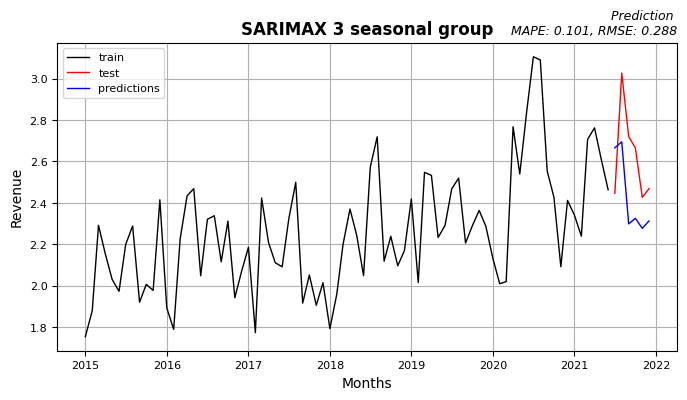

In [ ]:
predictions_s3 = f_SARIMAX_groups(train_s3, test_s3, 'SARIMAX 3 seasonal group')

For group 3 we got score of MAPE=0.101 and  RMSE=0.288 with SARIMAX(1, 0, 0)x(1, 1, [1], 12). All coefficients are statistically significant on the confidence interval of 95%, except ma.S.L24.

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=45.726, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=22.333, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=39.313, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=13.863, Time=0.40 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=15.582, Time=0.78 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=16.562, Time=0.37 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=24.621, Time=0.32 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=14.779, Time=0.56 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=8.724, Time=0.68 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=14.294, Time=0.28 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=10.611, Time=1.11 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=10.271, Time=0.85 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=7.414, Time

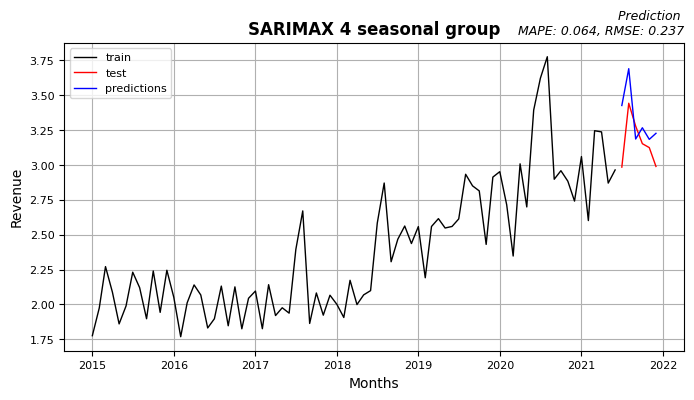

In [ ]:
predictions_s4 = f_SARIMAX_groups(train_s4, test_s4, 'SARIMAX 4 seasonal group')

For group 4 we got score of MAPE=0.064 and  RMSE=0.237 with SARIMAX(0, 1, 1)x(2, 1, [], 12). All coefficients are statistically significant on the confidence interval of 95%, except ma.S.L24.

In [ ]:
predictions_s1234 = predictions_s1 + predictions_s2 + predictions_s3 + predictions_s4
predictions_s1234

2021-07-01   11.500
2021-08-01   12.057
2021-09-01   10.543
2021-10-01   10.747
2021-11-01   10.318
2021-12-01   10.408
Freq: MS, Name: predicted_mean, dtype: float64

In [ ]:
MAPE, MAE, MSE, RMSE = f_metrics(test, predictions_s1234)

In [ ]:
model_table.loc[len(model_table)] = [
    str('SARIMAX by groups'),
    'Total',
    MAPE,
    MAE,
    MSE,
    RMSE
  ]
model_table

model comment  MAPE   MAE   MSE  RMSE
0            SARIMAX   Total 0.066 0.664 1.005 1.003
1  SARIMAX by groups   Total 0.063 0.640 0.747 0.864

When we sum the predictions achieved by the four SARIMAX models and compare it with the test data, we receive scores of MAPE=0.063, RMSE=0.864.

In [ ]:
def f_ts_plot(train_, test_, pred_, plot_title_):
  MAPE, MAE, MSE, RMSE = f_metrics(test_, pred_)

  plt.plot(train_, label ='train', color = 'black')
  plt.plot(test_, label ='test', color = 'red')
  plt.plot(pred_, label ='predictions', color = 'blue')

  plt.title(plot_title_)
  plt.title(f'Prediction \n MAPE: {MAPE:.3f}, RMSE: {RMSE:.3f}',
          loc='right', fontstyle='italic', fontsize='9', weight='normal')
  plt.ylabel('Revenue')
  plt.xlabel('Months')
  plt.legend()
  plt.grid() 
  plt.show()

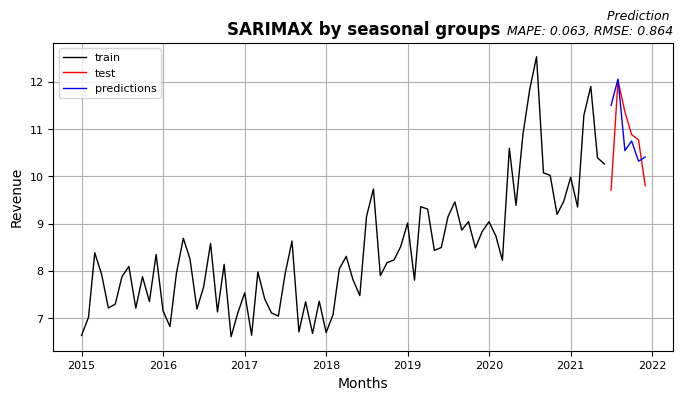

In [ ]:
f_ts_plot(train, test, predictions_s1234, 'SARIMAX by seasonal groups')

The Graph illustrates that the combination of SARIMAX models predict slightly differently from total one. August is predicted pretty accurate, as well as in the precious model, the prediction for October and December is better, but the prediction for July is very optimistic.

## <a name="c4.3">LSTM Univariate</a>

In [ ]:
test_size = 6
train_size = len(df_new_total.reset_index()) - test_size

univariate_df = df_new_total.reset_index()[['date', 'revenue']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_test, y_test = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(x_train), len(x_test))

78 6


In [ ]:
#from sklearn.preprocessing import MinMaxScaler
scaler_1 = MinMaxScaler(feature_range=(-1, 0))
dataset_MMS = univariate_df.filter(['y']).values
scaled_data = scaler_1.fit_transform(dataset_MMS)

In [ ]:
# Defines the rolling window
look_back = 3
# Split into train and test sets
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def f_create_dataset(dataset, look_back):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = f_create_dataset(train, look_back)
x_test, y_test = f_create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

# Setting fixed seed
#tf.keras.backend.clear_session()
tf.random.set_seed(RANDOM_SEED)
#np.random.seed(RANDOM_SEED)

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), seed=RANDOM_SEED))
model.add(Dropout(0.25, seed=RANDOM_SEED))
model.add(LSTM(64, return_sequences=False, seed=RANDOM_SEED))
model.add(Dropout(0.25, seed=RANDOM_SEED))
model.add(Dense(8, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1, activation = "linear"))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=100, validation_data=(x_test, y_test))

model.summary()


Epoch 1/100
72/72 [==============================] - 5s 23ms/step - loss: 0.2635 - val_loss: 0.0527
Epoch 2/100
72/72 [==============================] - 0s 5ms/step - loss: 0.0292 - val_loss: 0.0511
Epoch 3/100
72/72 [==============================] - 0s 5ms/step - loss: 0.0268 - val_loss: 0.0340
Epoch 4/100
72/72 [==============================] - 0s 5ms/step - loss: 0.0311 - val_loss: 0.0383
Epoch 5/100
72/72 [==============================] - 0s 6ms/step - loss: 0.0295 - val_loss: 0.0400
Epoch 6/100
72/72 [==============================] - 0s 5ms/step - loss: 0.0287 - val_loss: 0.0342
Epoch 7/100
72/72 [==============================] - 0s 5ms/step - loss: 0.0266 - val_loss: 0.0389
Epoch 8/100
72/72 [==============================] - 0s 4ms/step - loss: 0.0284 - val_loss: 0.0311
Epoch 9/100
72/72 [==============================] - 0s 5ms/step - loss: 0.0288 - val_loss: 0.0368
Epoch 10/100
72/72 [==============================] - 0s 4ms/step - loss: 0.0265 - val_loss: 0.0352
Epoch 11

In [ ]:
# Predicting with the model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# Inverting predictions
train_predict = scaler_1.inverse_transform(train_predict)
y_train = scaler_1.inverse_transform([y_train])

test_predict = scaler_1.inverse_transform(test_predict)
y_test = scaler_1.inverse_transform([y_test])

# Calculating the metrics
MAPE, MAE, MSE, RMSE = f_metrics(y_test[0], test_predict[:,0])
print('MAPE {:.3f}'.format(MAPE))
print('MAE {:.3f}'.format(MAE))
print('MSE {:.3f}'.format(MSE))
print('RMSE {:.3f}'.format(RMSE))

MAPE 0.065
MAE 0.725
MSE 1.108
RMSE 1.052


For total revenue the best LSTM model we build is the one with LSTM(128), Dropout (0.25), LSTM(64), Dropout (0.25), Dense(8) and Dense(1) on 1 batch size and 100 epochs. For the result we obtain MAPE=0.065, RMSE=1.052.

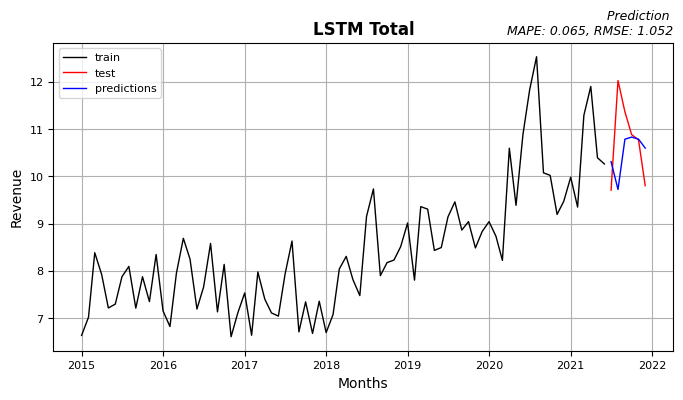

In [ ]:
f_ts_plot(univariate_df.iloc[:train_size, :].set_index('ds')['y'],
          pd.Series(y_test[0], index = univariate_df.iloc[train_size:, :].set_index('ds').index),
          pd.Series(test_predict[:,0], index = univariate_df.iloc[train_size:, :].set_index('ds').index),
          'LSTM Total')

The graph shows that in spite of good score, the model does not resemble trend entirely.

In [ ]:
model_table.loc[len(model_table)] = [
    str('LSTM Univariate'),
    'Total',
    MAPE,
    MAE,
    MSE,
    RMSE
  ]

model_table

model comment  MAPE   MAE   MSE  RMSE
0            SARIMAX   Total 0.066 0.664 1.005 1.003
1  SARIMAX by groups   Total 0.063 0.640 0.747 0.864
2    LSTM Univariate   Total 0.065 0.725 1.108 1.052

## <a name="c4.4">LSTM Multivariate</a>

While doing Multivariate Time Series analysis, we tried several combinations of variables R, E, AC, AD, PC and PD, where 
* R – is revenue
* E – is euro
* AC – all covid new cases in Russia
* AD– all covid new cases in Russia
* PC – all covid new cases in the city
* PC – all covid new cases in the city

We do not worry about high multicollinearity of all variables and very high multicollinearity of COVID variables, since neural networks do not suffer from multicollinearity as they generally become overparameterized


In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
def f_lstm_mult(dataset_):
  # Scalling
  df_scaled = dataset_.copy()

  scaler_1 = MinMaxScaler()
  df_scaled[list(dataset_.columns)] = scaler_1.fit_transform(dataset_[list(dataset_.columns)])

  scaler_2 = MinMaxScaler()
  dataset_MMS = dataset_.reset_index().filter(['revenue']).values
  scaled_data = scaler_2.fit_transform(dataset_MMS)

  df_scaled = df_scaled.reset_index()
  df_scaled = df_scaled.sort_values('date')
  df_scaled = df_scaled.set_index('date')

  # Supervising
  scaled = df_scaled.values
  reframed = series_to_supervised(scaled, 1, 1)
  reframed.drop(reframed.columns[[i for i in range(
      int(dataset_.shape[1] + 1),
      int(series_to_supervised(scaled, 1, 1).shape[1])
  )]], axis=1, inplace=True)

  # Splitting matrix
  values = reframed.values
  train_size = 6
  n_train_days = len(values) - train_size
  train = values[:n_train_days, :]
  test = values[n_train_days:, :]
  # Split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # Reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

  return train_X, test_X, train_y, test_y, scaler_2


def f_lstm_mult_result(test_X_, test_y_, scaler_2_):
  # Lets predict with the model
  pred = model.predict(test_X_)

  # Invert predictions
  # By [1:-1] we get rid off our side added observations
  test_predict = scaler_2_.inverse_transform(pred)#pred[1:-1])
  y_test = scaler_2_.inverse_transform([test_y_])#[1:-1]])

  # Metrics
  MAPE, MAE, MSE, RMSE = f_metrics(y_test[0], test_predict[:,0])
  print('MAPE: {:.3f}'.format(MAPE))
  print('MAE: {:.3f}'.format(MAE))
  print('MSE: {:.3f}'.format(MSE))
  print('RMSE: {:.3f}'.format(RMSE))
  return MAPE, MAE, MSE, RMSE, y_test, test_predict

<h3><b>revenue	+ euro + All_new_cases	+ All_new_deaths	+ P_new_cases	+ P_new_deaths</b></h3>

In [ ]:
train_X, test_X, train_y, test_y, scaler_2 = f_lstm_mult(df_mult)

In [ ]:
tf.random.set_seed(RANDOM_SEED)

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), seed=RANDOM_SEED))
model.add(Dropout(0.25, seed=RANDOM_SEED))
model.add(LSTM(64, return_sequences=False, seed=RANDOM_SEED))
model.add(Dropout(0.25, seed=RANDOM_SEED))
model.add(Dense(8, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1, activation = "linear"))


model.compile(loss='mse', optimizer='adam')
multi_history = model.fit(train_X, train_y, epochs=100,
                                batch_size=4, validation_data=(test_X, test_y),
                                verbose=1, shuffle=False)

Epoch 1/100
20/20 [==============================] - 5s 55ms/step - loss: 0.0817 - val_loss: 0.2212
Epoch 2/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0297 - val_loss: 0.0463
Epoch 3/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0367 - val_loss: 0.0275
Epoch 4/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0350 - val_loss: 0.0257
Epoch 5/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0298 - val_loss: 0.0422
Epoch 6/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0267 - val_loss: 0.0510
Epoch 7/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0245 - val_loss: 0.0508
Epoch 8/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0249 - val_loss: 0.0706
Epoch 9/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0212 - val_loss: 0.0774
Epoch 10/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0241 - val_loss: 0.0503
Epoch 11

In [ ]:
MAPE, MAE, MSE, RMSE, y_test, test_predict = f_lstm_mult_result(test_X, test_y, scaler_2)

MAPE: 0.058
MAE: 0.622
MSE: 0.716
RMSE: 0.846


For model, including all 6 variables the best LSTM model we build is the one with LSTM (128), Dropout (0.25), LSTM (64), Dropout (0.25), Dense (8) and Dense (1) on 4 batch size and 100 epochs. It is very accurate, resulting MAPE=0.058 and RMSE=0.846.

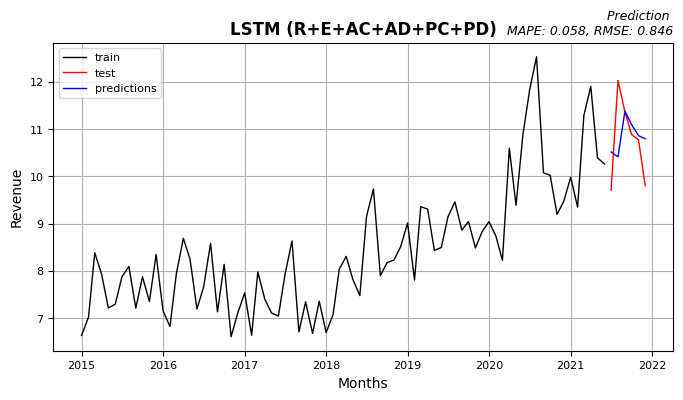

In [ ]:
train_size = len(df_mult) - 6
dataset = df_mult
f_ts_plot(pd.Series(dataset.iloc[:train_size, :1].values[:,0], index = dataset.iloc[:train_size, :1].index),
          pd.Series(y_test[0], index = dataset.iloc[train_size:, :1].index),
          pd.Series(test_predict[:,0], index = dataset.iloc[train_size:, :1].index),
          'LSTM (R+E+AC+AD+PC+PD)')

Graph shows that despite a good score, the model incorrectly predicts the peak in September, while it happens in August. The wave is smaller than it is on the test data.

In [ ]:
model_table.loc[len(model_table)] = [
    str('LSTM Multivariate'),
    str('revenue')+' + '+str('euro')+' + '+str('All_new_cases')+' + '+str('All_new_deaths')+' + '+str('P_new_cases')
    +' + '+str('P_new_deaths'),
    MAPE,
    MAE,
    MSE,
    RMSE
  ]

model_table

model                                            comment  MAPE  \
0            SARIMAX                                              Total 0.066   
1  SARIMAX by groups                                              Total 0.063   
2    LSTM Univariate                                              Total 0.065   
3  LSTM Multivariate  revenue + euro + All_new_cases + All_new_death... 0.058   

    MAE   MSE  RMSE  
0 0.664 1.005 1.003  
1 0.640 0.747 0.864  
2 0.725 1.108 1.052  
3 0.622 0.716 0.846

<h3><b>revenue	+ euro</b></h3>

In [ ]:
train_X, test_X, train_y, test_y, scaler_2 = f_lstm_mult(df_mult[['revenue', 'euro']])

In [ ]:
tf.random.set_seed(RANDOM_SEED)

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), seed=RANDOM_SEED))
model.add(Dropout(0.25, seed=RANDOM_SEED))
model.add(LSTM(256, return_sequences=False, seed=RANDOM_SEED))
model.add(Dropout(0.25, seed=RANDOM_SEED))
model.add(Dense(16, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1, activation = "linear"))


model.compile(loss='mse', optimizer='adam')
multi_history = model.fit(train_X, train_y, epochs=100,
                                batch_size=4, validation_data=(test_X, test_y),
                                verbose=1, shuffle=False)

Epoch 1/100
20/20 [==============================] - 6s 63ms/step - loss: 0.0470 - val_loss: 0.0571
Epoch 2/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0499 - val_loss: 0.0738
Epoch 3/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0372 - val_loss: 0.0626
Epoch 4/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0314 - val_loss: 0.0421
Epoch 5/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0283 - val_loss: 0.0366
Epoch 6/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0236 - val_loss: 0.0304
Epoch 7/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0233 - val_loss: 0.0271
Epoch 8/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0212 - val_loss: 0.0239
Epoch 9/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0239 - val_loss: 0.0249
Epoch 10/100
20/20 [==============================] - 0s 11ms/step - loss: 0.0234 - val_loss: 0.0242


In [ ]:
MAPE, MAE, MSE, RMSE, y_test, test_predict = f_lstm_mult_result(test_X, test_y, scaler_2)

MAPE: 0.056
MAE: 0.630
MSE: 0.918
RMSE: 0.958


For model, including revenue and euro the best LSTM model we build is the one with LSTM (128), Dropout (0.25), LSTM (256), Dropout (0.25), Dense (16) and Dense (1) on 4 batch size and 100 epochs. It is even better accurate, resulting MAPE=0.056 and RMSE=0.958.

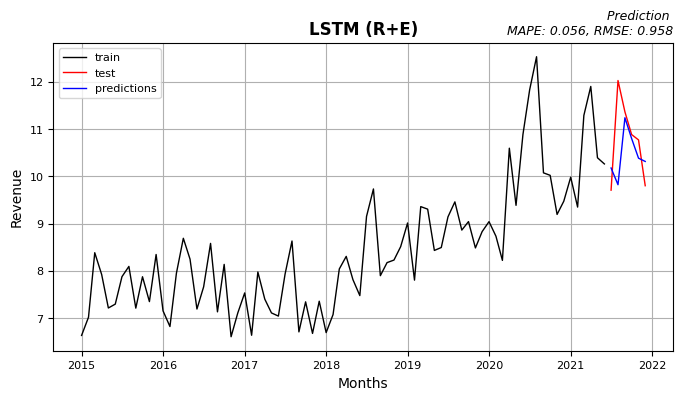

In [ ]:
train_size = len(df_mult) - 6
dataset = df_mult
f_ts_plot(pd.Series(dataset.iloc[:train_size, :1].values[:,0], index = dataset.iloc[:train_size, :1].index),
          pd.Series(y_test[0], index = dataset.iloc[train_size:, :1].index),
          pd.Series(test_predict[:,0], index = dataset.iloc[train_size:, :1].index),
          'LSTM (R+E)')

Graph shows that despite a good score, the model similarly incorrectly predicts the peak in September, while it happens in August, however the wave range resemble quite well the one from the test data.

In [ ]:
model_table.loc[len(model_table)] = [
    str('LSTM Multivariate'),
    str('revenue')+' + '+str('euro'),
    MAPE,
    MAE,
    MSE,
    RMSE
  ]

model_table

model                                            comment  MAPE  \
0            SARIMAX                                              Total 0.066   
1  SARIMAX by groups                                              Total 0.063   
2    LSTM Univariate                                              Total 0.065   
3  LSTM Multivariate  revenue + euro + All_new_cases + All_new_death... 0.058   
4  LSTM Multivariate                                     revenue + euro 0.056   

    MAE   MSE  RMSE  
0 0.664 1.005 1.003  
1 0.640 0.747 0.864  
2 0.725 1.108 1.052  
3 0.622 0.716 0.846  
4 0.630 0.918 0.958

<h3><b>revenue	+ euro + All_new_cases</b></h3>

In [ ]:
df_mult.columns

Index(['revenue', 'euro', 'All_new_cases', 'All_new_deaths', 'P_new_cases',
       'P_new_deaths'],
      dtype='object')

In [ ]:
train_X, test_X, train_y, test_y, scaler_2 = f_lstm_mult(df_mult[['revenue', 'euro', 'All_new_cases']])

In [ ]:
tf.random.set_seed(RANDOM_SEED)

model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), seed=RANDOM_SEED))
model.add(Dropout(0.25, seed=RANDOM_SEED))
model.add(LSTM(128, return_sequences=False, seed=RANDOM_SEED))
model.add(Dropout(0.25, seed=RANDOM_SEED))
model.add(Dense(16, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1, activation = "linear"))


model.compile(loss='mse', optimizer='adam')
multi_history = model.fit(train_X, train_y, epochs=100,
                                batch_size=4, validation_data=(test_X, test_y),
                                verbose=1, shuffle=False)

Epoch 1/100
20/20 [==============================] - 5s 68ms/step - loss: 0.0516 - val_loss: 0.0701
Epoch 2/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0429 - val_loss: 0.0468
Epoch 3/100
20/20 [==============================] - 0s 12ms/step - loss: 0.0345 - val_loss: 0.0362
Epoch 4/100
20/20 [==============================] - 0s 11ms/step - loss: 0.0281 - val_loss: 0.0220
Epoch 5/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0260 - val_loss: 0.0228
Epoch 6/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0217 - val_loss: 0.0252
Epoch 7/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0220 - val_loss: 0.0271
Epoch 8/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0231 - val_loss: 0.0295
Epoch 9/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0229 - val_loss: 0.0278
Epoch 10/100
20/20 [==============================] - 0s 11ms/step - loss: 0.0228 - val_loss: 0.0258

In [ ]:
MAPE, MAE, MSE, RMSE, y_test, test_predict = f_lstm_mult_result(test_X, test_y, scaler_2)

MAPE: 0.067
MAE: 0.727
MSE: 0.903
RMSE: 0.950


For model, including revenue, euro and cases in Russia the best LSTM model we build is the one with LSTM (256), Dropout (0.25), LSTM (128), Dropout (0.25), Dense (16) and Dense (1) on 4 batch size and 100 epochs. It is quite accurate, resulting MAPE=0.067 and RMSE=0.950.

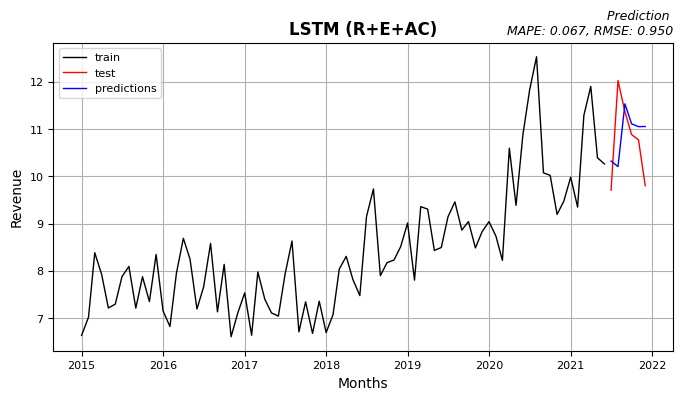

In [ ]:
train_size = len(df_mult) - 6
dataset = df_mult[['revenue', 'euro', 'All_new_cases']]
f_ts_plot(pd.Series(dataset.iloc[:train_size, :1].values[:,0], index = dataset.iloc[:train_size, :1].index),
          pd.Series(y_test[0], index = dataset.iloc[train_size:, :1].index),
          pd.Series(test_predict[:,0], index = dataset.iloc[train_size:, :1].index),
          'LSTM (R+E+AC)')

Graph shows that despite a good score, the model similarly incorrectly predicts the peak in September, while it happens in August. Wave range resemble quite well the one from the test data, but the predictions are unfairly optimistic for December.

In [ ]:
model_table.loc[len(model_table)] = [
    str('LSTM Multivariate'),
    str('revenue')+' + '+str('euro')+' + '+str('All_new_cases'),
    MAPE,
    MAE,
    MSE,
    RMSE
  ]

model_table

model                                            comment  MAPE  \
0            SARIMAX                                              Total 0.066   
1  SARIMAX by groups                                              Total 0.063   
2    LSTM Univariate                                              Total 0.065   
3  LSTM Multivariate  revenue + euro + All_new_cases + All_new_death... 0.058   
4  LSTM Multivariate                                     revenue + euro 0.056   
5  LSTM Multivariate                     revenue + euro + All_new_cases 0.067   

    MAE   MSE  RMSE  
0 0.664 1.005 1.003  
1 0.640 0.747 0.864  
2 0.725 1.108 1.052  
3 0.622 0.716 0.846  
4 0.630 0.918 0.958  
5 0.727 0.903 0.950

<h3><b>revenue + euro + ALL_new_deaths</b></h3>

In [ ]:
train_X, test_X, train_y, test_y, scaler_2 = f_lstm_mult(df_mult[['revenue', 'euro', 'All_new_deaths']])

In [ ]:
tf.random.set_seed(RANDOM_SEED)

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), seed=RANDOM_SEED))
model.add(Dropout(0.25, seed=RANDOM_SEED))
model.add(LSTM(64, return_sequences=False, seed=RANDOM_SEED))
model.add(Dropout(0.25, seed=RANDOM_SEED))
model.add(Dense(8, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1, activation = "linear"))


model.compile(loss='mse', optimizer='adam')
multi_history = model.fit(train_X, train_y, epochs=50,
                                batch_size=4, validation_data=(test_X, test_y),
                                verbose=1, shuffle=False)

Epoch 1/50
20/20 [==============================] - 5s 63ms/step - loss: 0.0813 - val_loss: 0.2216
Epoch 2/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0305 - val_loss: 0.0647
Epoch 3/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0386 - val_loss: 0.0523
Epoch 4/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0372 - val_loss: 0.0451
Epoch 5/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0314 - val_loss: 0.0299
Epoch 6/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0275 - val_loss: 0.0245
Epoch 7/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0246 - val_loss: 0.0230
Epoch 8/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0242 - val_loss: 0.0243
Epoch 9/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0209 - val_loss: 0.0301
Epoch 10/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0238 - val_loss: 0.0257
Epoch 11/50
20/20 

In [ ]:
MAPE, MAE, MSE, RMSE, y_test, test_predict = f_lstm_mult_result(test_X, test_y, scaler_2)

MAPE: 0.079
MAE: 0.848
MSE: 1.039
RMSE: 1.019


For model, including revenue, euro and deaths in Russia the best LSTM model we build is the one with LSTM (128), Dropout (0.25), LSTM (64), Dropout (0.25), Dense (8) and Dense (1) on 4 batch size and 50 epochs. It is quite accurate, resulting MAPE=0.079 and RMSE=1.019.

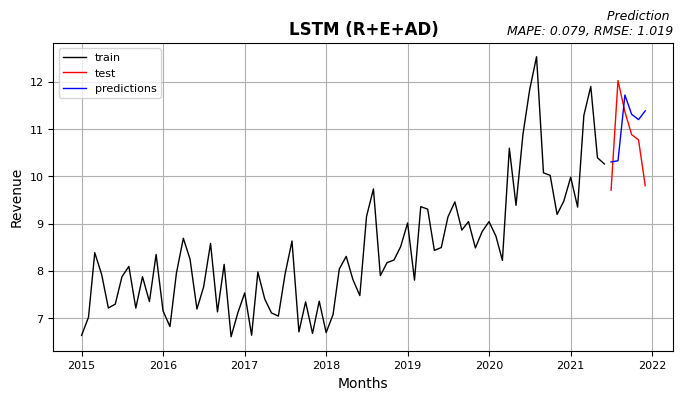

In [ ]:
train_size = len(df_mult) - 6
dataset = df_mult[['revenue', 'euro', 'All_new_deaths']]
f_ts_plot(pd.Series(dataset.iloc[:train_size, :1].values[:,0], index = dataset.iloc[:train_size, :1].index),
          pd.Series(y_test[0], index = dataset.iloc[train_size:, :1].index),
          pd.Series(test_predict[:,0], index = dataset.iloc[train_size:, :1].index),
          'LSTM (R+E+AD)')

Graph shows that despite a good score, the model similarly incorrectly predicts the peak in September, while it happens in August. Predictions are fine for July, but unfairly optimistic for November and December.

In [ ]:
model_table.loc[len(model_table)] = [
    str('LSTM Multivariate'),
    str('revenue')+' + '+str('euro')+' + '+str('All_new_deaths'),
    MAPE,
    MAE,
    MSE,
    RMSE
  ]

model_table

model                                            comment  MAPE  \
0            SARIMAX                                              Total 0.066   
1  SARIMAX by groups                                              Total 0.063   
2    LSTM Univariate                                              Total 0.065   
3  LSTM Multivariate  revenue + euro + All_new_cases + All_new_death... 0.058   
4  LSTM Multivariate                                     revenue + euro 0.056   
5  LSTM Multivariate                     revenue + euro + All_new_cases 0.067   
6  LSTM Multivariate                    revenue + euro + All_new_deaths 0.079   

    MAE   MSE  RMSE  
0 0.664 1.005 1.003  
1 0.640 0.747 0.864  
2 0.725 1.108 1.052  
3 0.622 0.716 0.846  
4 0.630 0.918 0.958  
5 0.727 0.903 0.950  
6 0.848 1.039 1.019

<h3><b>revenue + euro + P_new_cases</b></h3>

In [ ]:
train_X, test_X, train_y, test_y, scaler_2 = f_lstm_mult(df_mult[['revenue', 'euro', 'P_new_cases']])

In [ ]:
tf.random.set_seed(RANDOM_SEED)

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), seed=RANDOM_SEED))
model.add(Dropout(0.2, seed=RANDOM_SEED))
model.add(LSTM(128, return_sequences=False, seed=RANDOM_SEED))
model.add(Dropout(0.2, seed=RANDOM_SEED))
model.add(Dense(16, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1, activation = "linear"))


model.compile(loss='mse', optimizer='adam')
multi_history = model.fit(train_X, train_y, epochs=50,
                                batch_size=4, validation_data=(test_X, test_y),
                                verbose=1, shuffle=False)

Epoch 1/50
20/20 [==============================] - 7s 72ms/step - loss: 0.0627 - val_loss: 0.1230
Epoch 2/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0386 - val_loss: 0.0527
Epoch 3/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0410 - val_loss: 0.0516
Epoch 4/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0338 - val_loss: 0.0299
Epoch 5/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0289 - val_loss: 0.0236
Epoch 6/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0239 - val_loss: 0.0232
Epoch 7/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0230 - val_loss: 0.0255
Epoch 8/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0239 - val_loss: 0.0380
Epoch 9/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0220 - val_loss: 0.0390
Epoch 10/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0220 - val_loss: 0.0360
Epoch 11/50
20/20

In [ ]:
MAPE, MAE, MSE, RMSE, y_test, test_predict = f_lstm_mult_result(test_X, test_y, scaler_2)

MAPE: 0.098
MAE: 1.055
MSE: 1.354
RMSE: 1.163


For model, including revenue, euro and cases in the city the best LSTM model we build is the one with LSTM (128), Dropout (0.2), LSTM (128), Dropout (0.2), Dense (16) and Dense (1) on 4 batch size and 50 epochs. It is not very accurate, resulting MAPE=0.098 and RMSE=1.163.

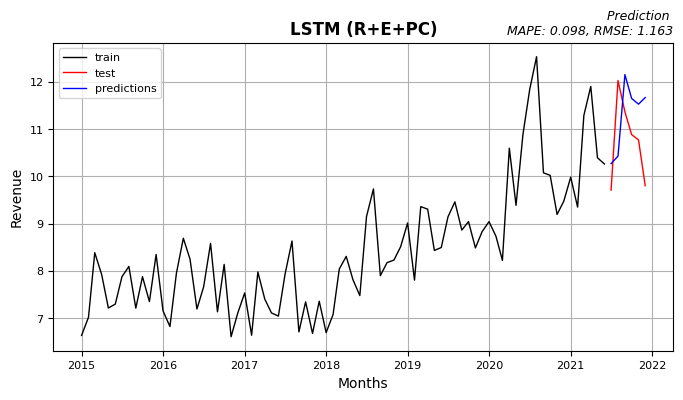

In [ ]:
train_size = len(df_mult) - 6
dataset = df_mult[['revenue', 'euro', 'P_new_cases']]
f_ts_plot(pd.Series(dataset.iloc[:train_size, :1].values[:,0], index = dataset.iloc[:train_size, :1].index),
          pd.Series(y_test[0], index = dataset.iloc[train_size:, :1].index),
          pd.Series(test_predict[:,0], index = dataset.iloc[train_size:, :1].index),
          'LSTM (R+E+PC)')

Graph shows the model similarly incorrectly predicts the peak in September, while it happens in August. Wave range resemble very well the one from the test data, but the predictions are unfairly optimistic for November and December.

In [ ]:
model_table.loc[len(model_table)] = [
    str('LSTM Multivariate'),
    str('revenue')+' + '+str('euro')+' + '+str('P_new_cases'),
    MAPE,
    MAE,
    MSE,
    RMSE
  ]

model_table

model                                            comment  MAPE  \
0            SARIMAX                                              Total 0.066   
1  SARIMAX by groups                                              Total 0.063   
2    LSTM Univariate                                              Total 0.065   
3  LSTM Multivariate  revenue + euro + All_new_cases + All_new_death... 0.058   
4  LSTM Multivariate                                     revenue + euro 0.056   
5  LSTM Multivariate                     revenue + euro + All_new_cases 0.067   
6  LSTM Multivariate                    revenue + euro + All_new_deaths 0.079   
7  LSTM Multivariate                       revenue + euro + P_new_cases 0.098   

    MAE   MSE  RMSE  
0 0.664 1.005 1.003  
1 0.640 0.747 0.864  
2 0.725 1.108 1.052  
3 0.622 0.716 0.846  
4 0.630 0.918 0.958  
5 0.727 0.903 0.950  
6 0.848 1.039 1.019  
7 1.055 1.354 1.163

<h3><b>revenue + euro + P_new_deaths</b></h3>

In [ ]:
train_X, test_X, train_y, test_y, scaler_2 = f_lstm_mult(df_mult[['revenue', 'euro', 'P_new_deaths']])

In [ ]:
tf.random.set_seed(RANDOM_SEED)

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), seed=RANDOM_SEED))
model.add(Dropout(0.25, seed=RANDOM_SEED))
model.add(LSTM(128, return_sequences=False, seed=RANDOM_SEED))
model.add(Dropout(0.25, seed=RANDOM_SEED))
model.add(Dense(16, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1, activation = "linear"))


model.compile(loss='mse', optimizer='adam')
multi_history = model.fit(train_X, train_y, epochs=50,
                                batch_size=4, validation_data=(test_X, test_y),
                                verbose=1, shuffle=False)

Epoch 1/50
20/20 [==============================] - 5s 57ms/step - loss: 0.0706 - val_loss: 0.1748
Epoch 2/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0345 - val_loss: 0.0618
Epoch 3/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0423 - val_loss: 0.0609
Epoch 4/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0368 - val_loss: 0.0435
Epoch 5/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0321 - val_loss: 0.0304
Epoch 6/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0268 - val_loss: 0.0251
Epoch 7/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0263 - val_loss: 0.0259
Epoch 8/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0257 - val_loss: 0.0338
Epoch 9/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0231 - val_loss: 0.0434
Epoch 10/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0225 - val_loss: 0.0324
Epoch 11/50
20/

In [ ]:
MAPE, MAE, MSE, RMSE, y_test, test_predict = f_lstm_mult_result(test_X, test_y, scaler_2)

MAPE: 0.088
MAE: 0.950
MSE: 1.184
RMSE: 1.088


For model, including revenue, euro and deaths in the city the best LSTM model we build is the one with LSTM (64), Dropout (0.25), LSTM (128), Dropout (0.25), Dense (16) and Dense (1) on 4 batch size and 50 epochs. It is not very accurate, resulting MAPE=0.098 and RMSE=1.163.

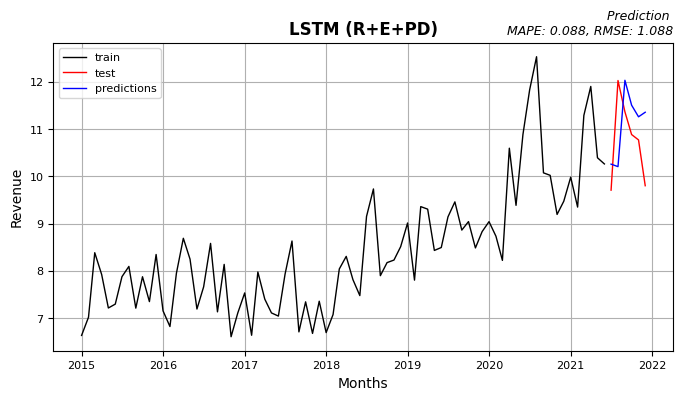

In [ ]:
train_size = len(df_mult) - 6
dataset = df_mult[['revenue', 'euro', 'P_new_deaths']]
f_ts_plot(pd.Series(dataset.iloc[:train_size, :1].values[:,0], index = dataset.iloc[:train_size, :1].index),
          pd.Series(y_test[0], index = dataset.iloc[train_size:, :1].index),
          pd.Series(test_predict[:,0], index = dataset.iloc[train_size:, :1].index),
          'LSTM (R+E+PD)')

Graph shows the model similarly incorrectly predicts the peak in September, while it happens in August. Wave range resemble very well the one from the test data, but the predictions are unfairly optimistic for November and December.

In [ ]:
model_table.loc[len(model_table)] = [
    str('LSTM Multivariate'),
    str('revenue')+' + '+str('euro')+' + '+str('P_new_deaths'),
    MAPE,
    MAE,
    MSE,
    RMSE
  ]

model_table

model                                            comment  MAPE  \
0            SARIMAX                                              Total 0.066   
1  SARIMAX by groups                                              Total 0.063   
2    LSTM Univariate                                              Total 0.065   
3  LSTM Multivariate  revenue + euro + All_new_cases + All_new_death... 0.058   
4  LSTM Multivariate                                     revenue + euro 0.056   
5  LSTM Multivariate                     revenue + euro + All_new_cases 0.067   
6  LSTM Multivariate                    revenue + euro + All_new_deaths 0.079   
7  LSTM Multivariate                       revenue + euro + P_new_cases 0.098   
8  LSTM Multivariate                      revenue + euro + P_new_deaths 0.088   

    MAE   MSE  RMSE  
0 0.664 1.005 1.003  
1 0.640 0.747 0.864  
2 0.725 1.108 1.052  
3 0.622 0.716 0.846  
4 0.630 0.918 0.958  
5 0.727 0.903 0.950  
6 0.848 1.039 1.019  
7 1.055 1.354 1.163  
8 0.950 1.184 1.088

<h3><b>revenue + P_new_deaths</b></h3>

In [ ]:
train_X, test_X, train_y, test_y, scaler_2 = f_lstm_mult(df_mult[['revenue', 'P_new_deaths']])

In [ ]:
tf.random.set_seed(RANDOM_SEED)

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), seed=RANDOM_SEED))
model.add(Dropout(0.2, seed=RANDOM_SEED))
model.add(LSTM(128, return_sequences=False, seed=RANDOM_SEED))
model.add(Dropout(0.2, seed=RANDOM_SEED))
model.add(Dense(8, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1, activation = "linear"))


model.compile(loss='mse', optimizer='adam')
multi_history = model.fit(train_X, train_y, epochs=50,
                                batch_size=4, validation_data=(test_X, test_y),
                                verbose=1, shuffle=False)

Epoch 1/50
20/20 [==============================] - 5s 59ms/step - loss: 0.0681 - val_loss: 0.1497
Epoch 2/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0334 - val_loss: 0.0512
Epoch 3/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0402 - val_loss: 0.0474
Epoch 4/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0315 - val_loss: 0.0318
Epoch 5/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0279 - val_loss: 0.0350
Epoch 6/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0224 - val_loss: 0.0519
Epoch 7/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0220 - val_loss: 0.0675
Epoch 8/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0223 - val_loss: 0.1057
Epoch 9/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0213 - val_loss: 0.1152
Epoch 10/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0216 - val_loss: 0.1081
Epoch 11/50
20/20 

In [ ]:
MAPE, MAE, MSE, RMSE, y_test, test_predict = f_lstm_mult_result(test_X, test_y, scaler_2)

MAPE: 0.175
MAE: 1.863
MSE: 4.076
RMSE: 2.019


For model, including revenue and deaths in the city the best LSTM model we build is the one with LSTM (128), Dropout (0.2), LSTM (128), Dropout (0.2), Dense (8) and Dense (1) on 4 batch size and 100 epochs. It is not accurate, resulting MAPE=0.175 and RMSE=2.019.

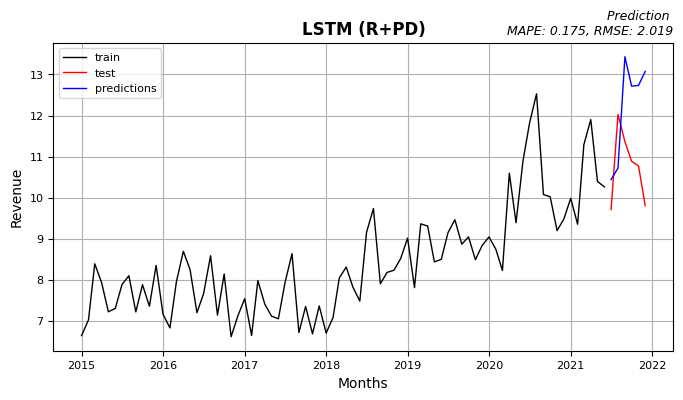

In [ ]:
train_size = len(df_mult) - 6
dataset = df_mult[['revenue', 'P_new_deaths']]
f_ts_plot(pd.Series(dataset.iloc[:train_size, :1].values[:,0], index = dataset.iloc[:train_size, :1].index),
          pd.Series(y_test[0], index = dataset.iloc[train_size:, :1].index),
          pd.Series(test_predict[:,0], index = dataset.iloc[train_size:, :1].index),
          'LSTM (R+PD)')

The graph shows that the model does not resemble trend entirely, predictions for September-December are highly optimistic.

In [ ]:
model_table.loc[len(model_table)] = [
    str('LSTM Multivariate'),
    str('revenue')+' + '+str('P_new_deaths'),
    MAPE,
    MAE,
    MSE,
    RMSE
  ]

model_table

model                                            comment  MAPE  \
0            SARIMAX                                              Total 0.066   
1  SARIMAX by groups                                              Total 0.063   
2    LSTM Univariate                                              Total 0.065   
3  LSTM Multivariate  revenue + euro + All_new_cases + All_new_death... 0.058   
4  LSTM Multivariate                                     revenue + euro 0.056   
5  LSTM Multivariate                     revenue + euro + All_new_cases 0.067   
6  LSTM Multivariate                    revenue + euro + All_new_deaths 0.079   
7  LSTM Multivariate                       revenue + euro + P_new_cases 0.098   
8  LSTM Multivariate                      revenue + euro + P_new_deaths 0.088   
9  LSTM Multivariate                             revenue + P_new_deaths 0.175   

    MAE   MSE  RMSE  
0 0.664 1.005 1.003  
1 0.640 0.747 0.864  
2 0.725 1.108 1.052  
3 0.622 0.716 0.846  
4 0.630 0.918 0.958  
5 0.727 0.903 0.950  
6 0.848 1.039 1.019  
7 1.055 1.354 1.163  
8 0.950 1.184 1.088  
9 1.863 4.076 2.019

## <a name="c4.5">LSTM Multivariate by groups</a>

Further we do Multivariate LSTM by groups, by testing combinations R+E and R+E+AC+AD+PC+PD separately for store units, and then summing the predicions.

In [ ]:
def f_groups_2(data_col):
  s_names = data_col.sum(axis=1)
  s_data = pd.DataFrame({'date': data_col.index,
                            'revenue':list(s_names)})
  s_data['date'] = s_data['date'].astype('datetime64[M]')
  s_data = s_data.set_index('date')
  s_data = pd.concat([s_data, df_covid], axis=1)

  n_pred = 6
  train_s = s_data[:len(s_data)-n_pred]
  test_s = s_data[len(s_data)-n_pred:]

  return train_s, test_s, s_data

In [ ]:
train_s1, test_s1, data_s1 = f_groups_2(
    df_new[["Kyanite", "Garnet", "Rhodonite", "Beryl", "Topaz", "Ruby", "Tigereye", "Sapphire"]])
train_s2, test_s2, data_s2 = f_groups_2(
    df_new[["Fluorite", "Quartz","Bixbite", "Opal"]])
train_s3, test_s3, data_s3 = f_groups_2(
    df_new[["Diamond", "Jade", "Jasper", "Coral", "Amethyst", "Moonstone"]])
train_s4, test_s4, data_s4 = f_groups_2(
    df_new[["Bloodstone", "Emerald", "Marble", "Sodalite", "Citrine", "Malachite"]])

<h3><b>revenue	+ euro + All_new_cases	+ All_new_deaths	+ P_new_cases	+ P_new_deaths</b></h3>

In [ ]:
train_X, test_X, train_y, test_y, scaler_2 = f_lstm_mult(data_s1)

In [ ]:
tf.random.set_seed(RANDOM_SEED)

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), seed=RANDOM_SEED))
model.add(Dropout(0.2, seed=RANDOM_SEED))
model.add(LSTM(128, return_sequences=False, seed=RANDOM_SEED))
model.add(Dropout(0.2, seed=RANDOM_SEED))
model.add(Dense(8, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1, activation = "linear"))


model.compile(loss='mse', optimizer='adam')
multi_history = model.fit(train_X, train_y, epochs=50,
                                batch_size=4, validation_data=(test_X, test_y),
                                verbose=1, shuffle=False)

Epoch 1/50
20/20 [==============================] - 7s 56ms/step - loss: 0.0616 - val_loss: 0.1644
Epoch 2/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0324 - val_loss: 0.0426
Epoch 3/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0334 - val_loss: 0.0248
Epoch 4/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0213 - val_loss: 0.0459
Epoch 5/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0180 - val_loss: 0.0787
Epoch 6/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0152 - val_loss: 0.0835
Epoch 7/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0176 - val_loss: 0.0499
Epoch 8/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0177 - val_loss: 0.1094
Epoch 9/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0158 - val_loss: 0.0982
Epoch 10/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0155 - val_loss: 0.0932
Epoch 11/50
20/20 

In [ ]:
MAPE, MAE, MSE, RMSE, y_test_s1, test_predict_s1 = f_lstm_mult_result(test_X, test_y, scaler_2)

MAPE: 0.075
MAE: 0.202
MSE: 0.082
RMSE: 0.286


For the first group the best LSTM model we build is the one with LSTM (128), Dropout (0.2), LSTM (128), Dropout (0.2), Dense (8) and Dense (1) on 4 batch size and 50 epochs. It is very accurate, resulting MAPE=0.075 and RMSE=0.286.

In [ ]:
train_X, test_X, train_y, test_y, scaler_2 = f_lstm_mult(data_s2)

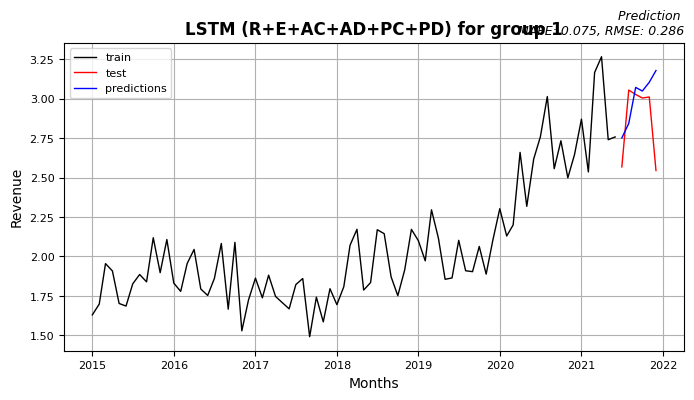

In [ ]:
f_ts_plot(train_s1['revenue'],
          test_s1['revenue'],
          pd.Series(test_predict_s1[:,0], index = test_s1['revenue'].index),
          'LSTM (R+E+AC+AD+PC+PD) for group 1')

In [ ]:
tf.random.set_seed(RANDOM_SEED)

model = Sequential()
model.add(LSTM(200, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), seed=RANDOM_SEED))
model.add(Dropout(0.2, seed=RANDOM_SEED))
model.add(LSTM(200, return_sequences=False, seed=RANDOM_SEED))
model.add(Dropout(0.2, seed=RANDOM_SEED))
model.add(Dense(8, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1, activation = "linear"))


model.compile(loss='mse', optimizer='adam')
multi_history = model.fit(train_X, train_y, epochs=50,
                                batch_size=4, validation_data=(test_X, test_y),
                                verbose=1, shuffle=False)

Epoch 1/50
20/20 [==============================] - 6s 71ms/step - loss: 0.0611 - val_loss: 0.0420
Epoch 2/50
20/20 [==============================] - 0s 12ms/step - loss: 0.0410 - val_loss: 0.0429
Epoch 3/50
20/20 [==============================] - 0s 13ms/step - loss: 0.0258 - val_loss: 0.0487
Epoch 4/50
20/20 [==============================] - 0s 13ms/step - loss: 0.0264 - val_loss: 0.0558
Epoch 5/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0258 - val_loss: 0.0678
Epoch 6/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0235 - val_loss: 0.0598
Epoch 7/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0247 - val_loss: 0.0595
Epoch 8/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0237 - val_loss: 0.0614
Epoch 9/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0219 - val_loss: 0.0668
Epoch 10/50
20/20 [==============================] - 0s 12ms/step - loss: 0.0196 - val_loss: 0.0666
Epoch 11/

In [ ]:
MAPE, MAE, MSE, RMSE, y_test_s2, test_predict_s2 = f_lstm_mult_result(test_X, test_y, scaler_2)

MAPE: 0.139
MAE: 0.282
MSE: 0.117
RMSE: 0.342


For the second group the best LSTM model we build is the one with LSTM (200), Dropout (0.2), LSTM (200) Dropout (0.2), Dense (8) and Dense (1) on 4 batch size and 50 epochs. It is very accurate, resulting MAPE=0.139 and RMSE=0.342.

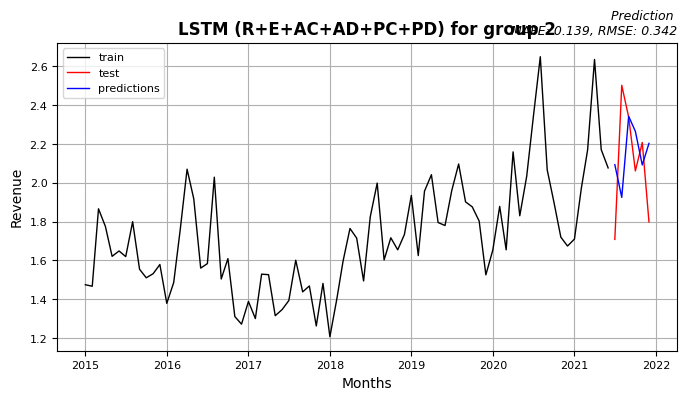

In [ ]:
f_ts_plot(train_s2['revenue'],
          test_s2['revenue'],
          pd.Series(test_predict_s2[:,0], index = test_s2['revenue'].index),
          'LSTM (R+E+AC+AD+PC+PD) for group 2')

In [ ]:
train_X, test_X, train_y, test_y, scaler_2 = f_lstm_mult(data_s3)

In [ ]:
tf.random.set_seed(RANDOM_SEED)

model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), seed=RANDOM_SEED))
model.add(Dropout(0.25, seed=RANDOM_SEED))
model.add(LSTM(256, return_sequences=False, seed=RANDOM_SEED))
model.add(Dropout(0.25, seed=RANDOM_SEED))
model.add(Dense(8, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1, activation = "linear"))


model.compile(loss='mse', optimizer='adam')
multi_history = model.fit(train_X, train_y, epochs=50,
                                batch_size=4, validation_data=(test_X, test_y),
                                verbose=1, shuffle=False)

Epoch 1/50
20/20 [==============================] - 6s 63ms/step - loss: 0.0659 - val_loss: 0.0225
Epoch 2/50
20/20 [==============================] - 0s 14ms/step - loss: 0.0441 - val_loss: 0.0356
Epoch 3/50
20/20 [==============================] - 0s 13ms/step - loss: 0.0331 - val_loss: 0.0258
Epoch 4/50
20/20 [==============================] - 0s 16ms/step - loss: 0.0338 - val_loss: 0.0260
Epoch 5/50
20/20 [==============================] - 0s 16ms/step - loss: 0.0341 - val_loss: 0.0261
Epoch 6/50
20/20 [==============================] - 0s 17ms/step - loss: 0.0329 - val_loss: 0.0274
Epoch 7/50
20/20 [==============================] - 0s 18ms/step - loss: 0.0337 - val_loss: 0.0266
Epoch 8/50
20/20 [==============================] - 0s 16ms/step - loss: 0.0316 - val_loss: 0.0257
Epoch 9/50
20/20 [==============================] - 0s 17ms/step - loss: 0.0346 - val_loss: 0.0270
Epoch 10/50
20/20 [==============================] - 0s 14ms/step - loss: 0.0326 - val_loss: 0.0256
Epoch 11/

In [ ]:
MAPE, MAE, MSE, RMSE, y_test_s3, test_predict_s3 = f_lstm_mult_result(test_X, test_y, scaler_2)

MAPE: 0.061
MAE: 0.171
MSE: 0.057
RMSE: 0.239


For the third group the best LSTM model we build is the one with LSTM (256), Dropout (0.25), LSTM (256) Dropout (0.25), Dense (8) and Dense (1) on 4 batch size and 50 epochs. It is very accurate, resulting MAPE=0.061 and RMSE=0.239.

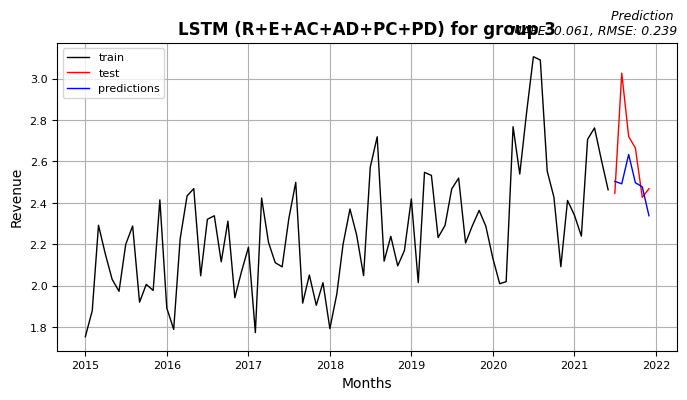

In [ ]:
f_ts_plot(train_s3['revenue'],
          test_s3['revenue'],
          pd.Series(test_predict_s3[:,0], index = test_s3['revenue'].index),
          'LSTM (R+E+AC+AD+PC+PD) for group 3')

In [ ]:
train_X, test_X, train_y, test_y, scaler_2 = f_lstm_mult(data_s4)

In [ ]:
tf.random.set_seed(RANDOM_SEED)

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), seed=RANDOM_SEED))
model.add(Dropout(0.25, seed=RANDOM_SEED))
model.add(LSTM(64, return_sequences=False, seed=RANDOM_SEED))
model.add(Dropout(0.25, seed=RANDOM_SEED))
model.add(Dense(8, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1, activation = "linear"))


model.compile(loss='mse', optimizer='adam')
multi_history = model.fit(train_X, train_y, epochs=100,
                                batch_size=4, validation_data=(test_X, test_y),
                                verbose=1, shuffle=False)

Epoch 1/100
20/20 [==============================] - 6s 88ms/step - loss: 0.0856 - val_loss: 0.2052
Epoch 2/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0338 - val_loss: 0.0314
Epoch 3/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0414 - val_loss: 0.0128
Epoch 4/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0411 - val_loss: 0.0120
Epoch 5/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0338 - val_loss: 0.0230
Epoch 6/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0305 - val_loss: 0.0293
Epoch 7/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0281 - val_loss: 0.0271
Epoch 8/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0273 - val_loss: 0.0410
Epoch 9/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0233 - val_loss: 0.0457
Epoch 10/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0265 - val_loss: 0.0280
Epoch 11

In [ ]:
MAPE, MAE, MSE, RMSE, y_test_s4, test_predict_s4 = f_lstm_mult_result(test_X, test_y, scaler_2)

MAPE: 0.037
MAE: 0.121
MSE: 0.031
RMSE: 0.176


For the four group the best LSTM model we build is the one with LSTM (128), Dropout (0.25), LSTM (64) Dropout (0.25), Dense (8) and Dense (1) on 4 batch size and 100 epochs. It is very accurate, resulting MAPE=0.037 and RMSE=0.176.

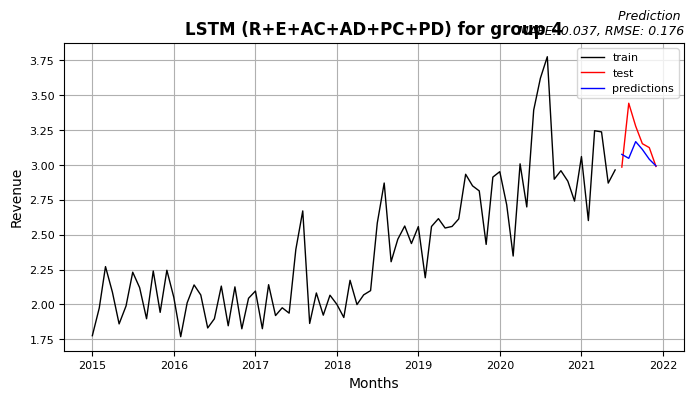

In [ ]:
f_ts_plot(train_s4['revenue'],
          test_s4['revenue'],
          pd.Series(test_predict_s4[:,0], index = test_s4['revenue'].index),
          'LSTM (R+E+AC+AD+PC+PD) for group 4')

In [ ]:
test_predict_s1234 = test_predict_s1 + test_predict_s2 + test_predict_s3 + test_predict_s4
y_test_s1234 = y_test_s1[0] + y_test_s2[0] + y_test_s3[0] + y_test_s4[0]
MAPE, MAE, MSE, RMSE = f_metrics(y_test_s1234, test_predict_s1234)

print('MAPE {:.3f}'.format(MAPE))
print('MAE {:.3f}'.format(MAE))
print('MSE {:.3f}'.format(MSE))
print('RMSE {:.3f}'.format(RMSE))

MAPE 0.055
MAE 0.598
MSE 0.721
RMSE 0.849


After combining models and summing their predictions we obtain scores of MAPE=0.055 and RMSE=0.849.

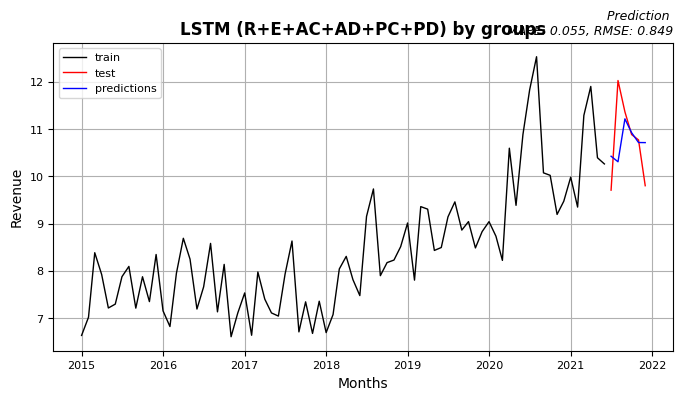

In [ ]:
f_ts_plot(df_mult['revenue'][:train_size],
          df_mult['revenue'][train_size:],
          pd.Series(test_predict_s1234[:,0], index = df_mult['revenue'][train_size:].index),
          'LSTM (R+E+AC+AD+PC+PD) by groups')

Graph shows despite a good score the model similarly incorrectly predicts the peak in September, while it happens in August. Wave is much smaller than the one on the test data, however predictions are pessimistically precise for July, November and December.

In [ ]:
model_table.loc[len(model_table)] = [
    str('LSTM Multivariate by groups'),
    str('revenue')+' + '+str('euro')+' + '+str('All_new_cases')+' + '+str('All_new_deaths')+' + '+str('P_new_cases')
    +' + '+str('P_new_deaths'),
    MAPE,
    MAE,
    MSE,
    RMSE
  ]

model_table

model  \
0                       SARIMAX   
1             SARIMAX by groups   
2               LSTM Univariate   
3             LSTM Multivariate   
4             LSTM Multivariate   
5             LSTM Multivariate   
6             LSTM Multivariate   
7             LSTM Multivariate   
8             LSTM Multivariate   
9             LSTM Multivariate   
10  LSTM Multivariate by groups   

                                              comment  MAPE   MAE   MSE  RMSE  
0                                               Total 0.066 0.664 1.005 1.003  
1                                               Total 0.063 0.640 0.747 0.864  
2                                               Total 0.065 0.725 1.108 1.052  
3   revenue + euro + All_new_cases + All_new_death... 0.058 0.622 0.716 0.846  
4                                      revenue + euro 0.056 0.630 0.918 0.958  
5                      revenue + euro + All_new_cases 0.067 0.727 0.903 0.950  
6                     revenue + euro + All_new_deaths 0.079 0.848 1.039 1.019  
7                        revenue + euro + P_new_cases 0.098 1.055 1.354 1.163  
8                       revenue + euro + P_new_deaths 0.088 0.950 1.184 1.088  
9                              revenue + P_new_deaths 0.175 1.863 4.076 2.019  
10  revenue + euro + All_new_cases + All_new_death... 0.055 0.598 0.721 0.849

<h3><b>revenue + euro </b></h3>

In [ ]:
data_s1 = data_s1[['revenue', 'euro']]
train_X, test_X, train_y, test_y, scaler_2 = f_lstm_mult(data_s1)

In [ ]:
tf.random.set_seed(RANDOM_SEED)

model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), seed=RANDOM_SEED))
model.add(Dropout(0.2, seed=RANDOM_SEED))
model.add(LSTM(256, return_sequences=False, seed=RANDOM_SEED))
model.add(Dropout(0.2, seed=RANDOM_SEED))
model.add(Dense(8, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1, activation = "linear"))


model.compile(loss='mse', optimizer='adam')
multi_history = model.fit(train_X, train_y, epochs=100,
                                batch_size=4, validation_data=(test_X, test_y),
                                verbose=1, shuffle=False)

Epoch 1/100
20/20 [==============================] - 6s 66ms/step - loss: 0.0252 - val_loss: 0.0152
Epoch 2/100
20/20 [==============================] - 0s 15ms/step - loss: 0.0652 - val_loss: 0.1402
Epoch 3/100
20/20 [==============================] - 0s 15ms/step - loss: 0.0230 - val_loss: 0.0456
Epoch 4/100
20/20 [==============================] - 0s 14ms/step - loss: 0.0265 - val_loss: 0.0419
Epoch 5/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0203 - val_loss: 0.0261
Epoch 6/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0175 - val_loss: 0.0223
Epoch 7/100
20/20 [==============================] - 0s 16ms/step - loss: 0.0164 - val_loss: 0.0195
Epoch 8/100
20/20 [==============================] - 0s 16ms/step - loss: 0.0167 - val_loss: 0.0203
Epoch 9/100
20/20 [==============================] - 0s 18ms/step - loss: 0.0183 - val_loss: 0.0196
Epoch 10/100
20/20 [==============================] - 0s 14ms/step - loss: 0.0183 - val_loss: 0.0189

In [ ]:
MAPE, MAE, MSE, RMSE, y_test_s1, test_predict_s1 = f_lstm_mult_result(test_X, test_y, scaler_2)

MAPE: 0.078
MAE: 0.225
MSE: 0.065
RMSE: 0.256


For the first group the best LSTM model we build is the one with LSTM (256), Dropout (0.2), LSTM (256), Dropout (0.2), Dense (8) and Dense (1) on 4 batch size and 100 epochs. It is very accurate, resulting MAPE=0.078 and RMSE=0.256.

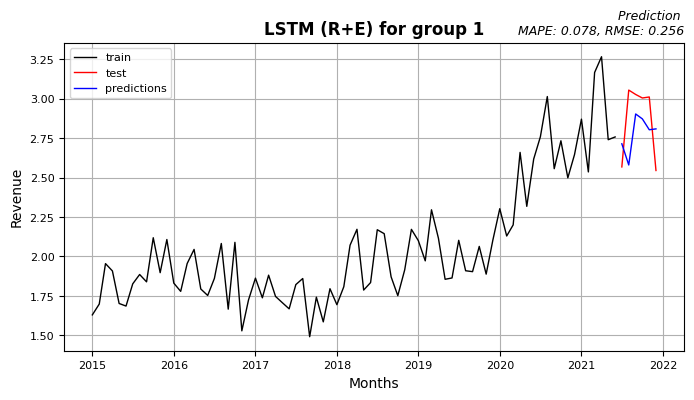

In [ ]:
f_ts_plot(train_s1['revenue'],
          test_s1['revenue'],
          pd.Series(test_predict_s1[:,0], index = test_s1['revenue'].index),
          'LSTM (R+E) for group 1')

In [ ]:
data_s2 = data_s2[['revenue', 'euro']]
train_X, test_X, train_y, test_y, scaler_2 = f_lstm_mult(data_s2)

In [ ]:
tf.random.set_seed(RANDOM_SEED)

model = Sequential()
model.add(LSTM(200, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), seed=RANDOM_SEED))
model.add(Dropout(0.2, seed=RANDOM_SEED))
model.add(LSTM(200, return_sequences=False, seed=RANDOM_SEED))
model.add(Dropout(0.2, seed=RANDOM_SEED))
model.add(Dense(8, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1, activation = "linear"))


model.compile(loss='mse', optimizer='adam')
multi_history = model.fit(train_X, train_y, epochs=50,
                                batch_size=4, validation_data=(test_X, test_y),
                                verbose=1, shuffle=False)

Epoch 1/50
20/20 [==============================] - 6s 60ms/step - loss: 0.0615 - val_loss: 0.0453
Epoch 2/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0426 - val_loss: 0.0597
Epoch 3/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0266 - val_loss: 0.0519
Epoch 4/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0283 - val_loss: 0.0511
Epoch 5/50
20/20 [==============================] - 0s 12ms/step - loss: 0.0264 - val_loss: 0.0501
Epoch 6/50
20/20 [==============================] - 0s 12ms/step - loss: 0.0241 - val_loss: 0.0517
Epoch 7/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0248 - val_loss: 0.0515
Epoch 8/50
20/20 [==============================] - 0s 12ms/step - loss: 0.0232 - val_loss: 0.0532
Epoch 9/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0223 - val_loss: 0.0544
Epoch 10/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0196 - val_loss: 0.0554
Epoch 11/

In [ ]:
MAPE, MAE, MSE, RMSE, y_test_s2, test_predict_s2 = f_lstm_mult_result(test_X, test_y, scaler_2)

MAPE: 0.133
MAE: 0.279
MSE: 0.115
RMSE: 0.339


For the second group the best LSTM model we build is the one with LSTM (200), Dropout (0.2), LSTM (200) Dropout (0.2), Dense (8) and Dense (1) on 4 batch size and 50 epochs. It is very accurate, resulting MAPE=0.133 and RMSE=0.339.

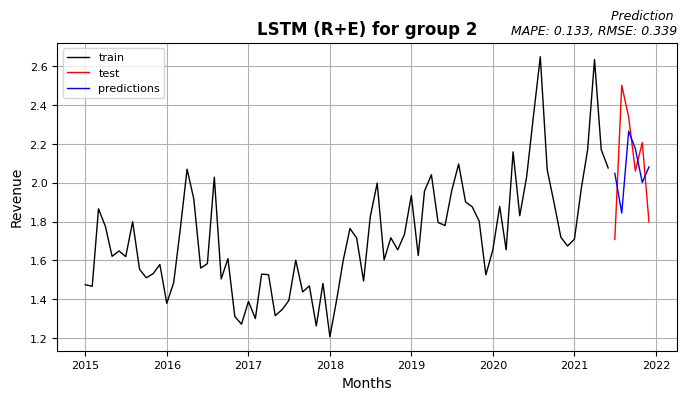

In [ ]:
f_ts_plot(train_s2['revenue'],
          test_s2['revenue'],
          pd.Series(test_predict_s2[:,0], index = test_s2['revenue'].index),
          'LSTM (R+E) for group 2')

In [ ]:
data_s3 = data_s3[['revenue', 'euro']]
train_X, test_X, train_y, test_y, scaler_2 = f_lstm_mult(data_s3)

In [ ]:
tf.random.set_seed(RANDOM_SEED)

model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), seed=RANDOM_SEED))
model.add(Dropout(0.25, seed=RANDOM_SEED))
model.add(LSTM(128, return_sequences=False, seed=RANDOM_SEED))
model.add(Dropout(0.25, seed=RANDOM_SEED))
model.add(Dense(8, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1, activation = "linear"))


model.compile(loss='mse', optimizer='adam')
multi_history = model.fit(train_X, train_y, epochs=100,
                                batch_size=4, validation_data=(test_X, test_y),
                                verbose=1, shuffle=False)

Epoch 1/100
20/20 [==============================] - 5s 62ms/step - loss: 0.0706 - val_loss: 0.0285
Epoch 2/100
20/20 [==============================] - 0s 12ms/step - loss: 0.0428 - val_loss: 0.0400
Epoch 3/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0354 - val_loss: 0.0366
Epoch 4/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0358 - val_loss: 0.0327
Epoch 5/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0346 - val_loss: 0.0349
Epoch 6/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0312 - val_loss: 0.0324
Epoch 7/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0330 - val_loss: 0.0318
Epoch 8/100
20/20 [==============================] - 0s 14ms/step - loss: 0.0319 - val_loss: 0.0311
Epoch 9/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0324 - val_loss: 0.0307
Epoch 10/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0328 - val_loss: 0.0293


In [ ]:
MAPE, MAE, MSE, RMSE, y_test_s3, test_predict_s3 = f_lstm_mult_result(test_X, test_y, scaler_2)

MAPE: 0.051
MAE: 0.144
MSE: 0.059
RMSE: 0.244


For the third group the best LSTM model we build is the one with LSTM (256), Dropout (0.25), LSTM (128) Dropout (0.25), Dense (8) and Dense (1) on 4 batch size and 100 epochs. It is very accurate, resulting MAPE=0.051 and RMSE=0.244.

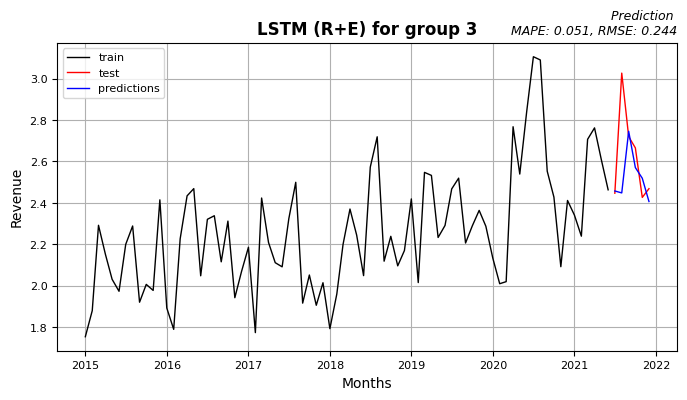

In [ ]:
f_ts_plot(train_s3['revenue'],
          test_s3['revenue'],
          pd.Series(test_predict_s3[:,0], index = test_s3['revenue'].index),
          'LSTM (R+E) for group 3')

In [ ]:
data_s4 = data_s4[['revenue', 'euro']]
train_X, test_X, train_y, test_y, scaler_2 = f_lstm_mult(data_s4)

In [ ]:
tf.random.set_seed(RANDOM_SEED)

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), seed=RANDOM_SEED))
model.add(Dropout(0.25, seed=RANDOM_SEED))
model.add(LSTM(64, return_sequences=False, seed=RANDOM_SEED))
model.add(Dropout(0.25, seed=RANDOM_SEED))
model.add(Dense(8, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1, activation = "linear"))


model.compile(loss='mse', optimizer='adam')
multi_history = model.fit(train_X, train_y, epochs=100,
                                batch_size=4, validation_data=(test_X, test_y),
                                verbose=1, shuffle=False)

Epoch 1/100
20/20 [==============================] - 6s 57ms/step - loss: 0.0850 - val_loss: 0.2059
Epoch 2/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0348 - val_loss: 0.0568
Epoch 3/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0436 - val_loss: 0.0493
Epoch 4/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0439 - val_loss: 0.0513
Epoch 5/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0362 - val_loss: 0.0388
Epoch 6/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0321 - val_loss: 0.0308
Epoch 7/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0290 - val_loss: 0.0252
Epoch 8/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0275 - val_loss: 0.0182
Epoch 9/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0230 - val_loss: 0.0130
Epoch 10/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0251 - val_loss: 0.0148
Epoch 11

In [ ]:
MAPE, MAE, MSE, RMSE, y_test_s4, test_predict_s4 = f_lstm_mult_result(test_X, test_y, scaler_2)

MAPE: 0.032
MAE: 0.105
MSE: 0.035
RMSE: 0.186


For the four group the best LSTM model we build is the one with LSTM (128), Dropout (0.25), LSTM (64) Dropout (0.25), Dense (8) and Dense (1) on 4 batch size and 100 epochs. It is very accurate, resulting MAPE=0.032 and RMSE=0.186.

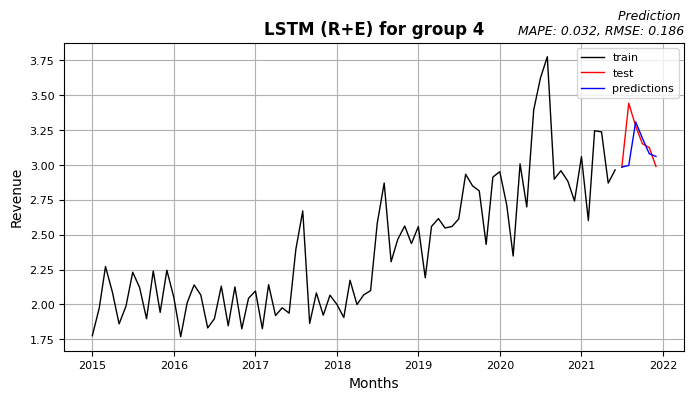

In [ ]:
f_ts_plot(train_s4['revenue'],
          test_s4['revenue'],
          pd.Series(test_predict_s4[:,0], index = test_s4['revenue'].index),
          'LSTM (R+E) for group 4')

In [ ]:
test_predict_s1234 = test_predict_s1 + test_predict_s2 + test_predict_s3 + test_predict_s4
y_test_s1234 = y_test_s1[0] + y_test_s2[0] + y_test_s3[0] + y_test_s4[0]
MAPE, MAE, MSE, RMSE = f_metrics(y_test_s1234, test_predict_s1234)

print('MAPE {:.3f}'.format(MAPE))
print('MAE {:.3f}'.format(MAE))
print('MSE {:.3f}'.format(MSE))
print('RMSE {:.3f}'.format(RMSE))

MAPE 0.057
MAE 0.632
MSE 0.894
RMSE 0.946


After combining models and summing their predictions we obtain scores of MAPE=0.057 and RMSE=0.946.

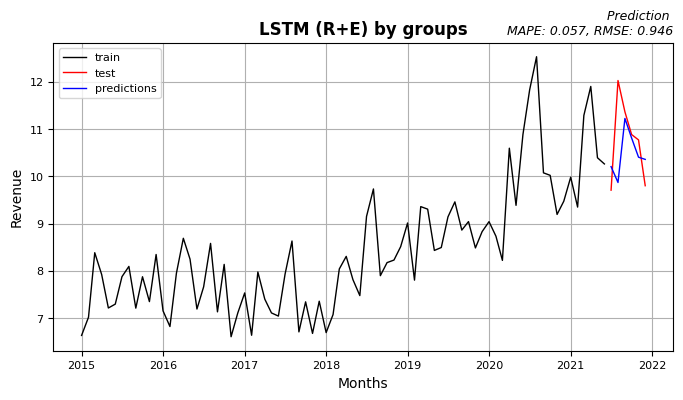

In [ ]:
f_ts_plot(df_mult['revenue'][:train_size],
          df_mult['revenue'][train_size:],
          pd.Series(test_predict_s1234[:,0], index = df_mult['revenue'][train_size:].index),
          'LSTM (R+E) by groups')

Graph shows despite a good score the model similarly incorrectly predicts the peak in September, while it happens in August. Wave is smaller than the one on the test data, however predictions are pessimistically precise for July, November and December.

In [ ]:
model_table.loc[len(model_table)] = [
    str('LSTM Multivariate by groups'),
    str('revenue')+' + '+str('euro'),
    MAPE,
    MAE,
    MSE,
    RMSE
  ]

model_table

model  \
0                       SARIMAX   
1             SARIMAX by groups   
2               LSTM Univariate   
3             LSTM Multivariate   
4             LSTM Multivariate   
5             LSTM Multivariate   
6             LSTM Multivariate   
7             LSTM Multivariate   
8             LSTM Multivariate   
9             LSTM Multivariate   
10  LSTM Multivariate by groups   
11  LSTM Multivariate by groups   

                                              comment  MAPE   MAE   MSE  RMSE  
0                                               Total 0.066 0.664 1.005 1.003  
1                                               Total 0.063 0.640 0.747 0.864  
2                                               Total 0.065 0.725 1.108 1.052  
3   revenue + euro + All_new_cases + All_new_death... 0.058 0.622 0.716 0.846  
4                                      revenue + euro 0.056 0.630 0.918 0.958  
5                      revenue + euro + All_new_cases 0.067 0.727 0.903 0.950  
6                     revenue + euro + All_new_deaths 0.079 0.848 1.039 1.019  
7                        revenue + euro + P_new_cases 0.098 1.055 1.354 1.163  
8                       revenue + euro + P_new_deaths 0.088 0.950 1.184 1.088  
9                              revenue + P_new_deaths 0.175 1.863 4.076 2.019  
10  revenue + euro + All_new_cases + All_new_death... 0.055 0.598 0.721 0.849  
11                                     revenue + euro 0.057 0.632 0.894 0.946

## <a name="c4.6">Prophet Univariate</a>

Prophet library is designed to be simple and completely automatic to implement. Our data is measured in months, so does not contain holidays or business days and does not need smoothing. For this reason, we follow the default settings.

In [ ]:
df_scaled = df_mult.copy()

scaler = MinMaxScaler()
df_scaled[['revenue', 'euro', 'All_new_cases', 'All_new_deaths', 'P_new_cases',
       'P_new_deaths']] = scaler.fit_transform(df_mult[['revenue', 'euro', 'All_new_cases', 'All_new_deaths', 'P_new_cases',
       'P_new_deaths']])
'''
df_scaled['All_new_cases'] = 1 - df_scaled['All_new_cases']
df_scaled['All_new_deaths'] = 1 - df_scaled['All_new_deaths']
df_scaled['P_new_cases'] = 1 - df_scaled['P_new_cases']
df_scaled['P_new_deaths'] = 1 - df_scaled['P_new_deaths']
'''
scaler_2 = MinMaxScaler()
dataset_MMS = df_mult.reset_index().filter(['revenue']).values
scaled_data = scaler_2.fit_transform(dataset_MMS)

df_scaled

revenue  euro  All_new_cases  All_new_deaths  P_new_cases  \
date                                                                    
2015-01-01    0.005 0.541          0.000           0.000        0.000   
2015-02-01    0.070 0.478          0.000           0.000        0.000   
2015-03-01    0.300 0.258          0.000           0.000        0.000   
2015-04-01    0.222 0.027          0.000           0.000        0.000   
2015-05-01    0.103 0.000          0.000           0.000        0.000   
...             ...   ...            ...             ...          ...   
2021-08-01    0.915 0.863          0.563           0.651        0.679   
2021-09-01    0.803 0.844          0.527           0.656        0.659   
2021-10-01    0.722 0.757          0.864           0.826        0.851   
2021-11-01    0.703 0.759          1.000           1.000        1.000   
2021-12-01    0.539 0.770          0.744           0.889        0.881   

            P_new_deaths  
date                      
2015-01-01         0.000  
2015-02-01         0.000  
2015-03-01         0.000  
2015-04-01         0.000  
2015-05-01         0.000  
...                  ...  
2021-08-01         0.799  
2021-09-01         0.738  
2021-10-01         0.863  
2021-11-01         1.000  
2021-12-01         0.556  

[84 rows x 6 columns]

In [ ]:
def f_Prophet_mult_result(test_df_):
  forecast = m.predict(test_df_)
  forecast = forecast[['ds', 'yhat']]
  cmp_df_mult = pd.concat((forecast.set_index('ds'), test_df_.set_index('ds')), axis=1)
  y_test = cmp_df_mult['y'][-6:]
  pred = cmp_df_mult['yhat'][-6:]

  y_test_sc = scaler_2.inverse_transform(list(map(lambda el:[el], y_test)))[:,0]
  pred_sc = scaler_2.inverse_transform(list(map(lambda el:[el], pred)))[:,0]


  MAPE = mean_absolute_percentage_error(y_test_sc, pred_sc)
  MAE = mean_absolute_error(y_test_sc, pred_sc)
  MSE = mean_squared_error(y_test_sc, pred_sc)
  RMSE = np.sqrt(mean_squared_error(y_test_sc, pred_sc))

  print('MAPE', MAPE)
  print('MAE', MAE)
  print('MSE', MSE)
  print('RMSE', RMSE)

  return MAPE, MAE, MSE, RMSE, y_test_sc, pred_sc

In [ ]:
predictions = 6

# приводим dataframe к нужному формату
df = df_scaled.reset_index()
df.columns = ['ds', 'y', 'euro', 'All_new_cases', 'All_new_deaths', 'P_new_cases',
       'P_new_deaths']

train_df = df[:-predictions]
test_df = df[len(df)-predictions:]
print(len(train_df), len(test_df))

78 6


In [ ]:
#tf.random.set_seed(RANDOM_SEED)

m = Prophet()
m.fit(train_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


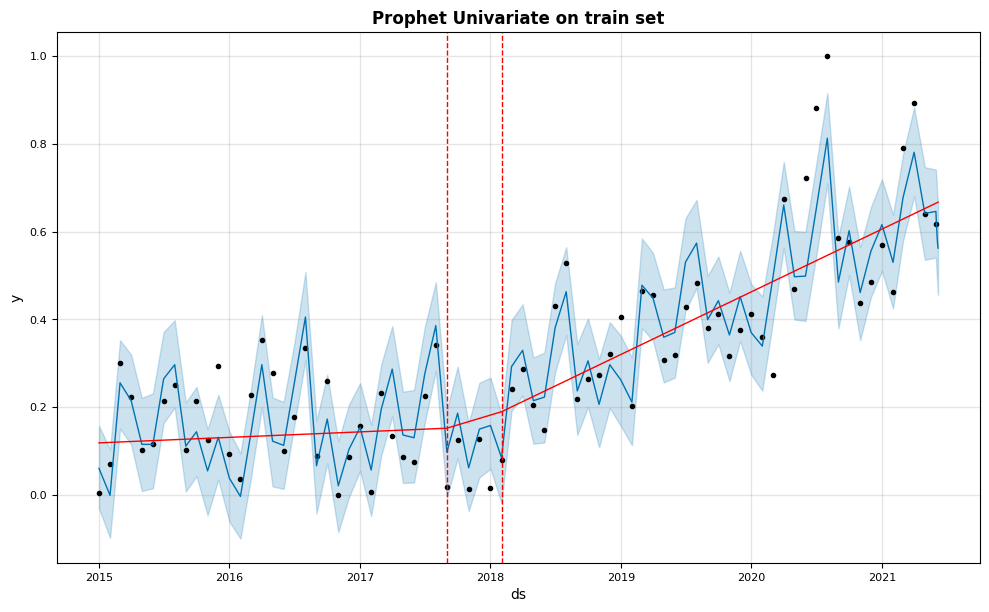

In [ ]:
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
plt.title('Prophet Univariate on train set')
plt.show()

After running the model on total revenue, we look on graphs that analyze the train dataset. First, the model correctly determined the trend and its changepoint, one in September 2017, second in February 2018. A period of stability is followed by growth.

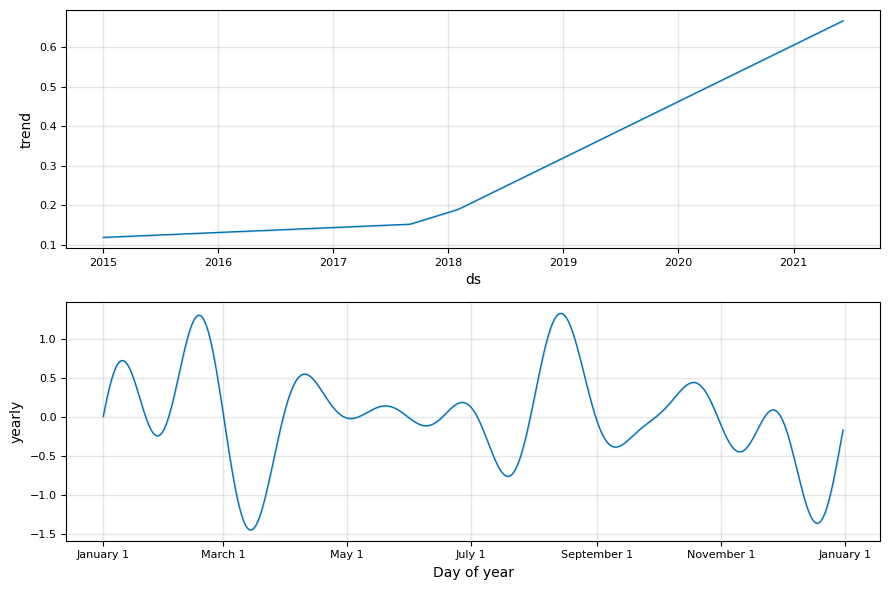

In [ ]:
fig2 = m.plot_components(forecast)
fig2

Moreover, it shows what we already assumed, the higher revenue is generally in February and August, the lowest is in March and December.

In [ ]:
MAPE, MAE, MSE, RMSE, test_y, predictions = f_Prophet_mult_result(test_df)

MAPE 0.06926072190090467
MAE 0.7081719149158708
MSE 0.8146552491560207
RMSE 0.9025825442340555


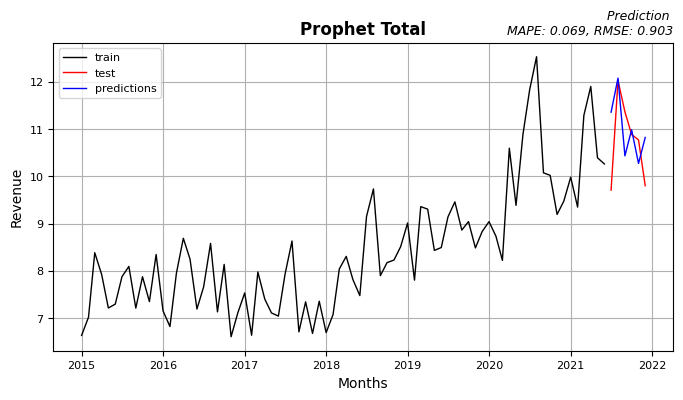

In [ ]:
f_ts_plot(df_mult['revenue'][:train_size],
          df_mult['revenue'][train_size:],
          pd.Series(predictions, index = df_mult['revenue'][train_size:].index),
          'Prophet Total')

Despite having a good score of MAPE=0.069 and RMSE=0.903, the model does not resemble wave well. It is unfairly optimistic for July and December.

In [ ]:
model_table.loc[len(model_table)] = [
    str('Prophet Univariate'),
    'Total',
    MAPE,
    MAE,
    MSE,
    RMSE
]
model_table

model  \
0                       SARIMAX   
1             SARIMAX by groups   
2               LSTM Univariate   
3             LSTM Multivariate   
4             LSTM Multivariate   
5             LSTM Multivariate   
6             LSTM Multivariate   
7             LSTM Multivariate   
8             LSTM Multivariate   
9             LSTM Multivariate   
10  LSTM Multivariate by groups   
11  LSTM Multivariate by groups   
12           Prophet Univariate   

                                              comment  MAPE   MAE   MSE  RMSE  
0                                               Total 0.066 0.664 1.005 1.003  
1                                               Total 0.063 0.640 0.747 0.864  
2                                               Total 0.065 0.725 1.108 1.052  
3   revenue + euro + All_new_cases + All_new_death... 0.058 0.622 0.716 0.846  
4                                      revenue + euro 0.056 0.630 0.918 0.958  
5                      revenue + euro + All_new_cases 0.067 0.727 0.903 0.950  
6                     revenue + euro + All_new_deaths 0.079 0.848 1.039 1.019  
7                        revenue + euro + P_new_cases 0.098 1.055 1.354 1.163  
8                       revenue + euro + P_new_deaths 0.088 0.950 1.184 1.088  
9                              revenue + P_new_deaths 0.175 1.863 4.076 2.019  
10  revenue + euro + All_new_cases + All_new_death... 0.055 0.598 0.721 0.849  
11                                     revenue + euro 0.057 0.632 0.894 0.946  
12                                              Total 0.069 0.708 0.815 0.903

## <a name="c4.7">Prophet Multivariate</a>

Next, we run a Multivariate Prophet for different combinations of the variables

<h3><b>revenue	+ euro + All_new_cases	+ All_new_deaths	+ P_new_cases	+ P_new_deaths</b></h3>

In [ ]:
m = Prophet()
m.add_regressor('euro', standardize=False)
m.add_regressor('All_new_cases', standardize=False)
m.add_regressor('All_new_deaths', standardize=False)
m.add_regressor('P_new_cases', standardize=False)
m.add_regressor('P_new_deaths', standardize=False)
m.fit(train_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
MAPE, MAE, MSE, RMSE, test_y, predictions = f_Prophet_mult_result(test_df)

MAPE 0.2343283275721438
MAE 2.563040214666421
MSE 7.305641641634362
RMSE 2.7028950482093013


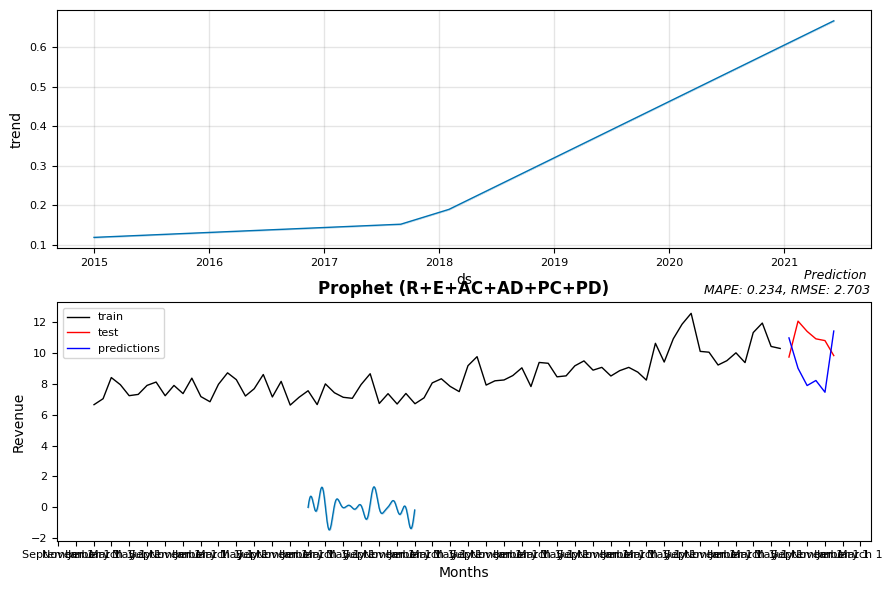

In [ ]:
f_ts_plot(df_mult['revenue'][:train_size],
          df_mult['revenue'][train_size:],
          pd.Series(predictions, index = df_mult['revenue'][train_size:].index),
          'Prophet (R+E+AC+AD+PC+PD)')

The model reveals a poor score of RMSE=0.234, RMSE=2.701 and does not resemble the data at all, by predicting a significant decline for August-November. We know, that pandemic became worse at that time, so probably the model overestimate its impact.

In [ ]:
model_table.loc[len(model_table)] = [
    str('Prophet Multivariate'),
    str('revenue')+' + '+str('euro')+' + '+str('All_new_cases')+' + '+str('All_new_deaths')+' + '+str('P_new_cases')
    +' + '+str('P_new_deaths'),
    MAPE,
    MAE,
    MSE,
    RMSE
]

<h3><b>revenue	+ euro</b></h3>

In [ ]:
m = Prophet()
m.add_regressor('euro', standardize=False)
m.fit(train_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
MAPE, MAE, MSE, RMSE, test_y, predictions = f_Prophet_mult_result(test_df)

MAPE 0.07412021154592958
MAE 0.7669687049759094
MSE 0.8841391664663231
RMSE 0.940286746937509


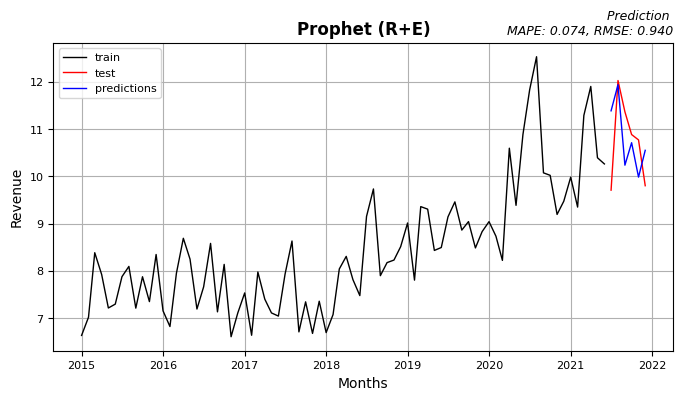

In [ ]:
f_ts_plot(df_mult['revenue'][:train_size],
          df_mult['revenue'][train_size:],
          pd.Series(predictions, index = df_mult['revenue'][train_size:].index),
          'Prophet (R+E)')

Despite having a good score of MAPE=0.074 and RMSE=0.940 and predicting the peak in August well, the model does not resemble the wave by making unfairly optimistic predictions for July and December.

In [ ]:
model_table.loc[len(model_table)] = [
    str('Prophet Multivariate'),
    str('revenue')+' + '+str('euro'),
    MAPE,
    MAE,
    MSE,
    RMSE
]

<h3><b>revenue	+ euro + All_new_cases</b></h3>

In [ ]:
m = Prophet()
m.add_regressor('euro', standardize=False)
m.add_regressor('All_new_cases', standardize=False)
m.fit(train_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
MAPE, MAE, MSE, RMSE, test_y, predictions = f_Prophet_mult_result(test_df)

MAPE 0.08409593275420589
MAE 0.8876221555377812
MSE 0.9898590895014309
RMSE 0.9949166243969546


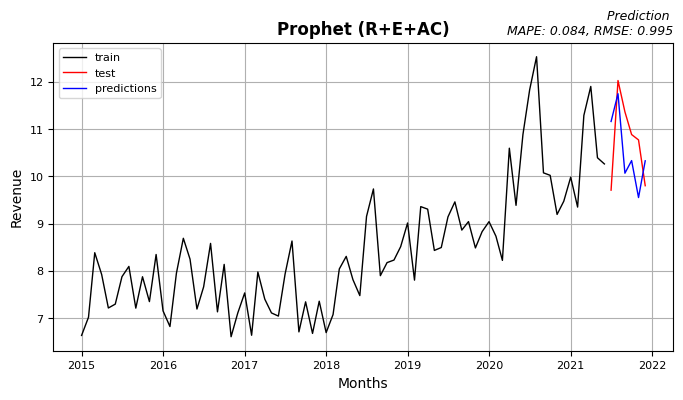

In [ ]:
f_ts_plot(df_mult['revenue'][:train_size],
          df_mult['revenue'][train_size:],
          pd.Series(predictions, index = df_mult['revenue'][train_size:].index),
          'Prophet (R+E+AC)')

The model has a fine score of MAPE=0.084 and RMSE=0.994 but does not resemble the wave by making unfairly optimistic predictions for July and unfairly pessimistic for autumn.

In [ ]:
model_table.loc[len(model_table)] = [
    str('Prophet Multivariate'),
    str('revenue')+' + '+str('euro')+' + '+str('All_new_cases'),
    MAPE,
    MAE,
    MSE,
    RMSE
]

<h3><b>revenue	+ euro + All_new_deaths</b></h3>

In [ ]:
m = Prophet()
m.add_regressor('euro', standardize=False)
m.add_regressor('All_new_deaths', standardize=False)
m.fit(train_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
MAPE, MAE, MSE, RMSE, test_y, predictions = f_Prophet_mult_result(test_df)

MAPE 0.08408726460803993
MAE 0.8914985227794882
MSE 1.021324687472159
RMSE 1.0106060990673662


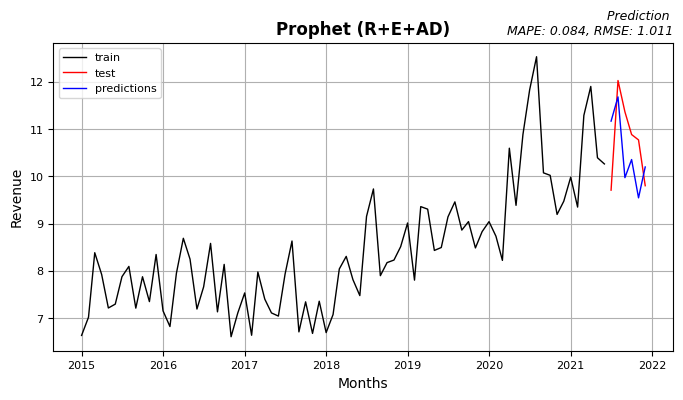

In [ ]:
f_ts_plot(df_mult['revenue'][:train_size],
          df_mult['revenue'][train_size:],
          pd.Series(predictions, index = df_mult['revenue'][train_size:].index),
          'Prophet (R+E+AD)')

The model has a fine score of MAPE=0.084 and RMSE=1.011 but does not resemble the wave by making unfairly optimistic predictions for July and unfairly pessimistic for autumn.

In [ ]:
model_table.loc[len(model_table)] = [
    str('Prophet Multivariate'),
    str('revenue')+' + '+str('euro')+' + '+str('All_new_deaths'),
    MAPE,
    MAE,
    MSE,
    RMSE
]

<h3><b>revenue	+ euro + P_new_cases</b></h3>

In [ ]:
m = Prophet()
m.add_regressor('euro', standardize=False)
m.add_regressor('P_new_cases', standardize=False)
m.fit(train_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
MAPE, MAE, MSE, RMSE, test_y, predictions = f_Prophet_mult_result(test_df)

MAPE 0.10764355565692187
MAE 1.1665696558162144
MSE 1.7212079856675626
RMSE 1.311948164245662


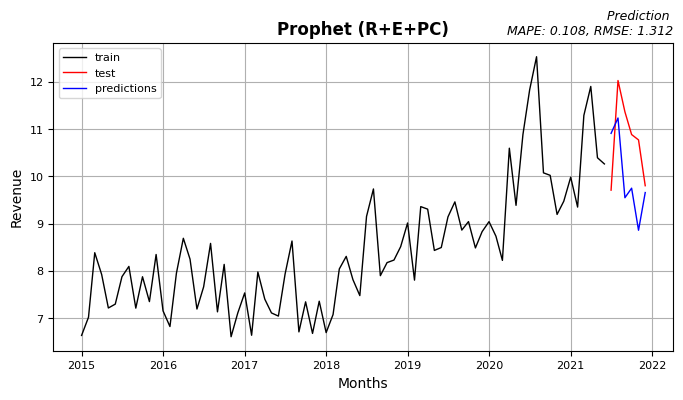

In [ ]:
f_ts_plot(df_mult['revenue'][:train_size],
          df_mult['revenue'][train_size:],
          pd.Series(predictions, index = df_mult['revenue'][train_size:].index),
          'Prophet (R+E+PC)')

The model has a poor score of MAPE=0.108 and RMSE=1.312 and does not resemble the wave by making unfairly optimistic predictions for July and highly unfairly pessimistic for autumn.

In [ ]:
model_table.loc[len(model_table)] = [
    str('Prophet Multivariate'),
    str('revenue')+' + '+str('euro')+' + '+str('P_new_cases'),
    MAPE,
    MAE,
    MSE,
    RMSE
]

<h3><b>revenue	+ euro + P_new_deaths</b></h3>

In [ ]:
m = Prophet()
m.add_regressor('euro', standardize=False)
m.add_regressor('P_new_deaths', standardize=False)
m.fit(train_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
MAPE, MAE, MSE, RMSE, test_y, predictions = f_Prophet_mult_result(test_df)

MAPE 0.12606172011037345
MAE 1.3731926381186221
MSE 2.30365244189985
RMSE 1.517778785561272


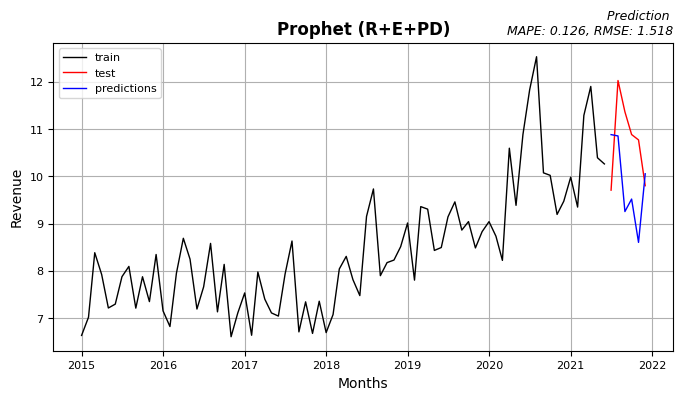

In [ ]:
f_ts_plot(df_mult['revenue'][:train_size],
          df_mult['revenue'][train_size:],
          pd.Series(predictions, index = df_mult['revenue'][train_size:].index),
          'Prophet (R+E+PD)')

The model similarly has a poor score of MAPE=0.126 and RMSE=1.520 and does not resemble the wave by making unfairly optimistic predictions for July and highly unfairly pessimistic for autumn.

In [ ]:
model_table.loc[len(model_table)] = [
    str('Prophet Multivariate'),
    str('revenue')+' + '+str('euro')+' + '+str('P_new_deaths'),
    MAPE,
    MAE,
    MSE,
    RMSE
]

<h3><b>revenue	+ All_new_cases</b></h3>

In [ ]:
m = Prophet()
m.add_regressor('All_new_cases', standardize=False)
m.fit(train_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
MAPE, MAE, MSE, RMSE, test_y, predictions = f_Prophet_mult_result(test_df)

MAPE 0.07200424689213085
MAE 0.7355207442284414
MSE 0.8681330148099526
RMSE 0.9317365586956179


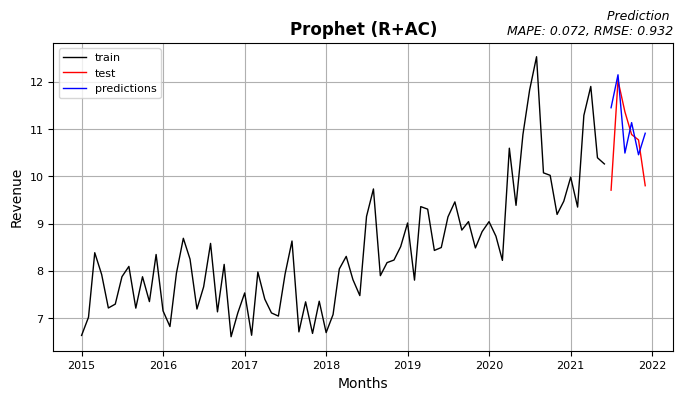

In [ ]:
f_ts_plot(df_mult['revenue'][:train_size],
          df_mult['revenue'][train_size:],
          pd.Series(predictions, index = df_mult['revenue'][train_size:].index),
          'Prophet (R+AC)')

Despite having a fine score of MAPE=0.072 and RMSE=0.931, the model and does not resemble the wave by making unfairly optimistic predictions for July and December.

In [ ]:
model_table.loc[len(model_table)] = [
    str('Prophet Multivariate'),
    str('revenue')+' + '+str('All_new_cases'),
    MAPE,
    MAE,
    MSE,
    RMSE
]

model_table

model  \
0                       SARIMAX   
1             SARIMAX by groups   
2               LSTM Univariate   
3             LSTM Multivariate   
4             LSTM Multivariate   
5             LSTM Multivariate   
6             LSTM Multivariate   
7             LSTM Multivariate   
8             LSTM Multivariate   
9             LSTM Multivariate   
10  LSTM Multivariate by groups   
11  LSTM Multivariate by groups   
12           Prophet Univariate   
13         Prophet Multivariate   
14         Prophet Multivariate   
15         Prophet Multivariate   
16         Prophet Multivariate   
17         Prophet Multivariate   
18         Prophet Multivariate   
19         Prophet Multivariate   

                                              comment  MAPE   MAE   MSE  RMSE  
0                                               Total 0.066 0.664 1.005 1.003  
1                                               Total 0.063 0.640 0.747 0.864  
2                                               Total 0.065 0.725 1.108 1.052  
3   revenue + euro + All_new_cases + All_new_death... 0.058 0.622 0.716 0.846  
4                                      revenue + euro 0.056 0.630 0.918 0.958  
5                      revenue + euro + All_new_cases 0.067 0.727 0.903 0.950  
6                     revenue + euro + All_new_deaths 0.079 0.848 1.039 1.019  
7                        revenue + euro + P_new_cases 0.098 1.055 1.354 1.163  
8                       revenue + euro + P_new_deaths 0.088 0.950 1.184 1.088  
9                              revenue + P_new_deaths 0.175 1.863 4.076 2.019  
10  revenue + euro + All_new_cases + All_new_death... 0.055 0.598 0.721 0.849  
11                                     revenue + euro 0.057 0.632 0.894 0.946  
12                                              Total 0.069 0.708 0.815 0.903  
13  revenue + euro + All_new_cases + All_new_death... 0.234 2.563 7.306 2.703  
14                                     revenue + euro 0.074 0.767 0.884 0.940  
15                     revenue + euro + All_new_cases 0.084 0.888 0.990 0.995  
16                    revenue + euro + All_new_deaths 0.084 0.891 1.021 1.011  
17                       revenue + euro + P_new_cases 0.108 1.167 1.721 1.312  
18                      revenue + euro + P_new_deaths 0.126 1.373 2.304 1.518  
19                            revenue + All_new_cases 0.072 0.736 0.868 0.932

## <a name="c4.8">Prophet Multivariate by groups</a>

Next, we run Prophet groupping models for all 6 variables and for revenue+euro as the best combinations following the previous analysis.

In [ ]:
def f_prophet_mult_scale(df_mult_):

  scaler = MinMaxScaler()
  df_scaled = df_mult_.copy()
  df_scaled[['revenue', 'euro', 'All_new_cases', 'All_new_deaths', 'P_new_cases',
        'P_new_deaths']] = scaler.fit_transform(df_mult_[['revenue', 'euro', 'All_new_cases', 'All_new_deaths', 'P_new_cases',
        'P_new_deaths']])

  scaler_2 = MinMaxScaler()
  dataset_MMS = df_mult_.reset_index().filter(['revenue']).values
  scaled_data = scaler_2.fit_transform(dataset_MMS)

  df_scaled = df_scaled.reset_index()
  df_scaled.columns = ['ds', 'y', 'euro', 'All_new_cases', 'All_new_deaths', 'P_new_cases',
        'P_new_deaths']

  predictions = 6
  train_df = df_scaled[:-predictions]
  test_df = df_scaled[len(df_scaled)-predictions:]

  return df_scaled, train_df, test_df, scaler_2

In [ ]:
def f_Prophet_mult_result_groups(test_df_, scaler_2_):
  forecast = m.predict(test_df_)
  forecast = forecast[['ds', 'yhat']]
  cmp_df_mult = pd.concat((forecast.set_index('ds'), test_df_.set_index('ds')), axis=1)
  y_test = cmp_df_mult['y'][-6:]
  pred = cmp_df_mult['yhat'][-6:]

  y_test_sc = scaler_2_.inverse_transform(list(map(lambda el:[el], y_test)))[:,0]
  pred_sc = scaler_2_.inverse_transform(list(map(lambda el:[el], pred)))[:,0]

  return y_test_sc, pred_sc

In [ ]:
train_s1, test_s1, data_s1 = f_groups_2(
    df_new[["Kyanite", "Garnet", "Rhodonite", "Beryl", "Topaz", "Ruby", "Tigereye", "Sapphire"]])
train_s2, test_s2, data_s2 = f_groups_2(
    df_new[["Fluorite", "Quartz","Bixbite", "Opal"]])
train_s3, test_s3, data_s3 = f_groups_2(
    df_new[["Diamond", "Jade", "Jasper", "Coral", "Amethyst", "Moonstone"]])
train_s4, test_s4, data_s4 = f_groups_2(
    df_new[["Bloodstone", "Emerald", "Marble", "Sodalite", "Citrine", "Malachite"]])

In [ ]:
df_scaled_s1, train_df_s1, test_df_s1, scaler_2_s1 = f_prophet_mult_scale(data_s1)
df_scaled_s2, train_df_s2, test_df_s2, scaler_2_s2 = f_prophet_mult_scale(data_s2)
df_scaled_s3, train_df_s3, test_df_s3, scaler_2_s3 = f_prophet_mult_scale(data_s3)
df_scaled_s4, train_df_s4, test_df_s4, scaler_2_s4 = f_prophet_mult_scale(data_s4)

<h3><b>revenue	+ euro + All_new_cases	+ All_new_deaths	+ P_new_cases	+ P_new_deaths</b></h3>

In [ ]:
m = Prophet()
m.add_regressor('euro', standardize=False)
m.add_regressor('All_new_cases', standardize=False)
m.add_regressor('All_new_deaths', standardize=False)
m.add_regressor('P_new_cases', standardize=False)
m.add_regressor('P_new_deaths', standardize=False)
m.fit(train_df_s1)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
test_y_s1, predictions_s1 = f_Prophet_mult_result_groups(test_df_s1, scaler_2_s1)
MAPE, MAE, MSE, RMSE =  f_metrics(test_y_s1, predictions_s1)
print('MAPE {:.3f}'.format(MAPE))
print('MAE {:.3f}'.format(MAE))
print('MSE {:.3f}'.format(MSE))
print('RMSE {:.3f}'.format(RMSE))

MAPE 0.289
MAE 0.836
MSE 0.748
RMSE 0.865


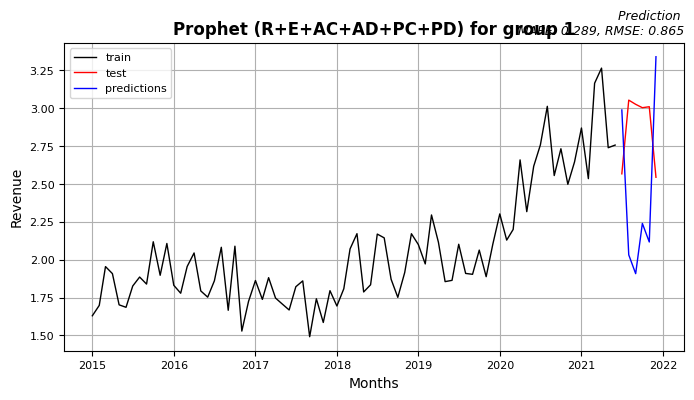

In [ ]:
f_ts_plot(data_s1['revenue'][:train_size:],
          data_s1['revenue'][train_size:],
          pd.Series(predictions_s1, index = data_s1['revenue'][train_size:].index),
          'Prophet (R+E+AC+AD+PC+PD) for group 1')

Four group 1 the model  has a very poor score of MAPE=0.289 and RMSE=0.865 and does not resemble the wave by making unfairly pessimistic predictions for August-November.

In [ ]:
m = Prophet()
m.add_regressor('euro', standardize=False)
m.add_regressor('All_new_cases', standardize=False)
m.add_regressor('All_new_deaths', standardize=False)
m.add_regressor('P_new_cases', standardize=False)
m.add_regressor('P_new_deaths', standardize=False)
m.fit(train_df_s2)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
test_y_s2, predictions_s2 = f_Prophet_mult_result_groups(test_df_s2, scaler_2_s2)
MAPE, MAE, MSE, RMSE =  f_metrics(test_y_s2, predictions_s2)
print('MAPE {:.3f}'.format(MAPE))
print('MAE {:.3f}'.format(MAE))
print('MSE {:.3f}'.format(MSE))
print('RMSE {:.3f}'.format(RMSE))

MAPE 0.182
MAE 0.377
MSE 0.157
RMSE 0.397


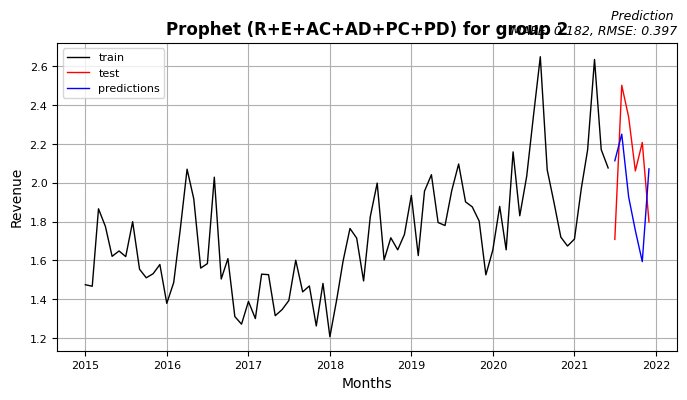

In [ ]:
f_ts_plot(data_s2['revenue'][:train_size],
          data_s2['revenue'][train_size:],
          pd.Series(predictions_s2, index = data_s2['revenue'][train_size:].index),
          'Prophet (R+E+AC+AD+PC+PD) for group 2')

Similarly, for group 2 the model  has a  poor score of MAPE=0.182 and RMSE=0.397 and does not resemble the wave by making unfairly pessimistic predictions for autumn.

In [ ]:
m = Prophet()
m.add_regressor('euro', standardize=False)
m.add_regressor('All_new_cases', standardize=False)
m.add_regressor('All_new_deaths', standardize=False)
m.add_regressor('P_new_cases', standardize=False)
m.add_regressor('P_new_deaths', standardize=False)
m.fit(train_df_s3)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
test_y_s3, predictions_s3 = f_Prophet_mult_result_groups(test_df_s3, scaler_2_s3)
MAPE, MAE, MSE, RMSE =  f_metrics(test_y_s3, predictions_s3)
print('MAPE {:.3f}'.format(MAPE))
print('MAE {:.3f}'.format(MAE))
print('MSE {:.3f}'.format(MSE))
print('RMSE {:.3f}'.format(RMSE))

MAPE 0.209
MAE 0.558
MSE 0.400
RMSE 0.633


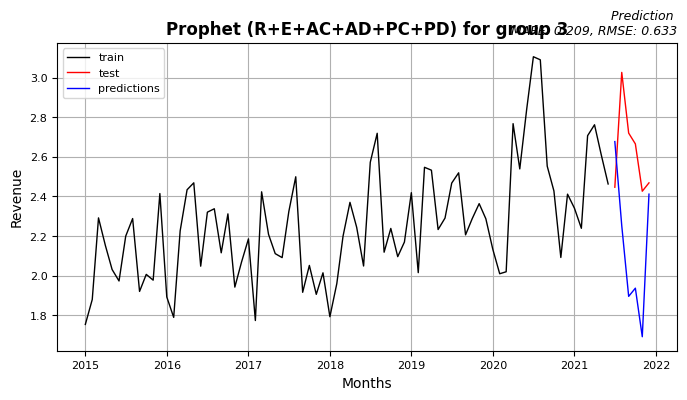

In [ ]:
f_ts_plot(data_s3['revenue'][:train_size],
          data_s3['revenue'][train_size:],
          pd.Series(predictions_s3, index = data_s3['revenue'][train_size:].index),
          'Prophet (R+E+AC+AD+PC+PD) for group 3')

Similarly, for group 3 the model  has a very poor score of MAPE=0.209 and RMSE=0.633 and does not resemble the wave by making unfairly pessimistic predictions for August-November.

In [ ]:
m = Prophet()
m.add_regressor('euro', standardize=False)
m.add_regressor('All_new_cases', standardize=False)
m.add_regressor('All_new_deaths', standardize=False)
m.add_regressor('P_new_cases', standardize=False)
m.add_regressor('P_new_deaths', standardize=False)
m.fit(train_df_s4)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
test_y_s4, predictions_s4 = f_Prophet_mult_result_groups(test_df_s4, scaler_2_s4)
MAPE, MAE, MSE, RMSE =  f_metrics(test_y_s4, predictions_s4)
print('MAPE {:.3f}'.format(MAPE))
print('MAE {:.3f}'.format(MAE))
print('MSE {:.3f}'.format(MSE))
print('RMSE {:.3f}'.format(RMSE))

MAPE 0.274
MAE 0.877
MSE 0.902
RMSE 0.950


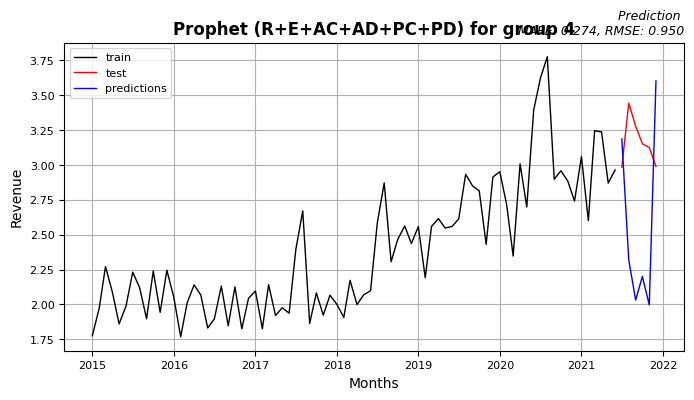

In [ ]:
f_ts_plot(data_s4['revenue'][:train_size],
          data_s4['revenue'][train_size:],
          pd.Series(predictions_s4, index = data_s4['revenue'][train_size:].index),
          'Prophet (R+E+AC+AD+PC+PD) for group 4')

Similarly, for group 4 the model  has a very poor score of MAPE=0.274 and RMSE=0.950 and does not resemble the wave by making unfairly pessimistic predictions for August-November.

In [ ]:
print(predictions_s3)
print(predictions_s4)

[2.67691353 2.25271088 1.89597244 1.93731305 1.69235429 2.41173895]
[3.18666385 2.31958819 2.0317447  2.20055329 1.9972587  3.60250281]


We become suspicious and check if these are not the same predictions because waves are extremely simillar.

In [ ]:
test_predict_s1234 = predictions_s1 + predictions_s2 + predictions_s3 + predictions_s4
y_test_s1234 = test_y_s1 + test_y_s2 + test_y_s3 + test_y_s4
MAPE, MAE, MSE, RMSE = f_metrics(y_test_s1234, test_predict_s1234)

print('MAPE {:.3f}'.format(MAPE))
print('MAE {:.3f}'.format(MAE))
print('MSE {:.3f}'.format(MSE))
print('RMSE {:.3f}'.format(RMSE))

MAPE 0.240
MAE 2.630
MSE 7.695
RMSE 2.774


After combining models and summing their predictions we obtain scores of MAPE=0.240 and RMSE=2.774.

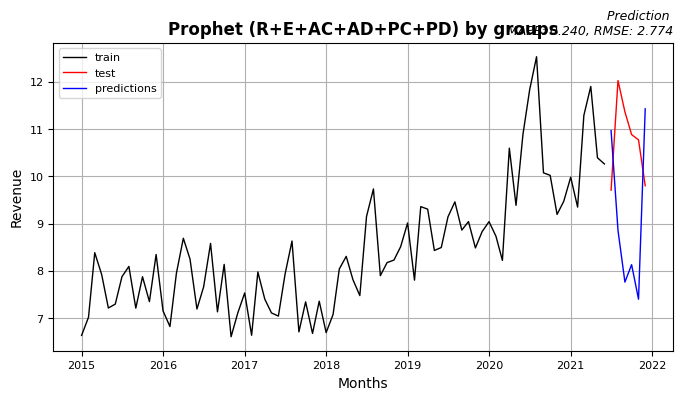

In [ ]:
f_ts_plot(df_mult['revenue'][:train_size],
          df_mult['revenue'][train_size:],
          pd.Series(test_predict_s1234, index = df_mult['revenue'][train_size:].index),
          'Prophet (R+E+AC+AD+PC+PD) by groups')

Graph shows that the model does not resemble the wave well and make unfairly pessimistic predictions for August-November.

In [ ]:
model_table.loc[len(model_table)] = [
    str('Prophet Multivariate by groups'),
    str('revenue')+' + '+str('euro')+' + '+str('All_new_cases')+' + '+str('All_new_deaths')+' + '+str('P_new_cases')
    +' + '+str('P_new_deaths'),
    MAPE,
    MAE,
    MSE,
    RMSE
]
model_table

model  \
0                          SARIMAX   
1                SARIMAX by groups   
2                  LSTM Univariate   
3                LSTM Multivariate   
4                LSTM Multivariate   
5                LSTM Multivariate   
6                LSTM Multivariate   
7                LSTM Multivariate   
8                LSTM Multivariate   
9                LSTM Multivariate   
10     LSTM Multivariate by groups   
11     LSTM Multivariate by groups   
12              Prophet Univariate   
13            Prophet Multivariate   
14            Prophet Multivariate   
15            Prophet Multivariate   
16            Prophet Multivariate   
17            Prophet Multivariate   
18            Prophet Multivariate   
19            Prophet Multivariate   
20  Prophet Multivariate by groups   

                                              comment  MAPE   MAE   MSE  RMSE  
0                                               Total 0.066 0.664 1.005 1.003  
1                                               Total 0.063 0.640 0.747 0.864  
2                                               Total 0.065 0.725 1.108 1.052  
3   revenue + euro + All_new_cases + All_new_death... 0.058 0.622 0.716 0.846  
4                                      revenue + euro 0.056 0.630 0.918 0.958  
5                      revenue + euro + All_new_cases 0.067 0.727 0.903 0.950  
6                     revenue + euro + All_new_deaths 0.079 0.848 1.039 1.019  
7                        revenue + euro + P_new_cases 0.098 1.055 1.354 1.163  
8                       revenue + euro + P_new_deaths 0.088 0.950 1.184 1.088  
9                              revenue + P_new_deaths 0.175 1.863 4.076 2.019  
10  revenue + euro + All_new_cases + All_new_death... 0.055 0.598 0.721 0.849  
11                                     revenue + euro 0.057 0.632 0.894 0.946  
12                                              Total 0.069 0.708 0.815 0.903  
13  revenue + euro + All_new_cases + All_new_death... 0.234 2.563 7.306 2.703  
14                                     revenue + euro 0.074 0.767 0.884 0.940  
15                     revenue + euro + All_new_cases 0.084 0.888 0.990 0.995  
16                    revenue + euro + All_new_deaths 0.084 0.891 1.021 1.011  
17                       revenue + euro + P_new_cases 0.108 1.167 1.721 1.312  
18                      revenue + euro + P_new_deaths 0.126 1.373 2.304 1.518  
19                            revenue + All_new_cases 0.072 0.736 0.868 0.932  
20  revenue + euro + All_new_cases + All_new_death... 0.240 2.630 7.695 2.774

<h3><b>revenue	+ euro</b></h3>

Then, we run a Multivariate Prophet by groups for revenue and euro.

In [ ]:
m = Prophet()
m.add_regressor('euro', standardize=False)
m.fit(train_df_s1)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
test_y_s1, predictions_s1 = f_Prophet_mult_result_groups(test_df_s1, scaler_2_s1)
MAPE, MAE, MSE, RMSE =  f_metrics(test_y_s1, predictions_s1)
print('MAPE {:.3f}'.format(MAPE))
print('MAE {:.3f}'.format(MAE))
print('MSE {:.3f}'.format(MSE))
print('RMSE {:.3f}'.format(RMSE))

MAPE 0.102
MAE 0.289
MSE 0.097
RMSE 0.311


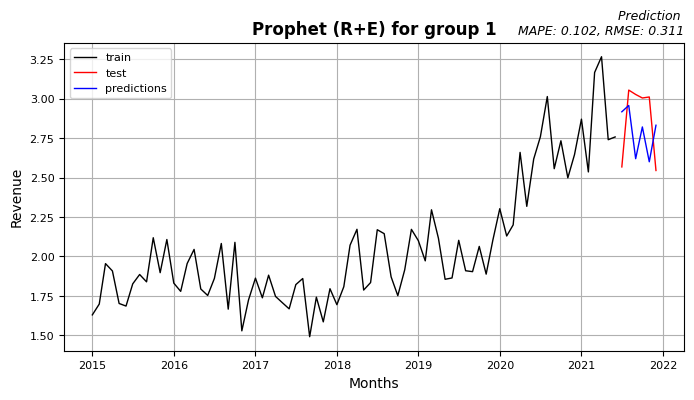

In [ ]:
f_ts_plot(data_s1['revenue'][:train_size],
          data_s1['revenue'][train_size:],
          pd.Series(predictions_s1, index = data_s1['revenue'][train_size:].index),
          'Prophet (R+E) for group 1')

For group 1 the model has scores of MAPE=0.102 and RMSE=0.311 and does not resemble the wave by making unfairly pessimistic predictions for autumn.

In [ ]:
m = Prophet()
m.add_regressor('euro', standardize=False)
m.fit(train_df_s2)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
test_y_s2, predictions_s2 = f_Prophet_mult_result_groups(test_df_s2, scaler_2_s2)
MAPE, MAE, MSE, RMSE =  f_metrics(test_y_s2, predictions_s2)
print('MAPE {:.3f}'.format(MAPE))
print('MAE {:.3f}'.format(MAE))
print('MSE {:.3f}'.format(MSE))
print('RMSE {:.3f}'.format(RMSE))

MAPE 0.158
MAE 0.300
MSE 0.133
RMSE 0.365


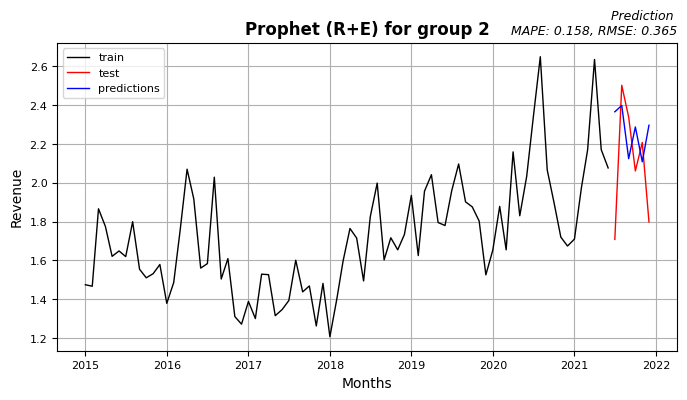

In [ ]:
f_ts_plot(data_s2['revenue'][:train_size],
          data_s2['revenue'][train_size:],
          pd.Series(predictions_s2, index = data_s2['revenue'][train_size:].index),
          'Prophet (R+E) for group 2')

For group 2 the model has scores of MAPE=0.158 and RMSE=0.365 and resembles the wave fine, but makes unfairly optimistic predictions for July and December.



In [ ]:
m = Prophet()
m.add_regressor('euro', standardize=False)
m.fit(train_df_s3)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
test_y_s3, predictions_s3 = f_Prophet_mult_result_groups(test_df_s1, scaler_2_s3)
MAPE, MAE, MSE, RMSE =  f_metrics(test_y_s3, predictions_s3)
print('MAPE {:.3f}'.format(MAPE))
print('MAE {:.3f}'.format(MAE))
print('MSE {:.3f}'.format(MSE))
print('RMSE {:.3f}'.format(RMSE))

MAPE 0.110
MAE 0.315
MSE 0.141
RMSE 0.375


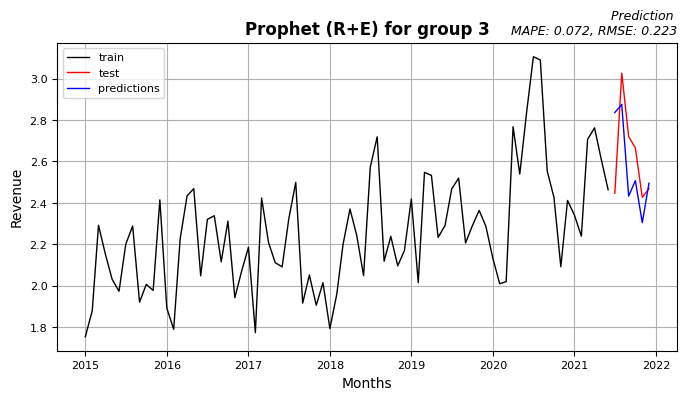

In [ ]:
f_ts_plot(data_s3['revenue'][:train_size],
          data_s3['revenue'][train_size:],
          pd.Series(predictions_s3, index = data_s3['revenue'][train_size:].index),
          'Prophet (R+E) for group 3')

For group 3 the model has scores of MAPE=0.072 and RMSE=0.223 and resembles the wave well, but makes unfairly optimistic predictions for July.

In [ ]:
m = Prophet()
m.add_regressor('euro', standardize=False)
m.fit(train_df_s4)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
test_y_s4, predictions_s4 = f_Prophet_mult_result_groups(test_df_s4, scaler_2_s4)
MAPE, MAE, MSE, RMSE =  f_metrics(test_y_s4, predictions_s4)
print('MAPE {:.3f}'.format(MAPE))
print('MAE {:.3f}'.format(MAE))
print('MSE {:.3f}'.format(MSE))
print('RMSE {:.3f}'.format(RMSE))

MAPE 0.066
MAE 0.207
MSE 0.058
RMSE 0.240


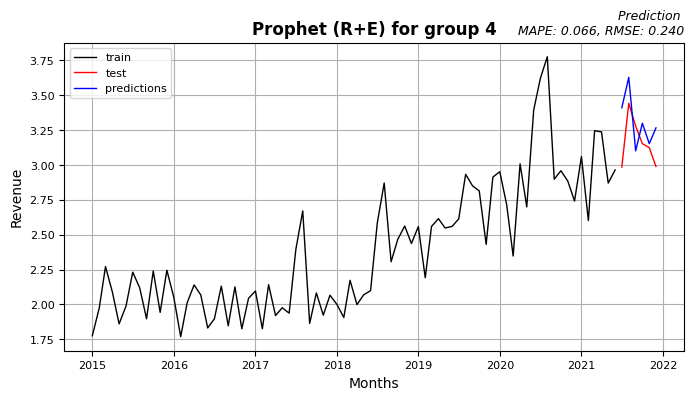

In [ ]:
f_ts_plot(data_s4['revenue'][:train_size],
          data_s4['revenue'][train_size:],
          pd.Series(predictions_s4, index = data_s4['revenue'][train_size:].index),
          'Prophet (R+E) for group 4')

For group 4 the model has scores of MAPE=0.066 and RMSE=0.240, does not resemble the wave well and makes unfairly optimistic predictions for July and December.

In [ ]:
test_predict_s1234 = predictions_s1 + predictions_s2 + predictions_s3 + predictions_s4
y_test_s1234 = test_y_s1 + test_y_s2 + test_y_s3 + test_y_s4
MAPE, MAE, MSE, RMSE = f_metrics(y_test_s1234, test_predict_s1234)

print('MAPE {:.3f}'.format(MAPE))
print('MAE {:.3f}'.format(MAE))
print('MSE {:.3f}'.format(MSE))
print('RMSE {:.3f}'.format(RMSE))

MAPE 0.085
MAE 0.894
MSE 1.129
RMSE 1.062


After combining models and summing their predictions we obtain scores of MAPE=0.078 and RMSE=1.006.

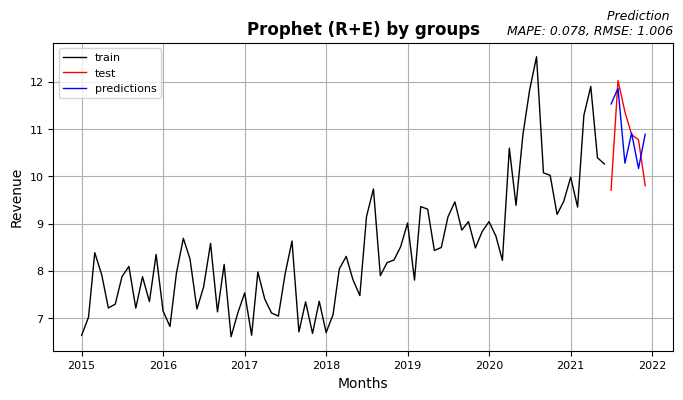

In [ ]:
f_ts_plot(df_mult['revenue'][:train_size],
          df_mult['revenue'][train_size:],
          pd.Series(test_predict_s1234, index = df_mult['revenue'][train_size:].index),
          'Prophet (R+E) by groups')

Graph shows despite fine scores the model does not resemble the wave well and make unfairly optimistic prediction for July and December.

In [ ]:
model_table.loc[len(model_table)] = [
    str('Prophet Multivariate by groups'),
    str('revenue')+' + '+str('euro'),
    MAPE,
    MAE,
    MSE,
    RMSE
]
model_table

model  \
0                          SARIMAX   
1                SARIMAX by groups   
2                  LSTM Univariate   
3                LSTM Multivariate   
4                LSTM Multivariate   
5                LSTM Multivariate   
6                LSTM Multivariate   
7                LSTM Multivariate   
8                LSTM Multivariate   
9                LSTM Multivariate   
10     LSTM Multivariate by groups   
11     LSTM Multivariate by groups   
12              Prophet Univariate   
13            Prophet Multivariate   
14            Prophet Multivariate   
15            Prophet Multivariate   
16            Prophet Multivariate   
17            Prophet Multivariate   
18            Prophet Multivariate   
19            Prophet Multivariate   
20  Prophet Multivariate by groups   
21  Prophet Multivariate by groups   

                                              comment  MAPE   MAE   MSE  RMSE  
0                                               Total 0.066 0.664 1.005 1.003  
1                                               Total 0.063 0.640 0.747 0.864  
2                                               Total 0.065 0.725 1.108 1.052  
3   revenue + euro + All_new_cases + All_new_death... 0.058 0.622 0.716 0.846  
4                                      revenue + euro 0.056 0.630 0.918 0.958  
5                      revenue + euro + All_new_cases 0.067 0.727 0.903 0.950  
6                     revenue + euro + All_new_deaths 0.079 0.848 1.039 1.019  
7                        revenue + euro + P_new_cases 0.098 1.055 1.354 1.163  
8                       revenue + euro + P_new_deaths 0.088 0.950 1.184 1.088  
9                              revenue + P_new_deaths 0.175 1.863 4.076 2.019  
10  revenue + euro + All_new_cases + All_new_death... 0.055 0.598 0.721 0.849  
11                                     revenue + euro 0.057 0.632 0.894 0.946  
12                                              Total 0.069 0.708 0.815 0.903  
13  revenue + euro + All_new_cases + All_new_death... 0.234 2.563 7.306 2.703  
14                                     revenue + euro 0.074 0.767 0.884 0.940  
15                     revenue + euro + All_new_cases 0.084 0.888 0.990 0.995  
16                    revenue + euro + All_new_deaths 0.084 0.891 1.021 1.011  
17                       revenue + euro + P_new_cases 0.108 1.167 1.721 1.312  
18                      revenue + euro + P_new_deaths 0.126 1.373 2.304 1.518  
19                            revenue + All_new_cases 0.072 0.736 0.868 0.932  
20  revenue + euro + All_new_cases + All_new_death... 0.240 2.630 7.695 2.774  
21                                     revenue + euro 0.085 0.894 1.129 1.062

# <a name="c5">Results</a>

<b><i>First, let us decide on which metric to look</b></i>. The management stands on <b><i>the goal for MAPE to be lower than 0.1</b></i>, what most models fulfill. However, MAPE is not the best indicator because it is skewed and is negatively impacted by high errors during periods of low demand. Since our data is seasonally fluctuated, has major peaks and falls, it is better to consider mean, not median, so <b><i>RMSE is better option</b></i>. MAE protects outliers, whereas RMSE guarantee us to get an unbiased forecast. Another important thing is an accurate reflection of seasonal patterns: peak in August, fall in late autumn and winter.

In [ ]:
#model_table.to_csv('model_table.csv')
model_table

model  \
0                          SARIMAX   
1                SARIMAX by groups   
2                  LSTM Univariate   
3                LSTM Multivariate   
4                LSTM Multivariate   
5                LSTM Multivariate   
6                LSTM Multivariate   
7                LSTM Multivariate   
8                LSTM Multivariate   
9                LSTM Multivariate   
10     LSTM Multivariate by groups   
11     LSTM Multivariate by groups   
12              Prophet Univariate   
13            Prophet Multivariate   
14            Prophet Multivariate   
15            Prophet Multivariate   
16            Prophet Multivariate   
17            Prophet Multivariate   
18            Prophet Multivariate   
19            Prophet Multivariate   
20  Prophet Multivariate by groups   
21  Prophet Multivariate by groups   

                                              comment  MAPE   MAE   MSE  RMSE  
0                                               Total 0.066 0.664 1.005 1.003  
1                                               Total 0.063 0.640 0.747 0.864  
2                                               Total 0.065 0.725 1.108 1.052  
3   revenue + euro + All_new_cases + All_new_death... 0.058 0.622 0.716 0.846  
4                                      revenue + euro 0.056 0.630 0.918 0.958  
5                      revenue + euro + All_new_cases 0.067 0.727 0.903 0.950  
6                     revenue + euro + All_new_deaths 0.079 0.848 1.039 1.019  
7                        revenue + euro + P_new_cases 0.098 1.055 1.354 1.163  
8                       revenue + euro + P_new_deaths 0.088 0.950 1.184 1.088  
9                              revenue + P_new_deaths 0.175 1.863 4.076 2.019  
10  revenue + euro + All_new_cases + All_new_death... 0.055 0.598 0.721 0.849  
11                                     revenue + euro 0.057 0.632 0.894 0.946  
12                                              Total 0.069 0.708 0.815 0.903  
13  revenue + euro + All_new_cases + All_new_death... 0.234 2.563 7.306 2.703  
14                                     revenue + euro 0.074 0.767 0.884 0.940  
15                     revenue + euro + All_new_cases 0.084 0.888 0.990 0.995  
16                    revenue + euro + All_new_deaths 0.084 0.891 1.021 1.011  
17                       revenue + euro + P_new_cases 0.108 1.167 1.721 1.312  
18                      revenue + euro + P_new_deaths 0.126 1.373 2.304 1.518  
19                            revenue + All_new_cases 0.072 0.736 0.868 0.932  
20  revenue + euro + All_new_cases + All_new_death... 0.240 2.630 7.695 2.774  
21                                     revenue + euro 0.085 0.894 1.129 1.062

In [ ]:
model_table.sort_values('RMSE').head()

model  \
3             LSTM Multivariate   
10  LSTM Multivariate by groups   
1             SARIMAX by groups   
12           Prophet Univariate   
19         Prophet Multivariate   

                                              comment  MAPE   MAE   MSE  RMSE  
3   revenue + euro + All_new_cases + All_new_death... 0.058 0.622 0.716 0.846  
10  revenue + euro + All_new_cases + All_new_death... 0.055 0.598 0.721 0.849  
1                                               Total 0.063 0.640 0.747 0.864  
12                                              Total 0.069 0.708 0.815 0.903  
19                            revenue + All_new_cases 0.072 0.736 0.868 0.932

Twenty one models were built. <b><i>The lowest RMSE (0.846) belongs to LSTM (R+E+AC+AD+PC+PD) model. It also has a great MAPE score (0.058) and in the ongoing pandemic situation, choosing this model might be the best decision.</b></i>

In order to achieve a better score, we tried splitting dataset into 4 store groups based on their seasonality patterns. For some models it demonstrates slightly better metrics, however they were not chosen.

The results of the project could be used in the company, if the new political and economic distress did not happen. Currently the market and society encounter shock, and the demand fluctuate without following any previous trend, relying on political decisions. As soon as this situation discontinue or become stable as the pandemic had come, economists and analytics will be able to build macro models again. However, the findings we achieved might be valuable if a new pandemic occur, for instance, smallpox of monkeys, that health professionals are concerned in May 2022. Moreover, if the EUR/RUB exchange rate becomes freely convertible currency as before and the supplier’s rate indicates an absence of significant differences with rate of the Central Bank, then official exchange rate could be included in the new model as we did with LSTM.